<a href="https://colab.research.google.com/github/jhon-aparicio/semanticSegmentation/blob/main/U_Net3.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
###PYTORCH CON U-NET 
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
#
import PIL
from PIL import Image
#
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

In [2]:
!git clone https://github.com/jhon-aparicio/semanticSegmentation.git

Cloning into 'semanticSegmentation'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 134 (delta 2), reused 130 (delta 1), pack-reused 0
Receiving objects: 100% (134/134), 1.19 MiB | 2.91 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
PATH = '../semanticSegmentation/dataset/persona/'
TRAIN_PATH = '../semanticSegmentation/dataset/persona/train2/'
TRAIN_MASKS_PATH = '../semanticSegmentation/dataset/persona/segmentadas/'
TEST_PATH = '../semanticSegmentation/dataset/persona/val2/'

In [6]:
class Person_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))
        
    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)
        
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)
            img = torch.narrow(img, 1, 0, 3)
        
        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            mask_max = mask.max().item()
            mask /= mask_max
        else:
            return img 

        return img, mask 

In [7]:
transform_data = T.Compose([
                T.Resize([224, 224]),
                T.ToTensor()] )

In [8]:
full_dataset = Person_Dataset(TRAIN_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

In [9]:
BATCH_SIZE = 4
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

print(TRAIN_SIZE, VAL_SIZE)

41 11


In [10]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
print(len(train_dataset), len(val_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f'Batch {batch_idx}: inputs={inputs.shape}, targets={targets.shape}')

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

41 11
Batch 0: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 1: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 2: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 3: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 4: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 5: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 6: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 7: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 8: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 9: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 10: inputs=torch.Size([1, 4, 224, 224]), targets=torch.Size([1, 1, 224, 224])


In [11]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)
for i, (x, y) in enumerate(train_loader):
    x = torch.narrow(x, 1, 0, 3)
    print(i, x.shape, y.shape)
    if i==9: break

torch.Size([4, 4, 224, 224]) torch.Size([4, 1, 224, 224])
0 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
4 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
5 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
6 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
7 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
8 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
9 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])


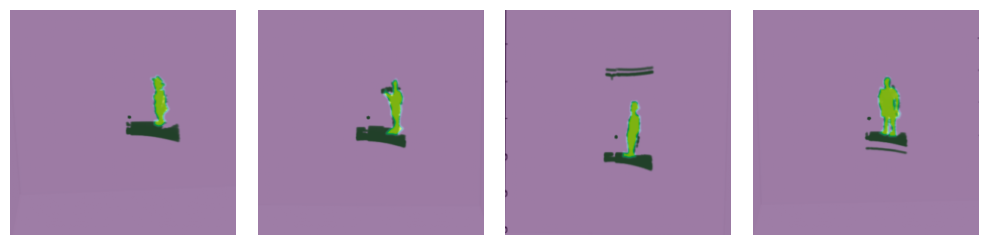

In [35]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

In [12]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou

In [19]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        x = torch.narrow(x, 1, 0, 3)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies

In [20]:
def evaluate(model, loader):
    model.eval()
    model.to(device=device)
    with torch.no_grad():
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        total = 0
        cost = 0
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            preds = torch.argmax(scores, dim=1)
            true_positives += ((preds == 1) & (y == 1)).sum().item()
            false_positives += ((preds == 1) & (y == 0)).sum().item()
            false_negatives += ((preds == 0) & (y == 1)).sum().item()
            total += torch.numel(preds)
        accuracy = true_positives / total
        recall = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)
        if (precision + recall) ==0:
            f1_score = 0
        else:
            f1_score = 2 * (precision * recall) / (precision + recall)
        true_negatives = total - true_positives - false_positives - false_negatives
        confusion_matrix = [[true_positives, false_positives], [false_negatives, true_negatives]]
        print("Confusion Matrix:")
        print(confusion_matrix)
        return cost / len(loader), accuracy, recall, precision, f1_score, confusion_matrix

In [21]:
import torch
from sklearn.metrics import confusion_matrix
def lift(model, loader):
    thresholds = torch.arange(0, 1.01, 0.01)
    tprs = []
    fprs = []
    for threshold in thresholds:
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        true_negatives = 0
        total = 0
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            preds = torch.where(scores[:, 1] > threshold, torch.tensor(1).to(device=device), torch.tensor(0).to(device=device))
            true_positives += ((preds == 1) & (y == 1)).sum().item()
            false_positives += ((preds == 1) & (y == 0)).sum().item()
            false_negatives += ((preds == 0) & (y == 1)).sum().item()
            true_negatives += ((preds == 0) & (y == 0)).sum().item()
            total += torch.numel(preds)
        tpr = true_positives / (true_positives + false_negatives)
        fpr = false_positives / (false_positives + true_negatives)
        tprs.append(tpr)
        fprs.append(fpr)
    return fprs, tprs

In [22]:
def train(model, optimiser, scheduler = None, epochs = 5000, store_every = 25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            if scheduler: 
                scheduler.step()
                
            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                loss, accuracy2, recall, precision, f1_score, confusion_matrix = evaluate(model, val_loader)
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')
            else:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')              
   

In [23]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [24]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
            
                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)
    
class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)
    
class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)
    
    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)
    
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) 
        self.down_conv1 = Down_Conv(channels, 2*channels) 
        self.down_conv2 = Down_Conv(2*channels, 4*channels) 
        self.down_conv3 = Down_Conv(4*channels, 8*channels) 
        
        self.middle_conv = Down_Conv(8*channels, 16*channels) 
        
        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)
        
        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)
        
    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)
        
        return self.last_conv(u4)

In [25]:
torch.manual_seed(42)
model = UNET(3, 4, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:0.9002, lr: 0.0000, acc: 0.0628
cost:0.8957, lr: 0.0000, acc: 0.0667
cost:0.8949, lr: 0.0000, acc: 0.0679
cost:0.9037, lr: 0.0001, acc: 0.0671
cost:0.8933, lr: 0.0006, acc: 0.0702
cost:0.8840, lr: 0.0032, acc: 0.0775
cost:0.8425, lr: 0.0158, acc: 0.1154
cost:0.7181, lr: 0.0794, acc: 0.1928
cost:0.3088, lr: 0.3981, acc: 0.4980
cost:0.0360, lr: 1.9953, acc: 0.4978
cost:0.2753, lr: 10.0000, acc: 0.4980


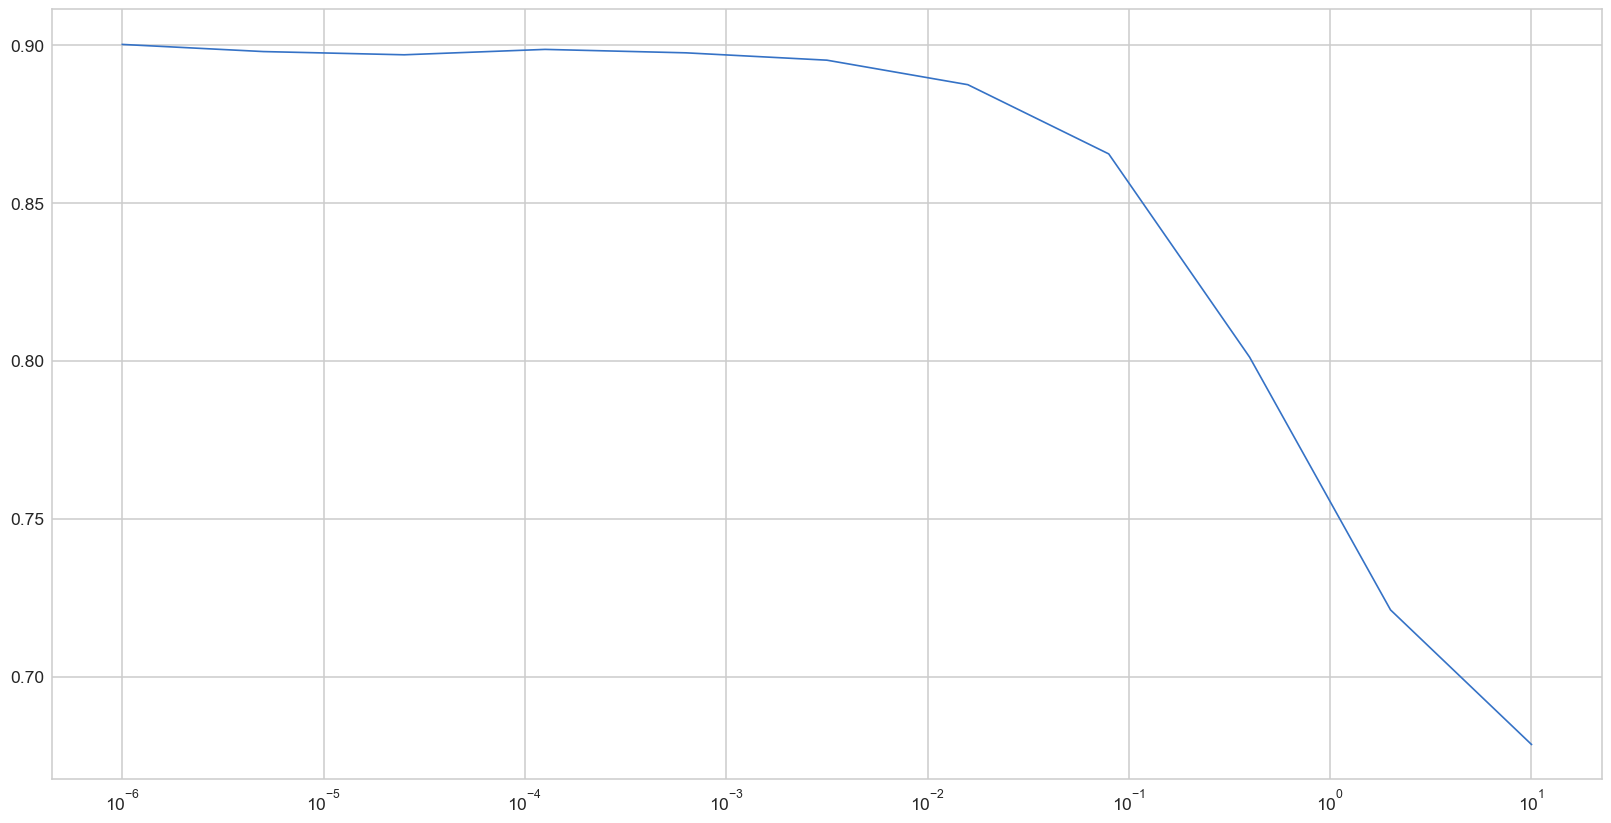

In [26]:
# Grafico loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [27]:
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 750
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 1e0,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [28]:
train(model, optimiser_unet, scheduler, epochs)
loss, accuracy2, recall, precision, f1_score, confusion_matrix = evaluate(model, val_loader)
print("Loss: {:.4f}".format(loss))
print("Accuracy: {:.4f}".format(accuracy2))
print("Recall: {:.4f}".format(recall))
print("Precision: {:.4f}".format(precision))
print("F1 Score: {:.4f}".format(f1_score))

epoch: 0, mb: 1, train cost: 0.9002, val cost: 0.7418,train acc: 0.1255, val acc: 0.3561,dice: 0.009868467226624489, iou: 0.004958700854331255
epoch: 0, mb: 2, train cost: 0.8204, val cost: 0.5272,train acc: 0.2453, val acc: 0.9110,dice: 0.00715151522308588, iou: 0.003588589606806636
epoch: 0, mb: 3, train cost: 0.7224, val cost: 0.3435,train acc: 0.4651, val acc: 0.9903,dice: 0.0, iou: 0.0
epoch: 0, mb: 4, train cost: 0.6277, val cost: 0.2021,train acc: 0.5965, val acc: 0.9949,dice: 0.0, iou: 0.0
epoch: 0, mb: 5, train cost: 0.5423, val cost: 0.1127,train acc: 0.6766, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 0, mb: 6, train cost: 0.4704, val cost: 0.0639,train acc: 0.7297, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 0, mb: 7, train cost: 0.4119, val cost: 0.0413,train acc: 0.7678, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 0, mb: 8, train cost: 0.3656, val cost: 0.0323,train acc: 0.7962, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 0, mb: 9, train cost: 0.3279, val cost: 0.0286,train a

epoch: 6, mb: 10, train cost: 0.0278, val cost: 0.0350,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 6, mb: 11, train cost: 0.0265, val cost: 0.0348,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 7, mb: 1, train cost: 0.0267, val cost: 0.0341,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 7, mb: 2, train cost: 0.0241, val cost: 0.0345,train acc: 0.9965, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 7, mb: 3, train cost: 0.0254, val cost: 0.0337,train acc: 0.9963, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 7, mb: 4, train cost: 0.0257, val cost: 0.0343,train acc: 0.9963, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 7, mb: 5, train cost: 0.0262, val cost: 0.0350,train acc: 0.9962, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 7, mb: 6, train cost: 0.0266, val cost: 0.0346,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 7, mb: 7, train cost: 0.0266, val cost: 0.0350,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 7, mb: 8, 

epoch: 13, mb: 8, train cost: 0.0224, val cost: 0.0294,train acc: 0.9962, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 13, mb: 9, train cost: 0.0227, val cost: 0.0297,train acc: 0.9962, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 13, mb: 10, train cost: 0.0236, val cost: 0.0291,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 13, mb: 11, train cost: 0.0231, val cost: 0.0295,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 14, mb: 1, train cost: 0.0269, val cost: 0.0290,train acc: 0.9954, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 14, mb: 2, train cost: 0.0235, val cost: 0.0290,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 14, mb: 3, train cost: 0.0245, val cost: 0.0295,train acc: 0.9958, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 14, mb: 4, train cost: 0.0240, val cost: 0.0295,train acc: 0.9959, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 14, mb: 5, train cost: 0.0242, val cost: 0.0290,train acc: 0.9958, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 1

epoch: 20, mb: 6, train cost: 0.0182, val cost: 0.0238,train acc: 0.9962, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 20, mb: 7, train cost: 0.0183, val cost: 0.0234,train acc: 0.9962, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 20, mb: 8, train cost: 0.0189, val cost: 0.0237,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 20, mb: 9, train cost: 0.0187, val cost: 0.0242,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 20, mb: 10, train cost: 0.0190, val cost: 0.0233,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 20, mb: 11, train cost: 0.0183, val cost: 0.0237,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 21, mb: 1, train cost: 0.0136, val cost: 0.0231,train acc: 0.9971, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 21, mb: 2, train cost: 0.0183, val cost: 0.0226,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 21, mb: 3, train cost: 0.0174, val cost: 0.0230,train acc: 0.9963, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 2

epoch: 27, mb: 4, train cost: 0.0163, val cost: 0.0186,train acc: 0.9956, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 27, mb: 5, train cost: 0.0156, val cost: 0.0184,train acc: 0.9958, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 27, mb: 6, train cost: 0.0154, val cost: 0.0186,train acc: 0.9959, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 27, mb: 7, train cost: 0.0153, val cost: 0.0184,train acc: 0.9959, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 27, mb: 8, train cost: 0.0152, val cost: 0.0178,train acc: 0.9959, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 27, mb: 9, train cost: 0.0148, val cost: 0.0183,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 27, mb: 10, train cost: 0.0146, val cost: 0.0179,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 27, mb: 11, train cost: 0.0150, val cost: 0.0184,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 28, mb: 1, train cost: 0.0142, val cost: 0.0179,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 2

epoch: 34, mb: 2, train cost: 0.0130, val cost: 0.0163,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 34, mb: 3, train cost: 0.0126, val cost: 0.0159,train acc: 0.9963, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 34, mb: 4, train cost: 0.0127, val cost: 0.0160,train acc: 0.9962, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 34, mb: 5, train cost: 0.0130, val cost: 0.0160,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 34, mb: 6, train cost: 0.0130, val cost: 0.0161,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 34, mb: 7, train cost: 0.0132, val cost: 0.0158,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 34, mb: 8, train cost: 0.0132, val cost: 0.0160,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 34, mb: 9, train cost: 0.0132, val cost: 0.0156,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 34, mb: 10, train cost: 0.0131, val cost: 0.0155,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 34

epoch: 40, mb: 11, train cost: 0.0101, val cost: 0.0119,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 41, mb: 1, train cost: 0.0113, val cost: 0.0118,train acc: 0.9951, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 41, mb: 2, train cost: 0.0107, val cost: 0.0120,train acc: 0.9955, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 41, mb: 3, train cost: 0.0100, val cost: 0.0116,train acc: 0.9959, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 41, mb: 4, train cost: 0.0104, val cost: 0.0118,train acc: 0.9957, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 41, mb: 5, train cost: 0.0099, val cost: 0.0117,train acc: 0.9959, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 41, mb: 6, train cost: 0.0099, val cost: 0.0118,train acc: 0.9959, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 41, mb: 7, train cost: 0.0093, val cost: 0.0114,train acc: 0.9962, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 41, mb: 8, train cost: 0.0095, val cost: 0.0116,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 41

epoch: 47, mb: 9, train cost: 0.0068, val cost: 0.0083,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 47, mb: 10, train cost: 0.0069, val cost: 0.0084,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 47, mb: 11, train cost: 0.0067, val cost: 0.0086,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 48, mb: 1, train cost: 0.0067, val cost: 0.0086,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 48, mb: 2, train cost: 0.0070, val cost: 0.0083,train acc: 0.9958, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 48, mb: 3, train cost: 0.0064, val cost: 0.0084,train acc: 0.9962, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 48, mb: 4, train cost: 0.0058, val cost: 0.0082,train acc: 0.9966, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 48, mb: 5, train cost: 0.0061, val cost: 0.0083,train acc: 0.9964, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 48, mb: 6, train cost: 0.0062, val cost: 0.0080,train acc: 0.9963, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 4

epoch: 54, mb: 7, train cost: 0.0057, val cost: 0.0068,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 54, mb: 8, train cost: 0.0056, val cost: 0.0067,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 54, mb: 9, train cost: 0.0057, val cost: 0.0069,train acc: 0.9959, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 54, mb: 10, train cost: 0.0057, val cost: 0.0068,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 54, mb: 11, train cost: 0.0055, val cost: 0.0066,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 55, mb: 1, train cost: 0.0061, val cost: 0.0063,train acc: 0.9953, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 55, mb: 2, train cost: 0.0054, val cost: 0.0066,train acc: 0.9958, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 55, mb: 3, train cost: 0.0050, val cost: 0.0065,train acc: 0.9962, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 55, mb: 4, train cost: 0.0051, val cost: 0.0071,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 5

epoch: 61, mb: 1, train cost: 0.0049, val cost: 0.0061,train acc: 0.9989, val acc: 0.9981,dice: 0.7905073761940002, iou: 0.6535859107971191
epoch: 61, mb: 2, train cost: 0.0048, val cost: 0.0072,train acc: 0.9988, val acc: 0.9974,dice: 0.6616541147232056, iou: 0.49438202381134033
epoch: 61, mb: 3, train cost: 0.0048, val cost: 0.0056,train acc: 0.9987, val acc: 0.9983,dice: 0.8075903058052063, iou: 0.6772758364677429
epoch: 61, mb: 4, train cost: 0.0047, val cost: 0.0054,train acc: 0.9988, val acc: 0.9984,dice: 0.8359168171882629, iou: 0.718090295791626
epoch: 61, mb: 5, train cost: 0.0046, val cost: 0.0053,train acc: 0.9988, val acc: 0.9984,dice: 0.8427433371543884, iou: 0.7282251119613647
epoch: 61, mb: 6, train cost: 0.0044, val cost: 0.0055,train acc: 0.9989, val acc: 0.9982,dice: 0.8359513878822327, iou: 0.7181413173675537
epoch: 61, mb: 7, train cost: 0.0044, val cost: 0.0056,train acc: 0.9988, val acc: 0.9979,dice: 0.8212168216705322, iou: 0.6966649293899536
epoch: 61, mb: 8, tr

epoch: 66, mb: 5, train cost: 0.0034, val cost: 0.0047,train acc: 0.9990, val acc: 0.9987,dice: 0.8641011118888855, iou: 0.7607201337814331
epoch: 66, mb: 6, train cost: 0.0034, val cost: 0.0048,train acc: 0.9990, val acc: 0.9985,dice: 0.8557553887367249, iou: 0.7478780150413513
epoch: 66, mb: 7, train cost: 0.0034, val cost: 0.0047,train acc: 0.9990, val acc: 0.9985,dice: 0.8435636162757874, iou: 0.7294509410858154
epoch: 66, mb: 8, train cost: 0.0034, val cost: 0.0050,train acc: 0.9990, val acc: 0.9984,dice: 0.8311136960983276, iou: 0.7110303640365601
epoch: 66, mb: 9, train cost: 0.0034, val cost: 0.0048,train acc: 0.9990, val acc: 0.9984,dice: 0.8288973569869995, iou: 0.7077922224998474
epoch: 66, mb: 10, train cost: 0.0034, val cost: 0.0047,train acc: 0.9990, val acc: 0.9985,dice: 0.8430221676826477, iou: 0.7286415696144104
epoch: 66, mb: 11, train cost: 0.0036, val cost: 0.0049,train acc: 0.9990, val acc: 0.9981,dice: 0.8314201235771179, iou: 0.7114790678024292
epoch: 67, mb: 1, 

epoch: 71, mb: 9, train cost: 0.0048, val cost: 0.0096,train acc: 0.9981, val acc: 0.9940,dice: 0.6268656849861145, iou: 0.45652174949645996
epoch: 71, mb: 10, train cost: 0.0053, val cost: 0.0080,train acc: 0.9977, val acc: 0.9955,dice: 0.6894394159317017, iou: 0.5260645151138306
epoch: 71, mb: 11, train cost: 0.0054, val cost: 0.0067,train acc: 0.9976, val acc: 0.9965,dice: 0.7396144270896912, iou: 0.5868160128593445
epoch: 72, mb: 1, train cost: 0.0055, val cost: 0.0059,train acc: 0.9969, val acc: 0.9976,dice: 0.8001801371574402, iou: 0.6669169068336487
epoch: 72, mb: 2, train cost: 0.0055, val cost: 0.0058,train acc: 0.9973, val acc: 0.9982,dice: 0.8340655565261841, iou: 0.7153623104095459
epoch: 72, mb: 3, train cost: 0.0054, val cost: 0.0066,train acc: 0.9976, val acc: 0.9982,dice: 0.8042391538619995, iou: 0.6725752353668213
epoch: 72, mb: 4, train cost: 0.0055, val cost: 0.0086,train acc: 0.9978, val acc: 0.9973,dice: 0.638875424861908, iou: 0.4693732261657715
epoch: 72, mb: 5, 

epoch: 77, mb: 2, train cost: 0.0046, val cost: 0.0052,train acc: 0.9983, val acc: 0.9983,dice: 0.826852560043335, iou: 0.7048155069351196
epoch: 77, mb: 3, train cost: 0.0048, val cost: 0.0050,train acc: 0.9983, val acc: 0.9981,dice: 0.823470413684845, iou: 0.6999147534370422
epoch: 77, mb: 4, train cost: 0.0047, val cost: 0.0054,train acc: 0.9983, val acc: 0.9978,dice: 0.8056169152259827, iou: 0.6745046377182007
epoch: 77, mb: 5, train cost: 0.0048, val cost: 0.0056,train acc: 0.9983, val acc: 0.9975,dice: 0.7916037440299988, iou: 0.6550862193107605
epoch: 77, mb: 6, train cost: 0.0047, val cost: 0.0057,train acc: 0.9983, val acc: 0.9976,dice: 0.7966309189796448, iou: 0.6620005369186401
epoch: 77, mb: 7, train cost: 0.0047, val cost: 0.0054,train acc: 0.9982, val acc: 0.9978,dice: 0.8052698969841003, iou: 0.6740182638168335
epoch: 77, mb: 8, train cost: 0.0047, val cost: 0.0051,train acc: 0.9981, val acc: 0.9981,dice: 0.81160968542099, iou: 0.6829487681388855
epoch: 77, mb: 9, train 

epoch: 82, mb: 6, train cost: 0.0036, val cost: 0.0075,train acc: 0.9987, val acc: 0.9961,dice: 0.3817547857761383, iou: 0.23590664565563202
epoch: 82, mb: 7, train cost: 0.0043, val cost: 0.0044,train acc: 0.9983, val acc: 0.9985,dice: 0.8352306485176086, iou: 0.7170782089233398
epoch: 82, mb: 8, train cost: 0.0042, val cost: 0.0045,train acc: 0.9984, val acc: 0.9985,dice: 0.8508480787277222, iou: 0.7404139041900635
epoch: 82, mb: 9, train cost: 0.0042, val cost: 0.0050,train acc: 0.9984, val acc: 0.9979,dice: 0.8189176321029663, iou: 0.6933619976043701
epoch: 82, mb: 10, train cost: 0.0042, val cost: 0.0052,train acc: 0.9984, val acc: 0.9979,dice: 0.819783627986908, iou: 0.6946045160293579
epoch: 82, mb: 11, train cost: 0.0044, val cost: 0.0053,train acc: 0.9983, val acc: 0.9978,dice: 0.8108439445495605, iou: 0.6818650364875793
epoch: 83, mb: 1, train cost: 0.0041, val cost: 0.0055,train acc: 0.9983, val acc: 0.9975,dice: 0.7962684035301208, iou: 0.6614999771118164
epoch: 83, mb: 2, 

epoch: 87, mb: 10, train cost: 0.0038, val cost: 0.0057,train acc: 0.9986, val acc: 0.9973,dice: 0.7823925018310547, iou: 0.6425654292106628
epoch: 87, mb: 11, train cost: 0.0039, val cost: 0.0056,train acc: 0.9985, val acc: 0.9975,dice: 0.7956050634384155, iou: 0.6605848670005798
epoch: 88, mb: 1, train cost: 0.0041, val cost: 0.0048,train acc: 0.9983, val acc: 0.9981,dice: 0.8313524127006531, iou: 0.711379885673523
epoch: 88, mb: 2, train cost: 0.0039, val cost: 0.0047,train acc: 0.9984, val acc: 0.9984,dice: 0.8467332124710083, iou: 0.734204113483429
epoch: 88, mb: 3, train cost: 0.0041, val cost: 0.0052,train acc: 0.9984, val acc: 0.9983,dice: 0.8129725456237793, iou: 0.6848809719085693
epoch: 88, mb: 4, train cost: 0.0039, val cost: 0.0063,train acc: 0.9986, val acc: 0.9980,dice: 0.7589920163154602, iou: 0.6115931868553162
epoch: 88, mb: 5, train cost: 0.0038, val cost: 0.0060,train acc: 0.9986, val acc: 0.9980,dice: 0.7670588493347168, iou: 0.6221374273300171
epoch: 88, mb: 6, tr

epoch: 93, mb: 3, train cost: 0.0041, val cost: 0.0059,train acc: 0.9981, val acc: 0.9971,dice: 0.7685211896896362, iou: 0.6240636706352234
epoch: 93, mb: 4, train cost: 0.0042, val cost: 0.0056,train acc: 0.9981, val acc: 0.9975,dice: 0.7881818413734436, iou: 0.6504126191139221
epoch: 93, mb: 5, train cost: 0.0041, val cost: 0.0053,train acc: 0.9981, val acc: 0.9978,dice: 0.811248779296875, iou: 0.6824378371238708
epoch: 93, mb: 6, train cost: 0.0040, val cost: 0.0054,train acc: 0.9982, val acc: 0.9982,dice: 0.8331332802772522, iou: 0.7139917612075806
epoch: 93, mb: 7, train cost: 0.0041, val cost: 0.0055,train acc: 0.9983, val acc: 0.9984,dice: 0.8382432460784912, iou: 0.7215307950973511
epoch: 93, mb: 8, train cost: 0.0041, val cost: 0.0059,train acc: 0.9983, val acc: 0.9984,dice: 0.8274942636489868, iou: 0.7057486176490784
epoch: 93, mb: 9, train cost: 0.0042, val cost: 0.0061,train acc: 0.9983, val acc: 0.9983,dice: 0.8166666626930237, iou: 0.6901408433914185
epoch: 93, mb: 10, tr

epoch: 98, mb: 7, train cost: 0.0033, val cost: 0.0043,train acc: 0.9988, val acc: 0.9986,dice: 0.8565641641616821, iou: 0.7491143345832825
epoch: 98, mb: 8, train cost: 0.0033, val cost: 0.0043,train acc: 0.9988, val acc: 0.9985,dice: 0.8402182459831238, iou: 0.7244623899459839
epoch: 98, mb: 9, train cost: 0.0032, val cost: 0.0050,train acc: 0.9988, val acc: 0.9981,dice: 0.7784810066223145, iou: 0.6373056769371033
epoch: 98, mb: 10, train cost: 0.0033, val cost: 0.0045,train acc: 0.9988, val acc: 0.9984,dice: 0.8264166116714478, iou: 0.7041822671890259
epoch: 98, mb: 11, train cost: 0.0036, val cost: 0.0042,train acc: 0.9987, val acc: 0.9985,dice: 0.8501055836677551, iou: 0.7392900586128235
epoch: 99, mb: 1, train cost: 0.0029, val cost: 0.0045,train acc: 0.9987, val acc: 0.9982,dice: 0.8400460481643677, iou: 0.7242063283920288
epoch: 99, mb: 2, train cost: 0.0037, val cost: 0.0048,train acc: 0.9984, val acc: 0.9981,dice: 0.8306578397750854, iou: 0.7103633880615234
epoch: 99, mb: 3, 

epoch: 103, mb: 11, train cost: 0.0030, val cost: 0.0044,train acc: 0.9989, val acc: 0.9984,dice: 0.8272412419319153, iou: 0.7053805589675903
epoch: 104, mb: 1, train cost: 0.0026, val cost: 0.0045,train acc: 0.9991, val acc: 0.9983,dice: 0.8242560625076294, iou: 0.7010506391525269
epoch: 104, mb: 2, train cost: 0.0025, val cost: 0.0047,train acc: 0.9991, val acc: 0.9981,dice: 0.8096029758453369, iou: 0.6801117062568665
epoch: 104, mb: 3, train cost: 0.0027, val cost: 0.0042,train acc: 0.9990, val acc: 0.9985,dice: 0.8492363095283508, iou: 0.7379762530326843
epoch: 104, mb: 4, train cost: 0.0027, val cost: 0.0043,train acc: 0.9990, val acc: 0.9983,dice: 0.8306280970573425, iou: 0.7103198766708374
epoch: 104, mb: 5, train cost: 0.0028, val cost: 0.0043,train acc: 0.9990, val acc: 0.9983,dice: 0.8396143913269043, iou: 0.7235649824142456
epoch: 104, mb: 6, train cost: 0.0029, val cost: 0.0042,train acc: 0.9990, val acc: 0.9984,dice: 0.8368768095970154, iou: 0.7195083498954773
epoch: 104, 

epoch: 109, mb: 4, train cost: 0.0035, val cost: 0.0042,train acc: 0.9988, val acc: 0.9984,dice: 0.843670666217804, iou: 0.7296110391616821
epoch: 109, mb: 5, train cost: 0.0032, val cost: 0.0041,train acc: 0.9989, val acc: 0.9984,dice: 0.8477006554603577, iou: 0.7356600761413574
epoch: 109, mb: 6, train cost: 0.0031, val cost: 0.0041,train acc: 0.9989, val acc: 0.9984,dice: 0.8505270481109619, iou: 0.7399278283119202
epoch: 109, mb: 7, train cost: 0.0029, val cost: 0.0042,train acc: 0.9990, val acc: 0.9984,dice: 0.84914630651474, iou: 0.7378402948379517
epoch: 109, mb: 8, train cost: 0.0029, val cost: 0.0044,train acc: 0.9990, val acc: 0.9983,dice: 0.8308140635490417, iou: 0.7105919122695923
epoch: 109, mb: 9, train cost: 0.0029, val cost: 0.0050,train acc: 0.9990, val acc: 0.9984,dice: 0.8282982707023621, iou: 0.7069190740585327
epoch: 109, mb: 10, train cost: 0.0029, val cost: 0.0055,train acc: 0.9990, val acc: 0.9981,dice: 0.7955582141876221, iou: 0.6605202555656433
epoch: 109, mb:

epoch: 114, mb: 8, train cost: 0.0029, val cost: 0.0041,train acc: 0.9989, val acc: 0.9985,dice: 0.8573848009109497, iou: 0.7503705620765686
epoch: 114, mb: 9, train cost: 0.0029, val cost: 0.0040,train acc: 0.9989, val acc: 0.9985,dice: 0.8580006957054138, iou: 0.7513145804405212
epoch: 114, mb: 10, train cost: 0.0029, val cost: 0.0040,train acc: 0.9989, val acc: 0.9986,dice: 0.8505135178565979, iou: 0.7399073243141174
epoch: 114, mb: 11, train cost: 0.0028, val cost: 0.0051,train acc: 0.9989, val acc: 0.9983,dice: 0.8109523057937622, iou: 0.6820182800292969
epoch: 115, mb: 1, train cost: 0.0025, val cost: 0.0049,train acc: 0.9992, val acc: 0.9982,dice: 0.7991684079170227, iou: 0.6655124425888062
epoch: 115, mb: 2, train cost: 0.0027, val cost: 0.0045,train acc: 0.9991, val acc: 0.9983,dice: 0.8185936808586121, iou: 0.692897617816925
epoch: 115, mb: 3, train cost: 0.0028, val cost: 0.0041,train acc: 0.9991, val acc: 0.9986,dice: 0.8566685318946838, iou: 0.749273955821991
epoch: 115, m

epoch: 120, mb: 1, train cost: 0.0022, val cost: 0.0050,train acc: 0.9992, val acc: 0.9979,dice: 0.8185219764709473, iou: 0.692794919013977
epoch: 120, mb: 2, train cost: 0.0026, val cost: 0.0057,train acc: 0.9989, val acc: 0.9974,dice: 0.7874615788459778, iou: 0.6494322419166565
epoch: 120, mb: 3, train cost: 0.0031, val cost: 0.0051,train acc: 0.9986, val acc: 0.9977,dice: 0.811188817024231, iou: 0.6823529601097107
epoch: 120, mb: 4, train cost: 0.0034, val cost: 0.0046,train acc: 0.9985, val acc: 0.9981,dice: 0.8355812430381775, iou: 0.7175951600074768
epoch: 120, mb: 5, train cost: 0.0032, val cost: 0.0045,train acc: 0.9986, val acc: 0.9984,dice: 0.8439204692840576, iou: 0.7299847602844238
epoch: 120, mb: 6, train cost: 0.0033, val cost: 0.0050,train acc: 0.9986, val acc: 0.9984,dice: 0.8282867074012756, iou: 0.7069022059440613
epoch: 120, mb: 7, train cost: 0.0034, val cost: 0.0057,train acc: 0.9986, val acc: 0.9982,dice: 0.8024691343307495, iou: 0.6701030731201172
epoch: 120, mb:

epoch: 125, mb: 5, train cost: 0.0028, val cost: 0.0051,train acc: 0.9990, val acc: 0.9981,dice: 0.7900631427764893, iou: 0.652978777885437
epoch: 125, mb: 6, train cost: 0.0029, val cost: 0.0041,train acc: 0.9990, val acc: 0.9985,dice: 0.8440860509872437, iou: 0.7302325367927551
epoch: 125, mb: 7, train cost: 0.0029, val cost: 0.0039,train acc: 0.9989, val acc: 0.9986,dice: 0.858856737613678, iou: 0.7526283264160156
epoch: 125, mb: 8, train cost: 0.0029, val cost: 0.0039,train acc: 0.9989, val acc: 0.9985,dice: 0.8577651381492615, iou: 0.7509533762931824
epoch: 125, mb: 9, train cost: 0.0029, val cost: 0.0040,train acc: 0.9989, val acc: 0.9985,dice: 0.8632004261016846, iou: 0.7593250274658203
epoch: 125, mb: 10, train cost: 0.0029, val cost: 0.0040,train acc: 0.9989, val acc: 0.9985,dice: 0.8534722328186035, iou: 0.7443973422050476
epoch: 125, mb: 11, train cost: 0.0028, val cost: 0.0040,train acc: 0.9989, val acc: 0.9985,dice: 0.8458755612373352, iou: 0.7329153418540955
epoch: 126, m

epoch: 130, mb: 9, train cost: 0.0025, val cost: 0.0040,train acc: 0.9991, val acc: 0.9985,dice: 0.8564847707748413, iou: 0.7489928603172302
epoch: 130, mb: 10, train cost: 0.0025, val cost: 0.0039,train acc: 0.9991, val acc: 0.9986,dice: 0.8629221320152283, iou: 0.7588945627212524
epoch: 130, mb: 11, train cost: 0.0026, val cost: 0.0039,train acc: 0.9991, val acc: 0.9987,dice: 0.8657544255256653, iou: 0.7632865905761719
epoch: 131, mb: 1, train cost: 0.0020, val cost: 0.0042,train acc: 0.9992, val acc: 0.9985,dice: 0.8488394021987915, iou: 0.7373770475387573
epoch: 131, mb: 2, train cost: 0.0021, val cost: 0.0044,train acc: 0.9993, val acc: 0.9986,dice: 0.8462280631065369, iou: 0.7334448099136353
epoch: 131, mb: 3, train cost: 0.0023, val cost: 0.0041,train acc: 0.9992, val acc: 0.9986,dice: 0.8575207591056824, iou: 0.7505788803100586
epoch: 131, mb: 4, train cost: 0.0022, val cost: 0.0041,train acc: 0.9992, val acc: 0.9986,dice: 0.8549926280975342, iou: 0.7467136979103088
epoch: 131,

epoch: 136, mb: 2, train cost: 0.0020, val cost: 0.0043,train acc: 0.9993, val acc: 0.9984,dice: 0.8344814777374268, iou: 0.7159744501113892
epoch: 136, mb: 3, train cost: 0.0023, val cost: 0.0043,train acc: 0.9991, val acc: 0.9983,dice: 0.8336805701255798, iou: 0.7147960662841797
epoch: 136, mb: 4, train cost: 0.0023, val cost: 0.0044,train acc: 0.9992, val acc: 0.9982,dice: 0.8307640552520752, iou: 0.7105187773704529
epoch: 136, mb: 5, train cost: 0.0024, val cost: 0.0045,train acc: 0.9991, val acc: 0.9981,dice: 0.8216485977172852, iou: 0.6972866058349609
epoch: 136, mb: 6, train cost: 0.0024, val cost: 0.0045,train acc: 0.9991, val acc: 0.9982,dice: 0.8258417248725891, iou: 0.7033478617668152
epoch: 136, mb: 7, train cost: 0.0025, val cost: 0.0045,train acc: 0.9991, val acc: 0.9982,dice: 0.8200260400772095, iou: 0.694952666759491
epoch: 136, mb: 8, train cost: 0.0025, val cost: 0.0053,train acc: 0.9991, val acc: 0.9981,dice: 0.7910386919975281, iou: 0.6543126702308655
epoch: 136, mb

epoch: 141, mb: 6, train cost: 0.0027, val cost: 0.0060,train acc: 0.9990, val acc: 0.9982,dice: 0.8076463341712952, iou: 0.6773546934127808
epoch: 141, mb: 7, train cost: 0.0029, val cost: 0.0047,train acc: 0.9990, val acc: 0.9982,dice: 0.8282240033149719, iou: 0.7068108916282654
epoch: 141, mb: 8, train cost: 0.0029, val cost: 0.0050,train acc: 0.9990, val acc: 0.9978,dice: 0.8076376914978027, iou: 0.6773425340652466
epoch: 141, mb: 9, train cost: 0.0029, val cost: 0.0051,train acc: 0.9990, val acc: 0.9976,dice: 0.8001222610473633, iou: 0.6668365001678467
epoch: 141, mb: 10, train cost: 0.0030, val cost: 0.0048,train acc: 0.9989, val acc: 0.9979,dice: 0.8178903460502625, iou: 0.6918904185295105
epoch: 141, mb: 11, train cost: 0.0031, val cost: 0.0043,train acc: 0.9989, val acc: 0.9983,dice: 0.8315712809562683, iou: 0.711700439453125
epoch: 142, mb: 1, train cost: 0.0026, val cost: 0.0052,train acc: 0.9991, val acc: 0.9982,dice: 0.7983126044273376, iou: 0.6643263101577759
epoch: 142, 

epoch: 146, mb: 10, train cost: 0.0025, val cost: 0.0042,train acc: 0.9991, val acc: 0.9984,dice: 0.8444204330444336, iou: 0.7307332158088684
epoch: 146, mb: 11, train cost: 0.0025, val cost: 0.0042,train acc: 0.9991, val acc: 0.9984,dice: 0.8384135365486145, iou: 0.7217831015586853
epoch: 147, mb: 1, train cost: 0.0019, val cost: 0.0043,train acc: 0.9993, val acc: 0.9984,dice: 0.8271534442901611, iou: 0.7052529454231262
epoch: 147, mb: 2, train cost: 0.0021, val cost: 0.0043,train acc: 0.9992, val acc: 0.9984,dice: 0.8288219571113586, iou: 0.7076823115348816
epoch: 147, mb: 3, train cost: 0.0022, val cost: 0.0040,train acc: 0.9991, val acc: 0.9985,dice: 0.8417545557022095, iou: 0.7267497777938843
epoch: 147, mb: 4, train cost: 0.0023, val cost: 0.0046,train acc: 0.9991, val acc: 0.9983,dice: 0.8273579478263855, iou: 0.7055503129959106
epoch: 147, mb: 5, train cost: 0.0023, val cost: 0.0046,train acc: 0.9992, val acc: 0.9983,dice: 0.8262391686439514, iou: 0.7039246559143066
epoch: 147,

epoch: 152, mb: 3, train cost: 0.0021, val cost: 0.0043,train acc: 0.9992, val acc: 0.9985,dice: 0.8459490537643433, iou: 0.7330257296562195
epoch: 152, mb: 4, train cost: 0.0022, val cost: 0.0044,train acc: 0.9992, val acc: 0.9984,dice: 0.8401527404785156, iou: 0.7243649959564209
epoch: 152, mb: 5, train cost: 0.0023, val cost: 0.0046,train acc: 0.9992, val acc: 0.9982,dice: 0.8331641554832458, iou: 0.7140371203422546
epoch: 152, mb: 6, train cost: 0.0023, val cost: 0.0045,train acc: 0.9991, val acc: 0.9982,dice: 0.8344370722770691, iou: 0.7159090638160706
epoch: 152, mb: 7, train cost: 0.0024, val cost: 0.0044,train acc: 0.9991, val acc: 0.9984,dice: 0.8375179171562195, iou: 0.7204566597938538
epoch: 152, mb: 8, train cost: 0.0024, val cost: 0.0046,train acc: 0.9991, val acc: 0.9984,dice: 0.8304027318954468, iou: 0.7099903225898743
epoch: 152, mb: 9, train cost: 0.0024, val cost: 0.0049,train acc: 0.9991, val acc: 0.9983,dice: 0.8244303464889526, iou: 0.7013028264045715
epoch: 152, m

epoch: 157, mb: 7, train cost: 0.0023, val cost: 0.0047,train acc: 0.9992, val acc: 0.9984,dice: 0.837056040763855, iou: 0.7197732925415039
epoch: 157, mb: 8, train cost: 0.0023, val cost: 0.0044,train acc: 0.9992, val acc: 0.9984,dice: 0.8430200815200806, iou: 0.7286384701728821
epoch: 157, mb: 9, train cost: 0.0023, val cost: 0.0046,train acc: 0.9992, val acc: 0.9985,dice: 0.8412845730781555, iou: 0.7260493636131287
epoch: 157, mb: 10, train cost: 0.0024, val cost: 0.0044,train acc: 0.9992, val acc: 0.9985,dice: 0.8498664498329163, iou: 0.7389284372329712
epoch: 157, mb: 11, train cost: 0.0023, val cost: 0.0045,train acc: 0.9992, val acc: 0.9983,dice: 0.8423941135406494, iou: 0.7277036905288696
epoch: 158, mb: 1, train cost: 0.0021, val cost: 0.0047,train acc: 0.9992, val acc: 0.9982,dice: 0.8317406177520752, iou: 0.711948573589325
epoch: 158, mb: 2, train cost: 0.0025, val cost: 0.0044,train acc: 0.9990, val acc: 0.9985,dice: 0.8460706472396851, iou: 0.7332083582878113
epoch: 158, m

epoch: 162, mb: 11, train cost: 0.0026, val cost: 0.0037,train acc: 0.9991, val acc: 0.9986,dice: 0.8628714680671692, iou: 0.758816123008728
epoch: 163, mb: 1, train cost: 0.0025, val cost: 0.0041,train acc: 0.9990, val acc: 0.9986,dice: 0.85465008020401, iou: 0.7461912631988525
epoch: 163, mb: 2, train cost: 0.0023, val cost: 0.0042,train acc: 0.9992, val acc: 0.9985,dice: 0.8396478891372681, iou: 0.7236147522926331
epoch: 163, mb: 3, train cost: 0.0021, val cost: 0.0040,train acc: 0.9992, val acc: 0.9985,dice: 0.8448309302330017, iou: 0.7313482761383057
epoch: 163, mb: 4, train cost: 0.0024, val cost: 0.0041,train acc: 0.9992, val acc: 0.9984,dice: 0.8395456075668335, iou: 0.7234628200531006
epoch: 163, mb: 5, train cost: 0.0023, val cost: 0.0042,train acc: 0.9992, val acc: 0.9985,dice: 0.8547008633613586, iou: 0.746268630027771
epoch: 163, mb: 6, train cost: 0.0024, val cost: 0.0042,train acc: 0.9991, val acc: 0.9984,dice: 0.8415319919586182, iou: 0.7264179587364197
epoch: 163, mb: 

epoch: 168, mb: 4, train cost: 0.0021, val cost: 0.0048,train acc: 0.9993, val acc: 0.9981,dice: 0.8236083388328552, iou: 0.7001140117645264
epoch: 168, mb: 5, train cost: 0.0022, val cost: 0.0049,train acc: 0.9992, val acc: 0.9981,dice: 0.8211024403572083, iou: 0.696500301361084
epoch: 168, mb: 6, train cost: 0.0021, val cost: 0.0048,train acc: 0.9992, val acc: 0.9984,dice: 0.8397193551063538, iou: 0.723720908164978
epoch: 168, mb: 7, train cost: 0.0021, val cost: 0.0051,train acc: 0.9993, val acc: 0.9984,dice: 0.8337711095809937, iou: 0.7149292230606079
epoch: 168, mb: 8, train cost: 0.0021, val cost: 0.0052,train acc: 0.9993, val acc: 0.9983,dice: 0.8184394240379333, iou: 0.6926766633987427
epoch: 168, mb: 9, train cost: 0.0021, val cost: 0.0046,train acc: 0.9993, val acc: 0.9984,dice: 0.8388634324073792, iou: 0.7224502563476562
epoch: 168, mb: 10, train cost: 0.0020, val cost: 0.0046,train acc: 0.9993, val acc: 0.9983,dice: 0.8399023413658142, iou: 0.7239927649497986
epoch: 168, mb

epoch: 173, mb: 8, train cost: 0.0019, val cost: 0.0048,train acc: 0.9994, val acc: 0.9984,dice: 0.8425394296646118, iou: 0.727920651435852
epoch: 173, mb: 9, train cost: 0.0019, val cost: 0.0048,train acc: 0.9994, val acc: 0.9984,dice: 0.8366490006446838, iou: 0.7191716432571411
epoch: 173, mb: 10, train cost: 0.0019, val cost: 0.0046,train acc: 0.9994, val acc: 0.9985,dice: 0.8500555157661438, iou: 0.7392144203186035
epoch: 173, mb: 11, train cost: 0.0018, val cost: 0.0047,train acc: 0.9994, val acc: 0.9985,dice: 0.8452956676483154, iou: 0.7320451140403748
epoch: 174, mb: 1, train cost: 0.0016, val cost: 0.0048,train acc: 0.9995, val acc: 0.9984,dice: 0.8407619595527649, iou: 0.7252712249755859
epoch: 174, mb: 2, train cost: 0.0017, val cost: 0.0046,train acc: 0.9994, val acc: 0.9984,dice: 0.8410714268684387, iou: 0.7257319092750549
epoch: 174, mb: 3, train cost: 0.0017, val cost: 0.0048,train acc: 0.9994, val acc: 0.9984,dice: 0.8424058556556702, iou: 0.7277212738990784
epoch: 174, 

epoch: 179, mb: 1, train cost: 0.0022, val cost: 0.0055,train acc: 0.9993, val acc: 0.9982,dice: 0.8175263404846191, iou: 0.6913695931434631
epoch: 179, mb: 2, train cost: 0.0020, val cost: 0.0052,train acc: 0.9993, val acc: 0.9982,dice: 0.8252532482147217, iou: 0.7024946212768555
epoch: 179, mb: 3, train cost: 0.0020, val cost: 0.0051,train acc: 0.9993, val acc: 0.9981,dice: 0.8207547068595886, iou: 0.6959999799728394
epoch: 179, mb: 4, train cost: 0.0020, val cost: 0.0053,train acc: 0.9993, val acc: 0.9982,dice: 0.8238144516944885, iou: 0.7004120349884033
epoch: 179, mb: 5, train cost: 0.0020, val cost: 0.0049,train acc: 0.9993, val acc: 0.9982,dice: 0.8239179849624634, iou: 0.7005616426467896
epoch: 179, mb: 6, train cost: 0.0019, val cost: 0.0053,train acc: 0.9993, val acc: 0.9982,dice: 0.8202929496765137, iou: 0.6953361630439758
epoch: 179, mb: 7, train cost: 0.0018, val cost: 0.0051,train acc: 0.9994, val acc: 0.9983,dice: 0.826015055179596, iou: 0.7035993933677673
epoch: 179, mb

epoch: 184, mb: 5, train cost: 0.0020, val cost: 0.0047,train acc: 0.9993, val acc: 0.9983,dice: 0.8352302312850952, iou: 0.7170775532722473
epoch: 184, mb: 6, train cost: 0.0019, val cost: 0.0048,train acc: 0.9993, val acc: 0.9983,dice: 0.8271627426147461, iou: 0.7052664160728455
epoch: 184, mb: 7, train cost: 0.0020, val cost: 0.0045,train acc: 0.9993, val acc: 0.9984,dice: 0.8361266255378723, iou: 0.7184000015258789
epoch: 184, mb: 8, train cost: 0.0020, val cost: 0.0043,train acc: 0.9993, val acc: 0.9984,dice: 0.8451822400093079, iou: 0.7318750023841858
epoch: 184, mb: 9, train cost: 0.0019, val cost: 0.0042,train acc: 0.9993, val acc: 0.9984,dice: 0.8479214310646057, iou: 0.7359926700592041
epoch: 184, mb: 10, train cost: 0.0019, val cost: 0.0044,train acc: 0.9993, val acc: 0.9985,dice: 0.8557726740837097, iou: 0.747904360294342
epoch: 184, mb: 11, train cost: 0.0020, val cost: 0.0045,train acc: 0.9993, val acc: 0.9985,dice: 0.8417418003082275, iou: 0.7267307043075562
epoch: 185, 

epoch: 189, mb: 9, train cost: 0.0019, val cost: 0.0053,train acc: 0.9993, val acc: 0.9982,dice: 0.8183161020278931, iou: 0.6924999952316284
epoch: 189, mb: 10, train cost: 0.0019, val cost: 0.0050,train acc: 0.9993, val acc: 0.9983,dice: 0.8317214846611023, iou: 0.7119205594062805
epoch: 189, mb: 11, train cost: 0.0019, val cost: 0.0048,train acc: 0.9993, val acc: 0.9984,dice: 0.8398237824440002, iou: 0.7238760590553284
epoch: 190, mb: 1, train cost: 0.0020, val cost: 0.0047,train acc: 0.9993, val acc: 0.9983,dice: 0.8327044248580933, iou: 0.7133620977401733
epoch: 190, mb: 2, train cost: 0.0016, val cost: 0.0050,train acc: 0.9995, val acc: 0.9984,dice: 0.8387579321861267, iou: 0.7222937941551208
epoch: 190, mb: 3, train cost: 0.0015, val cost: 0.0054,train acc: 0.9995, val acc: 0.9984,dice: 0.8270792961120605, iou: 0.7051451206207275
epoch: 190, mb: 4, train cost: 0.0017, val cost: 0.0047,train acc: 0.9994, val acc: 0.9985,dice: 0.8413353562355042, iou: 0.7261249423027039
epoch: 190,

epoch: 195, mb: 2, train cost: 0.0018, val cost: 0.0045,train acc: 0.9994, val acc: 0.9985,dice: 0.8475452065467834, iou: 0.7354260087013245
epoch: 195, mb: 3, train cost: 0.0019, val cost: 0.0043,train acc: 0.9993, val acc: 0.9985,dice: 0.8520417213439941, iou: 0.7422236204147339
epoch: 195, mb: 4, train cost: 0.0019, val cost: 0.0044,train acc: 0.9993, val acc: 0.9984,dice: 0.8471359610557556, iou: 0.734809935092926
epoch: 195, mb: 5, train cost: 0.0019, val cost: 0.0044,train acc: 0.9993, val acc: 0.9983,dice: 0.8412916660308838, iou: 0.7260599136352539
epoch: 195, mb: 6, train cost: 0.0019, val cost: 0.0046,train acc: 0.9993, val acc: 0.9983,dice: 0.837257981300354, iou: 0.7200720310211182
epoch: 195, mb: 7, train cost: 0.0019, val cost: 0.0045,train acc: 0.9993, val acc: 0.9985,dice: 0.8397976160049438, iou: 0.7238371968269348
epoch: 195, mb: 8, train cost: 0.0018, val cost: 0.0055,train acc: 0.9993, val acc: 0.9981,dice: 0.8082320094108582, iou: 0.6781789660453796
epoch: 195, mb:

epoch: 200, mb: 6, train cost: 0.0017, val cost: 0.0050,train acc: 0.9994, val acc: 0.9981,dice: 0.8274263143539429, iou: 0.705649733543396
epoch: 200, mb: 7, train cost: 0.0018, val cost: 0.0050,train acc: 0.9994, val acc: 0.9981,dice: 0.8252862095832825, iou: 0.7025423645973206
epoch: 200, mb: 8, train cost: 0.0018, val cost: 0.0049,train acc: 0.9994, val acc: 0.9982,dice: 0.8278775215148926, iou: 0.7063062787055969
epoch: 200, mb: 9, train cost: 0.0017, val cost: 0.0051,train acc: 0.9994, val acc: 0.9982,dice: 0.8139233589172363, iou: 0.6862316727638245
epoch: 200, mb: 10, train cost: 0.0017, val cost: 0.0054,train acc: 0.9994, val acc: 0.9982,dice: 0.8110944628715515, iou: 0.6822194457054138
epoch: 200, mb: 11, train cost: 0.0018, val cost: 0.0052,train acc: 0.9994, val acc: 0.9981,dice: 0.81343013048172, iou: 0.6855307221412659
epoch: 201, mb: 1, train cost: 0.0013, val cost: 0.0049,train acc: 0.9996, val acc: 0.9983,dice: 0.8336856961250305, iou: 0.7148036360740662
epoch: 201, mb

epoch: 205, mb: 10, train cost: 0.0017, val cost: 0.0053,train acc: 0.9994, val acc: 0.9981,dice: 0.8258756399154663, iou: 0.7033970952033997
epoch: 205, mb: 11, train cost: 0.0017, val cost: 0.0055,train acc: 0.9994, val acc: 0.9979,dice: 0.8150390386581421, iou: 0.6878193020820618
epoch: 206, mb: 1, train cost: 0.0030, val cost: 0.0051,train acc: 0.9988, val acc: 0.9981,dice: 0.8221778273582458, iou: 0.6980491876602173
epoch: 206, mb: 2, train cost: 0.0025, val cost: 0.0056,train acc: 0.9991, val acc: 0.9981,dice: 0.809872031211853, iou: 0.68049156665802
epoch: 206, mb: 3, train cost: 0.0023, val cost: 0.0067,train acc: 0.9991, val acc: 0.9980,dice: 0.7769985795021057, iou: 0.6353210806846619
epoch: 206, mb: 4, train cost: 0.0023, val cost: 0.0059,train acc: 0.9991, val acc: 0.9981,dice: 0.8030592799186707, iou: 0.6709265112876892
epoch: 206, mb: 5, train cost: 0.0022, val cost: 0.0056,train acc: 0.9992, val acc: 0.9981,dice: 0.8207088112831116, iou: 0.695933997631073
epoch: 206, mb:

epoch: 211, mb: 3, train cost: 0.0027, val cost: 0.0047,train acc: 0.9989, val acc: 0.9984,dice: 0.829390287399292, iou: 0.7085113525390625
epoch: 211, mb: 4, train cost: 0.0027, val cost: 0.0044,train acc: 0.9989, val acc: 0.9985,dice: 0.8392753005027771, iou: 0.7230614423751831
epoch: 211, mb: 5, train cost: 0.0026, val cost: 0.0041,train acc: 0.9990, val acc: 0.9985,dice: 0.8483156561851501, iou: 0.7365869283676147
epoch: 211, mb: 6, train cost: 0.0026, val cost: 0.0040,train acc: 0.9990, val acc: 0.9985,dice: 0.8499912023544312, iou: 0.7391170859336853
epoch: 211, mb: 7, train cost: 0.0025, val cost: 0.0042,train acc: 0.9990, val acc: 0.9984,dice: 0.8461405634880066, iou: 0.7333133816719055
epoch: 211, mb: 8, train cost: 0.0025, val cost: 0.0044,train acc: 0.9990, val acc: 0.9984,dice: 0.8377507328987122, iou: 0.7208012342453003
epoch: 211, mb: 9, train cost: 0.0025, val cost: 0.0049,train acc: 0.9990, val acc: 0.9983,dice: 0.8221097588539124, iou: 0.697951078414917
epoch: 211, mb:

epoch: 216, mb: 7, train cost: 0.0017, val cost: 0.0045,train acc: 0.9994, val acc: 0.9984,dice: 0.8372765183448792, iou: 0.7200993895530701
epoch: 216, mb: 8, train cost: 0.0018, val cost: 0.0042,train acc: 0.9994, val acc: 0.9985,dice: 0.853075385093689, iou: 0.743793785572052
epoch: 216, mb: 9, train cost: 0.0017, val cost: 0.0043,train acc: 0.9994, val acc: 0.9984,dice: 0.8418756723403931, iou: 0.7269303202629089
epoch: 216, mb: 10, train cost: 0.0017, val cost: 0.0046,train acc: 0.9994, val acc: 0.9984,dice: 0.8431124687194824, iou: 0.7287765145301819
epoch: 216, mb: 11, train cost: 0.0017, val cost: 0.0046,train acc: 0.9994, val acc: 0.9985,dice: 0.8433240056037903, iou: 0.7290926575660706
epoch: 217, mb: 1, train cost: 0.0017, val cost: 0.0049,train acc: 0.9994, val acc: 0.9985,dice: 0.8393330574035645, iou: 0.7231472134590149
epoch: 217, mb: 2, train cost: 0.0017, val cost: 0.0045,train acc: 0.9994, val acc: 0.9985,dice: 0.8465449213981628, iou: 0.7339209914207458
epoch: 217, m

epoch: 221, mb: 11, train cost: 0.0017, val cost: 0.0046,train acc: 0.9994, val acc: 0.9986,dice: 0.8513437509536743, iou: 0.7411649227142334
epoch: 222, mb: 1, train cost: 0.0018, val cost: 0.0045,train acc: 0.9994, val acc: 0.9985,dice: 0.850680410861969, iou: 0.7401599884033203
epoch: 222, mb: 2, train cost: 0.0017, val cost: 0.0048,train acc: 0.9994, val acc: 0.9983,dice: 0.8377224206924438, iou: 0.7207593321800232
epoch: 222, mb: 3, train cost: 0.0016, val cost: 0.0047,train acc: 0.9995, val acc: 0.9985,dice: 0.8541818261146545, iou: 0.7454776167869568
epoch: 222, mb: 4, train cost: 0.0016, val cost: 0.0050,train acc: 0.9994, val acc: 0.9985,dice: 0.8479970693588257, iou: 0.7361066937446594
epoch: 222, mb: 5, train cost: 0.0017, val cost: 0.0047,train acc: 0.9994, val acc: 0.9986,dice: 0.8532009124755859, iou: 0.743984580039978
epoch: 222, mb: 6, train cost: 0.0016, val cost: 0.0049,train acc: 0.9995, val acc: 0.9984,dice: 0.8388265371322632, iou: 0.7223954796791077
epoch: 222, mb

epoch: 227, mb: 4, train cost: 0.0013, val cost: 0.0052,train acc: 0.9996, val acc: 0.9984,dice: 0.8379806876182556, iou: 0.7211417555809021
epoch: 227, mb: 5, train cost: 0.0014, val cost: 0.0050,train acc: 0.9996, val acc: 0.9985,dice: 0.8460420966148376, iou: 0.7331655025482178
epoch: 227, mb: 6, train cost: 0.0014, val cost: 0.0048,train acc: 0.9996, val acc: 0.9985,dice: 0.848604142665863, iou: 0.7370220422744751
epoch: 227, mb: 7, train cost: 0.0014, val cost: 0.0046,train acc: 0.9995, val acc: 0.9985,dice: 0.849410891532898, iou: 0.7382400035858154
epoch: 227, mb: 8, train cost: 0.0014, val cost: 0.0052,train acc: 0.9995, val acc: 0.9984,dice: 0.8336198925971985, iou: 0.7147068381309509
epoch: 227, mb: 9, train cost: 0.0015, val cost: 0.0056,train acc: 0.9995, val acc: 0.9984,dice: 0.8328830599784851, iou: 0.7136243581771851
epoch: 227, mb: 10, train cost: 0.0015, val cost: 0.0051,train acc: 0.9995, val acc: 0.9985,dice: 0.8445758819580078, iou: 0.7309660911560059
epoch: 227, mb

epoch: 232, mb: 8, train cost: 0.0015, val cost: 0.0048,train acc: 0.9995, val acc: 0.9984,dice: 0.8439139127731323, iou: 0.7299749851226807
epoch: 232, mb: 9, train cost: 0.0014, val cost: 0.0052,train acc: 0.9995, val acc: 0.9984,dice: 0.8318617343902588, iou: 0.7121260762214661
epoch: 232, mb: 10, train cost: 0.0015, val cost: 0.0049,train acc: 0.9995, val acc: 0.9985,dice: 0.8441246747970581, iou: 0.7302904725074768
epoch: 232, mb: 11, train cost: 0.0015, val cost: 0.0048,train acc: 0.9995, val acc: 0.9983,dice: 0.8389261960983276, iou: 0.7225433588027954
epoch: 233, mb: 1, train cost: 0.0011, val cost: 0.0051,train acc: 0.9996, val acc: 0.9982,dice: 0.8301030397415161, iou: 0.7095522284507751
epoch: 233, mb: 2, train cost: 0.0011, val cost: 0.0051,train acc: 0.9996, val acc: 0.9984,dice: 0.8412785530090332, iou: 0.7260403633117676
epoch: 233, mb: 3, train cost: 0.0013, val cost: 0.0052,train acc: 0.9995, val acc: 0.9985,dice: 0.8371559381484985, iou: 0.7199211120605469
epoch: 233,

epoch: 238, mb: 1, train cost: 0.0014, val cost: 0.0054,train acc: 0.9995, val acc: 0.9981,dice: 0.8248051404953003, iou: 0.7018454670906067
epoch: 238, mb: 2, train cost: 0.0016, val cost: 0.0053,train acc: 0.9995, val acc: 0.9983,dice: 0.8312554955482483, iou: 0.7112379670143127
epoch: 238, mb: 3, train cost: 0.0016, val cost: 0.0050,train acc: 0.9995, val acc: 0.9985,dice: 0.8425342440605164, iou: 0.7279129028320312
epoch: 238, mb: 4, train cost: 0.0016, val cost: 0.0051,train acc: 0.9995, val acc: 0.9985,dice: 0.8417090177536011, iou: 0.7266818284988403
epoch: 238, mb: 5, train cost: 0.0016, val cost: 0.0046,train acc: 0.9995, val acc: 0.9986,dice: 0.8564112186431885, iou: 0.7488803863525391
epoch: 238, mb: 6, train cost: 0.0016, val cost: 0.0046,train acc: 0.9995, val acc: 0.9985,dice: 0.851930558681488, iou: 0.7420549392700195
epoch: 238, mb: 7, train cost: 0.0016, val cost: 0.0050,train acc: 0.9995, val acc: 0.9985,dice: 0.8491215109825134, iou: 0.7378029823303223
epoch: 238, mb

epoch: 243, mb: 5, train cost: 0.0014, val cost: 0.0053,train acc: 0.9995, val acc: 0.9985,dice: 0.849249005317688, iou: 0.7379955053329468
epoch: 243, mb: 6, train cost: 0.0014, val cost: 0.0048,train acc: 0.9995, val acc: 0.9984,dice: 0.8416974544525146, iou: 0.726664662361145
epoch: 243, mb: 7, train cost: 0.0014, val cost: 0.0062,train acc: 0.9995, val acc: 0.9980,dice: 0.8126041889190674, iou: 0.6843582987785339
epoch: 243, mb: 8, train cost: 0.0015, val cost: 0.0058,train acc: 0.9995, val acc: 0.9980,dice: 0.8136115074157715, iou: 0.6857883930206299
epoch: 243, mb: 9, train cost: 0.0015, val cost: 0.0061,train acc: 0.9995, val acc: 0.9981,dice: 0.8066378235816956, iou: 0.6759371161460876
epoch: 243, mb: 10, train cost: 0.0015, val cost: 0.0072,train acc: 0.9995, val acc: 0.9980,dice: 0.7961747646331787, iou: 0.6613706946372986
epoch: 243, mb: 11, train cost: 0.0016, val cost: 0.0058,train acc: 0.9995, val acc: 0.9981,dice: 0.8116917610168457, iou: 0.6830649971961975
epoch: 244, m

epoch: 248, mb: 9, train cost: 0.0015, val cost: 0.0052,train acc: 0.9995, val acc: 0.9983,dice: 0.8328076004981995, iou: 0.7135134935379028
epoch: 248, mb: 10, train cost: 0.0015, val cost: 0.0050,train acc: 0.9995, val acc: 0.9983,dice: 0.8305531144142151, iou: 0.7102102041244507
epoch: 248, mb: 11, train cost: 0.0015, val cost: 0.0050,train acc: 0.9995, val acc: 0.9982,dice: 0.8295652270317078, iou: 0.7087666988372803
epoch: 249, mb: 1, train cost: 0.0011, val cost: 0.0052,train acc: 0.9997, val acc: 0.9982,dice: 0.824375331401825, iou: 0.7012232542037964
epoch: 249, mb: 2, train cost: 0.0013, val cost: 0.0051,train acc: 0.9996, val acc: 0.9984,dice: 0.8325658440589905, iou: 0.7131587266921997
epoch: 249, mb: 3, train cost: 0.0013, val cost: 0.0056,train acc: 0.9996, val acc: 0.9983,dice: 0.8262200355529785, iou: 0.7038968801498413
epoch: 249, mb: 4, train cost: 0.0013, val cost: 0.0053,train acc: 0.9996, val acc: 0.9983,dice: 0.833125114440918, iou: 0.7139797806739807
epoch: 249, m

epoch: 254, mb: 2, train cost: 0.0016, val cost: 0.0052,train acc: 0.9994, val acc: 0.9984,dice: 0.8318650126457214, iou: 0.7121309638023376
epoch: 254, mb: 3, train cost: 0.0016, val cost: 0.0049,train acc: 0.9994, val acc: 0.9984,dice: 0.8456591367721558, iou: 0.7325905561447144
epoch: 254, mb: 4, train cost: 0.0017, val cost: 0.0048,train acc: 0.9994, val acc: 0.9983,dice: 0.8364747762680054, iou: 0.7189142107963562
epoch: 254, mb: 5, train cost: 0.0016, val cost: 0.0049,train acc: 0.9994, val acc: 0.9984,dice: 0.8467798829078674, iou: 0.7342743277549744
epoch: 254, mb: 6, train cost: 0.0016, val cost: 0.0052,train acc: 0.9995, val acc: 0.9985,dice: 0.842570424079895, iou: 0.7279669046401978
epoch: 254, mb: 7, train cost: 0.0015, val cost: 0.0053,train acc: 0.9995, val acc: 0.9985,dice: 0.8453686237335205, iou: 0.7321545481681824
epoch: 254, mb: 8, train cost: 0.0015, val cost: 0.0052,train acc: 0.9995, val acc: 0.9984,dice: 0.8335826396942139, iou: 0.7146521210670471
epoch: 254, mb

epoch: 259, mb: 6, train cost: 0.0015, val cost: 0.0052,train acc: 0.9995, val acc: 0.9983,dice: 0.8323555588722229, iou: 0.7128501534461975
epoch: 259, mb: 7, train cost: 0.0014, val cost: 0.0049,train acc: 0.9995, val acc: 0.9983,dice: 0.8390362858772278, iou: 0.7227067947387695
epoch: 259, mb: 8, train cost: 0.0015, val cost: 0.0055,train acc: 0.9995, val acc: 0.9983,dice: 0.8340528607368469, iou: 0.7153435945510864
epoch: 259, mb: 9, train cost: 0.0015, val cost: 0.0049,train acc: 0.9995, val acc: 0.9984,dice: 0.8439779281616211, iou: 0.7300707697868347
epoch: 259, mb: 10, train cost: 0.0015, val cost: 0.0052,train acc: 0.9995, val acc: 0.9986,dice: 0.8520864248275757, iou: 0.7422914505004883
epoch: 259, mb: 11, train cost: 0.0015, val cost: 0.0053,train acc: 0.9995, val acc: 0.9985,dice: 0.8434932231903076, iou: 0.7293456792831421
epoch: 260, mb: 1, train cost: 0.0012, val cost: 0.0049,train acc: 0.9996, val acc: 0.9986,dice: 0.8505964875221252, iou: 0.740032970905304
epoch: 260, 

epoch: 264, mb: 10, train cost: 0.0017, val cost: 0.0055,train acc: 0.9994, val acc: 0.9981,dice: 0.815956175327301, iou: 0.6891266703605652
epoch: 264, mb: 11, train cost: 0.0016, val cost: 0.0053,train acc: 0.9994, val acc: 0.9982,dice: 0.8266666531562805, iou: 0.7045454382896423
epoch: 265, mb: 1, train cost: 0.0014, val cost: 0.0053,train acc: 0.9995, val acc: 0.9984,dice: 0.837167501449585, iou: 0.7199381589889526
epoch: 265, mb: 2, train cost: 0.0017, val cost: 0.0052,train acc: 0.9994, val acc: 0.9983,dice: 0.8296958804130554, iou: 0.7089574933052063
epoch: 265, mb: 3, train cost: 0.0016, val cost: 0.0054,train acc: 0.9994, val acc: 0.9982,dice: 0.8239609003067017, iou: 0.7006236910820007
epoch: 265, mb: 4, train cost: 0.0016, val cost: 0.0049,train acc: 0.9995, val acc: 0.9982,dice: 0.8251290917396545, iou: 0.7023146748542786
epoch: 265, mb: 5, train cost: 0.0016, val cost: 0.0046,train acc: 0.9995, val acc: 0.9983,dice: 0.8394210934638977, iou: 0.7232779264450073
epoch: 265, m

epoch: 270, mb: 3, train cost: 0.0014, val cost: 0.0052,train acc: 0.9995, val acc: 0.9982,dice: 0.8213210701942444, iou: 0.6968148946762085
epoch: 270, mb: 4, train cost: 0.0014, val cost: 0.0054,train acc: 0.9995, val acc: 0.9981,dice: 0.8172305822372437, iou: 0.690946638584137
epoch: 270, mb: 5, train cost: 0.0014, val cost: 0.0052,train acc: 0.9995, val acc: 0.9983,dice: 0.8325088620185852, iou: 0.7130750417709351
epoch: 270, mb: 6, train cost: 0.0014, val cost: 0.0053,train acc: 0.9995, val acc: 0.9982,dice: 0.8247959613800049, iou: 0.7018321752548218
epoch: 270, mb: 7, train cost: 0.0013, val cost: 0.0052,train acc: 0.9996, val acc: 0.9982,dice: 0.8262237906455994, iou: 0.7039023041725159
epoch: 270, mb: 8, train cost: 0.0013, val cost: 0.0054,train acc: 0.9996, val acc: 0.9983,dice: 0.8358737826347351, iou: 0.7180268168449402
epoch: 270, mb: 9, train cost: 0.0013, val cost: 0.0054,train acc: 0.9996, val acc: 0.9984,dice: 0.8429960608482361, iou: 0.7286025285720825
epoch: 270, mb

epoch: 275, mb: 7, train cost: 0.0013, val cost: 0.0058,train acc: 0.9996, val acc: 0.9981,dice: 0.8211466073989868, iou: 0.6965637803077698
epoch: 275, mb: 8, train cost: 0.0014, val cost: 0.0054,train acc: 0.9995, val acc: 0.9981,dice: 0.821866512298584, iou: 0.6976004838943481
epoch: 275, mb: 9, train cost: 0.0014, val cost: 0.0053,train acc: 0.9995, val acc: 0.9982,dice: 0.8277652859687805, iou: 0.7061429619789124
epoch: 275, mb: 10, train cost: 0.0014, val cost: 0.0054,train acc: 0.9996, val acc: 0.9984,dice: 0.8383233547210693, iou: 0.7216494679450989
epoch: 275, mb: 11, train cost: 0.0014, val cost: 0.0055,train acc: 0.9995, val acc: 0.9982,dice: 0.8249322772026062, iou: 0.7020295262336731
epoch: 276, mb: 1, train cost: 0.0014, val cost: 0.0050,train acc: 0.9996, val acc: 0.9983,dice: 0.8302890658378601, iou: 0.7098241448402405
epoch: 276, mb: 2, train cost: 0.0015, val cost: 0.0050,train acc: 0.9995, val acc: 0.9982,dice: 0.8327329158782959, iou: 0.7134038805961609
epoch: 276, 

epoch: 280, mb: 11, train cost: 0.0015, val cost: 0.0045,train acc: 0.9995, val acc: 0.9985,dice: 0.8562169671058655, iou: 0.7485833764076233
epoch: 281, mb: 1, train cost: 0.0017, val cost: 0.0051,train acc: 0.9994, val acc: 0.9984,dice: 0.841522216796875, iou: 0.7264034748077393
epoch: 281, mb: 2, train cost: 0.0016, val cost: 0.0051,train acc: 0.9994, val acc: 0.9983,dice: 0.8280510306358337, iou: 0.706558883190155
epoch: 281, mb: 3, train cost: 0.0015, val cost: 0.0053,train acc: 0.9995, val acc: 0.9983,dice: 0.8277606964111328, iou: 0.7061362862586975
epoch: 281, mb: 4, train cost: 0.0014, val cost: 0.0057,train acc: 0.9995, val acc: 0.9981,dice: 0.8113240599632263, iou: 0.6825443506240845
epoch: 281, mb: 5, train cost: 0.0014, val cost: 0.0057,train acc: 0.9995, val acc: 0.9979,dice: 0.8050101399421692, iou: 0.6736543774604797
epoch: 281, mb: 6, train cost: 0.0014, val cost: 0.0056,train acc: 0.9995, val acc: 0.9980,dice: 0.8122065663337708, iou: 0.6837944388389587
epoch: 281, mb

epoch: 286, mb: 4, train cost: 0.0076, val cost: 0.0117,train acc: 0.9967, val acc: 0.9951,dice: 0.6543475389480591, iou: 0.4862678647041321
epoch: 286, mb: 5, train cost: 0.0087, val cost: 0.0282,train acc: 0.9963, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 286, mb: 6, train cost: 0.0109, val cost: 0.0396,train acc: 0.9963, val acc: 0.9805,dice: 0.33994853496551514, iou: 0.2047819346189499
epoch: 286, mb: 7, train cost: 0.0147, val cost: 0.0216,train acc: 0.9940, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 286, mb: 8, train cost: 0.0153, val cost: 0.0228,train acc: 0.9942, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 286, mb: 9, train cost: 0.0157, val cost: 0.0277,train acc: 0.9943, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 286, mb: 10, train cost: 0.0162, val cost: 0.0211,train acc: 0.9945, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 286, mb: 11, train cost: 0.0156, val cost: 0.0196,train acc: 0.9946, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 287, mb: 1, train cost: 0.0096, val cost: 

epoch: 293, mb: 1, train cost: 0.0145, val cost: 0.0183,train acc: 0.9959, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 293, mb: 2, train cost: 0.0147, val cost: 0.0176,train acc: 0.9959, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 293, mb: 3, train cost: 0.0149, val cost: 0.0166,train acc: 0.9958, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 293, mb: 4, train cost: 0.0146, val cost: 0.0148,train acc: 0.9958, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 293, mb: 5, train cost: 0.0149, val cost: 0.0144,train acc: 0.9956, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 293, mb: 6, train cost: 0.0146, val cost: 0.0146,train acc: 0.9956, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 293, mb: 7, train cost: 0.0140, val cost: 0.0146,train acc: 0.9958, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 293, mb: 8, train cost: 0.0138, val cost: 0.0140,train acc: 0.9960, val acc: 0.9950,dice: 0.0, iou: 0.0
epoch: 293, mb: 9, train cost: 0.0137, val cost: 0.0143,train acc: 0.9961, val acc: 0.9950,dice: 0.0, iou: 0.0
e

epoch: 299, mb: 1, train cost: 0.0054, val cost: 0.0051,train acc: 0.9977, val acc: 0.9980,dice: 0.8026938438415527, iou: 0.670416533946991
epoch: 299, mb: 2, train cost: 0.0047, val cost: 0.0051,train acc: 0.9981, val acc: 0.9977,dice: 0.7995527982711792, iou: 0.6660457849502563
epoch: 299, mb: 3, train cost: 0.0044, val cost: 0.0055,train acc: 0.9983, val acc: 0.9975,dice: 0.7675913572311401, iou: 0.6228383183479309
epoch: 299, mb: 4, train cost: 0.0043, val cost: 0.0058,train acc: 0.9983, val acc: 0.9974,dice: 0.7094801068305969, iou: 0.549763023853302
epoch: 299, mb: 5, train cost: 0.0042, val cost: 0.0059,train acc: 0.9983, val acc: 0.9976,dice: 0.7232611775398254, iou: 0.5664911270141602
epoch: 299, mb: 6, train cost: 0.0045, val cost: 0.0054,train acc: 0.9982, val acc: 0.9978,dice: 0.767768919467926, iou: 0.6230722069740295
epoch: 299, mb: 7, train cost: 0.0045, val cost: 0.0053,train acc: 0.9982, val acc: 0.9977,dice: 0.8006259799003601, iou: 0.6675365567207336
epoch: 299, mb: 

epoch: 304, mb: 6, train cost: 0.0042, val cost: 0.0041,train acc: 0.9983, val acc: 0.9984,dice: 0.8350130915641785, iou: 0.7167574763298035
epoch: 304, mb: 7, train cost: 0.0040, val cost: 0.0046,train acc: 0.9984, val acc: 0.9981,dice: 0.7905364036560059, iou: 0.6536256074905396
epoch: 304, mb: 8, train cost: 0.0039, val cost: 0.0046,train acc: 0.9984, val acc: 0.9981,dice: 0.7862266898155212, iou: 0.6477541327476501
epoch: 304, mb: 9, train cost: 0.0039, val cost: 0.0043,train acc: 0.9984, val acc: 0.9982,dice: 0.8130984306335449, iou: 0.6850597262382507
epoch: 304, mb: 10, train cost: 0.0038, val cost: 0.0039,train acc: 0.9985, val acc: 0.9985,dice: 0.8544040322303772, iou: 0.7458162307739258
epoch: 304, mb: 11, train cost: 0.0037, val cost: 0.0041,train acc: 0.9985, val acc: 0.9984,dice: 0.8443437218666077, iou: 0.730618417263031
epoch: 305, mb: 1, train cost: 0.0043, val cost: 0.0039,train acc: 0.9982, val acc: 0.9984,dice: 0.8430624008178711, iou: 0.728701651096344
epoch: 305, m

epoch: 309, mb: 10, train cost: 0.0034, val cost: 0.0038,train acc: 0.9987, val acc: 0.9986,dice: 0.8643748760223389, iou: 0.7611445784568787
epoch: 309, mb: 11, train cost: 0.0035, val cost: 0.0037,train acc: 0.9987, val acc: 0.9986,dice: 0.8605424165725708, iou: 0.7552211284637451
epoch: 310, mb: 1, train cost: 0.0026, val cost: 0.0039,train acc: 0.9990, val acc: 0.9986,dice: 0.8497723937034607, iou: 0.7387862801551819
epoch: 310, mb: 2, train cost: 0.0029, val cost: 0.0047,train acc: 0.9989, val acc: 0.9982,dice: 0.7957658767700195, iou: 0.6608065962791443
epoch: 310, mb: 3, train cost: 0.0033, val cost: 0.0040,train acc: 0.9987, val acc: 0.9984,dice: 0.8252891898155212, iou: 0.7025467157363892
epoch: 310, mb: 4, train cost: 0.0031, val cost: 0.0038,train acc: 0.9988, val acc: 0.9985,dice: 0.8439006209373474, iou: 0.7299550771713257
epoch: 310, mb: 5, train cost: 0.0031, val cost: 0.0039,train acc: 0.9988, val acc: 0.9984,dice: 0.8436822891235352, iou: 0.7296284437179565
epoch: 310,

epoch: 315, mb: 3, train cost: 0.0033, val cost: 0.0041,train acc: 0.9987, val acc: 0.9984,dice: 0.8347465395927429, iou: 0.7163648009300232
epoch: 315, mb: 4, train cost: 0.0032, val cost: 0.0044,train acc: 0.9988, val acc: 0.9983,dice: 0.8191720843315125, iou: 0.6937269568443298
epoch: 315, mb: 5, train cost: 0.0033, val cost: 0.0040,train acc: 0.9987, val acc: 0.9985,dice: 0.8374139070510864, iou: 0.7203027606010437
epoch: 315, mb: 6, train cost: 0.0034, val cost: 0.0037,train acc: 0.9987, val acc: 0.9986,dice: 0.8557466268539429, iou: 0.7478646039962769
epoch: 315, mb: 7, train cost: 0.0034, val cost: 0.0037,train acc: 0.9987, val acc: 0.9985,dice: 0.8599895238876343, iou: 0.754369854927063
epoch: 315, mb: 8, train cost: 0.0033, val cost: 0.0038,train acc: 0.9987, val acc: 0.9986,dice: 0.8600212335586548, iou: 0.7544186115264893
epoch: 315, mb: 9, train cost: 0.0033, val cost: 0.0039,train acc: 0.9987, val acc: 0.9985,dice: 0.8538094162940979, iou: 0.7449105381965637
epoch: 315, mb

epoch: 320, mb: 7, train cost: 0.0034, val cost: 0.0040,train acc: 0.9987, val acc: 0.9983,dice: 0.8345499038696289, iou: 0.7160751819610596
epoch: 320, mb: 8, train cost: 0.0033, val cost: 0.0045,train acc: 0.9987, val acc: 0.9982,dice: 0.8195950984954834, iou: 0.6943338513374329
epoch: 320, mb: 9, train cost: 0.0033, val cost: 0.0043,train acc: 0.9987, val acc: 0.9982,dice: 0.8303274512290955, iou: 0.7098802328109741
epoch: 320, mb: 10, train cost: 0.0033, val cost: 0.0041,train acc: 0.9987, val acc: 0.9983,dice: 0.8312915563583374, iou: 0.7112907767295837
epoch: 320, mb: 11, train cost: 0.0032, val cost: 0.0042,train acc: 0.9987, val acc: 0.9982,dice: 0.8151291608810425, iou: 0.687947690486908
epoch: 321, mb: 1, train cost: 0.0031, val cost: 0.0045,train acc: 0.9988, val acc: 0.9980,dice: 0.7977612018585205, iou: 0.6635630130767822
epoch: 321, mb: 2, train cost: 0.0035, val cost: 0.0045,train acc: 0.9987, val acc: 0.9981,dice: 0.8075221180915833, iou: 0.6771799921989441
epoch: 321, 

epoch: 325, mb: 11, train cost: 0.0034, val cost: 0.0038,train acc: 0.9986, val acc: 0.9985,dice: 0.861064612865448, iou: 0.7560258507728577
epoch: 326, mb: 1, train cost: 0.0034, val cost: 0.0038,train acc: 0.9985, val acc: 0.9985,dice: 0.8611897826194763, iou: 0.7562189102172852
epoch: 326, mb: 2, train cost: 0.0035, val cost: 0.0038,train acc: 0.9985, val acc: 0.9985,dice: 0.8575921654701233, iou: 0.7506882548332214
epoch: 326, mb: 3, train cost: 0.0032, val cost: 0.0042,train acc: 0.9986, val acc: 0.9984,dice: 0.8338114619255066, iou: 0.7149885296821594
epoch: 326, mb: 4, train cost: 0.0032, val cost: 0.0049,train acc: 0.9987, val acc: 0.9981,dice: 0.7790432572364807, iou: 0.638059675693512
epoch: 326, mb: 5, train cost: 0.0036, val cost: 0.0041,train acc: 0.9985, val acc: 0.9984,dice: 0.8256880640983582, iou: 0.703125
epoch: 326, mb: 6, train cost: 0.0036, val cost: 0.0036,train acc: 0.9985, val acc: 0.9987,dice: 0.8675411343574524, iou: 0.7660685181617737
epoch: 326, mb: 7, train

epoch: 331, mb: 4, train cost: 0.0031, val cost: 0.0039,train acc: 0.9988, val acc: 0.9985,dice: 0.8385856747627258, iou: 0.7220383882522583
epoch: 331, mb: 5, train cost: 0.0031, val cost: 0.0039,train acc: 0.9988, val acc: 0.9986,dice: 0.8494603037834167, iou: 0.738314688205719
epoch: 331, mb: 6, train cost: 0.0030, val cost: 0.0038,train acc: 0.9989, val acc: 0.9985,dice: 0.8507819771766663, iou: 0.7403138279914856
epoch: 331, mb: 7, train cost: 0.0030, val cost: 0.0037,train acc: 0.9989, val acc: 0.9986,dice: 0.8608448505401611, iou: 0.7556871175765991
epoch: 331, mb: 8, train cost: 0.0031, val cost: 0.0037,train acc: 0.9989, val acc: 0.9986,dice: 0.8655239343643188, iou: 0.7629283666610718
epoch: 331, mb: 9, train cost: 0.0031, val cost: 0.0035,train acc: 0.9989, val acc: 0.9987,dice: 0.8750664591789246, iou: 0.7778828144073486
epoch: 331, mb: 10, train cost: 0.0032, val cost: 0.0036,train acc: 0.9988, val acc: 0.9986,dice: 0.860852062702179, iou: 0.7556982636451721
epoch: 331, mb

epoch: 336, mb: 8, train cost: 0.0030, val cost: 0.0038,train acc: 0.9989, val acc: 0.9985,dice: 0.865880012512207, iou: 0.763481855392456
epoch: 336, mb: 9, train cost: 0.0030, val cost: 0.0035,train acc: 0.9988, val acc: 0.9986,dice: 0.865676760673523, iou: 0.7631658315658569
epoch: 336, mb: 10, train cost: 0.0031, val cost: 0.0040,train acc: 0.9988, val acc: 0.9984,dice: 0.830734133720398, iou: 0.710474967956543
epoch: 336, mb: 11, train cost: 0.0031, val cost: 0.0045,train acc: 0.9988, val acc: 0.9982,dice: 0.8010931015014648, iou: 0.6681862473487854
epoch: 337, mb: 1, train cost: 0.0031, val cost: 0.0043,train acc: 0.9987, val acc: 0.9983,dice: 0.8181300759315491, iou: 0.6922336220741272
epoch: 337, mb: 2, train cost: 0.0037, val cost: 0.0038,train acc: 0.9985, val acc: 0.9985,dice: 0.8509154319763184, iou: 0.740515947341919
epoch: 337, mb: 3, train cost: 0.0037, val cost: 0.0036,train acc: 0.9985, val acc: 0.9986,dice: 0.8674944639205933, iou: 0.7659958004951477
epoch: 337, mb: 4

epoch: 342, mb: 1, train cost: 0.0028, val cost: 0.0035,train acc: 0.9989, val acc: 0.9987,dice: 0.8642922639846802, iou: 0.7610164284706116
epoch: 342, mb: 2, train cost: 0.0029, val cost: 0.0037,train acc: 0.9989, val acc: 0.9986,dice: 0.8501808643341064, iou: 0.7394039630889893
epoch: 342, mb: 3, train cost: 0.0029, val cost: 0.0037,train acc: 0.9989, val acc: 0.9985,dice: 0.8424751162528992, iou: 0.7278246283531189
epoch: 342, mb: 4, train cost: 0.0031, val cost: 0.0034,train acc: 0.9988, val acc: 0.9987,dice: 0.8615211844444275, iou: 0.7567301392555237
epoch: 342, mb: 5, train cost: 0.0030, val cost: 0.0033,train acc: 0.9989, val acc: 0.9988,dice: 0.8772884011268616, iou: 0.7814013361930847
epoch: 342, mb: 6, train cost: 0.0029, val cost: 0.0033,train acc: 0.9989, val acc: 0.9987,dice: 0.8727206587791443, iou: 0.7741830945014954
epoch: 342, mb: 7, train cost: 0.0028, val cost: 0.0039,train acc: 0.9989, val acc: 0.9985,dice: 0.8383700251579285, iou: 0.7217186689376831
epoch: 342, m

epoch: 347, mb: 5, train cost: 0.0035, val cost: 0.0059,train acc: 0.9987, val acc: 0.9976,dice: 0.6863157749176025, iou: 0.5224359035491943
epoch: 347, mb: 6, train cost: 0.0038, val cost: 0.0037,train acc: 0.9985, val acc: 0.9985,dice: 0.8488112688064575, iou: 0.7373346090316772
epoch: 347, mb: 7, train cost: 0.0036, val cost: 0.0042,train acc: 0.9986, val acc: 0.9982,dice: 0.839583694934845, iou: 0.7235193848609924
epoch: 347, mb: 8, train cost: 0.0034, val cost: 0.0041,train acc: 0.9987, val acc: 0.9983,dice: 0.844946026802063, iou: 0.7315208315849304
epoch: 347, mb: 9, train cost: 0.0034, val cost: 0.0039,train acc: 0.9986, val acc: 0.9984,dice: 0.8493629097938538, iou: 0.7381674647331238
epoch: 347, mb: 10, train cost: 0.0034, val cost: 0.0041,train acc: 0.9986, val acc: 0.9985,dice: 0.8422031998634338, iou: 0.727418839931488
epoch: 347, mb: 11, train cost: 0.0034, val cost: 0.0042,train acc: 0.9987, val acc: 0.9984,dice: 0.8379080295562744, iou: 0.7210341691970825
epoch: 348, mb

epoch: 352, mb: 9, train cost: 0.0029, val cost: 0.0033,train acc: 0.9989, val acc: 0.9988,dice: 0.873980700969696, iou: 0.7761685252189636
epoch: 352, mb: 10, train cost: 0.0029, val cost: 0.0033,train acc: 0.9989, val acc: 0.9988,dice: 0.878641664981842, iou: 0.7835511565208435
epoch: 352, mb: 11, train cost: 0.0029, val cost: 0.0033,train acc: 0.9989, val acc: 0.9987,dice: 0.8768296837806702, iou: 0.7806738615036011
epoch: 353, mb: 1, train cost: 0.0027, val cost: 0.0034,train acc: 0.9990, val acc: 0.9987,dice: 0.8667648434638977, iou: 0.7648587226867676
epoch: 353, mb: 2, train cost: 0.0030, val cost: 0.0035,train acc: 0.9989, val acc: 0.9986,dice: 0.8512585759162903, iou: 0.7410358786582947
epoch: 353, mb: 3, train cost: 0.0028, val cost: 0.0034,train acc: 0.9989, val acc: 0.9986,dice: 0.8549559712409973, iou: 0.7466577291488647
epoch: 353, mb: 4, train cost: 0.0026, val cost: 0.0036,train acc: 0.9990, val acc: 0.9985,dice: 0.843768298625946, iou: 0.7297570705413818
epoch: 353, mb

epoch: 358, mb: 2, train cost: 0.0029, val cost: 0.0045,train acc: 0.9988, val acc: 0.9981,dice: 0.8279397487640381, iou: 0.7063969373703003
epoch: 358, mb: 3, train cost: 0.0034, val cost: 0.0040,train acc: 0.9986, val acc: 0.9984,dice: 0.8453038930892944, iou: 0.7320573925971985
epoch: 358, mb: 4, train cost: 0.0034, val cost: 0.0043,train acc: 0.9986, val acc: 0.9983,dice: 0.8182709217071533, iou: 0.6924353241920471
epoch: 358, mb: 5, train cost: 0.0034, val cost: 0.0051,train acc: 0.9986, val acc: 0.9981,dice: 0.7832080125808716, iou: 0.6436663269996643
epoch: 358, mb: 6, train cost: 0.0034, val cost: 0.0054,train acc: 0.9987, val acc: 0.9982,dice: 0.7869264483451843, iou: 0.6487046480178833
epoch: 358, mb: 7, train cost: 0.0035, val cost: 0.0045,train acc: 0.9986, val acc: 0.9983,dice: 0.8191720843315125, iou: 0.6937269568443298
epoch: 358, mb: 8, train cost: 0.0034, val cost: 0.0039,train acc: 0.9987, val acc: 0.9985,dice: 0.8508226871490479, iou: 0.7403754591941833
epoch: 358, m

epoch: 363, mb: 6, train cost: 0.0033, val cost: 0.0039,train acc: 0.9987, val acc: 0.9985,dice: 0.8472611904144287, iou: 0.7349984049797058
epoch: 363, mb: 7, train cost: 0.0033, val cost: 0.0038,train acc: 0.9988, val acc: 0.9986,dice: 0.8523489832878113, iou: 0.7426900863647461
epoch: 363, mb: 8, train cost: 0.0033, val cost: 0.0037,train acc: 0.9987, val acc: 0.9986,dice: 0.8623048663139343, iou: 0.7579401731491089
epoch: 363, mb: 9, train cost: 0.0034, val cost: 0.0035,train acc: 0.9987, val acc: 0.9986,dice: 0.8677671551704407, iou: 0.7664211392402649
epoch: 363, mb: 10, train cost: 0.0033, val cost: 0.0037,train acc: 0.9987, val acc: 0.9987,dice: 0.870917022228241, iou: 0.7713490128517151
epoch: 363, mb: 11, train cost: 0.0032, val cost: 0.0036,train acc: 0.9987, val acc: 0.9987,dice: 0.8648549914360046, iou: 0.7618894577026367
epoch: 364, mb: 1, train cost: 0.0028, val cost: 0.0036,train acc: 0.9990, val acc: 0.9986,dice: 0.8519285321235657, iou: 0.7420517802238464
epoch: 364, 

epoch: 368, mb: 10, train cost: 0.0031, val cost: 0.0038,train acc: 0.9988, val acc: 0.9986,dice: 0.8567693829536438, iou: 0.7494282722473145
epoch: 368, mb: 11, train cost: 0.0031, val cost: 0.0038,train acc: 0.9988, val acc: 0.9985,dice: 0.8476772308349609, iou: 0.7356247901916504
epoch: 369, mb: 1, train cost: 0.0029, val cost: 0.0039,train acc: 0.9988, val acc: 0.9985,dice: 0.8459959030151367, iou: 0.7330960631370544
epoch: 369, mb: 2, train cost: 0.0028, val cost: 0.0039,train acc: 0.9988, val acc: 0.9985,dice: 0.8434516787528992, iou: 0.7292835712432861
epoch: 369, mb: 3, train cost: 0.0028, val cost: 0.0039,train acc: 0.9989, val acc: 0.9986,dice: 0.8503130078315735, iou: 0.7396039366722107
epoch: 369, mb: 4, train cost: 0.0028, val cost: 0.0035,train acc: 0.9989, val acc: 0.9986,dice: 0.8597135543823242, iou: 0.7539452314376831
epoch: 369, mb: 5, train cost: 0.0028, val cost: 0.0035,train acc: 0.9989, val acc: 0.9986,dice: 0.8636281490325928, iou: 0.7599872946739197
epoch: 369,

epoch: 374, mb: 3, train cost: 0.0028, val cost: 0.0040,train acc: 0.9989, val acc: 0.9984,dice: 0.8297788500785828, iou: 0.7090786099433899
epoch: 374, mb: 4, train cost: 0.0027, val cost: 0.0037,train acc: 0.9989, val acc: 0.9986,dice: 0.8448343276977539, iou: 0.7313533425331116
epoch: 374, mb: 5, train cost: 0.0028, val cost: 0.0034,train acc: 0.9989, val acc: 0.9987,dice: 0.8623511791229248, iou: 0.7580117583274841
epoch: 374, mb: 6, train cost: 0.0027, val cost: 0.0035,train acc: 0.9990, val acc: 0.9986,dice: 0.8698820471763611, iou: 0.7697267532348633
epoch: 374, mb: 7, train cost: 0.0029, val cost: 0.0036,train acc: 0.9989, val acc: 0.9986,dice: 0.8664109110832214, iou: 0.7643076777458191
epoch: 374, mb: 8, train cost: 0.0028, val cost: 0.0035,train acc: 0.9989, val acc: 0.9987,dice: 0.8716009259223938, iou: 0.7724226117134094
epoch: 374, mb: 9, train cost: 0.0028, val cost: 0.0036,train acc: 0.9989, val acc: 0.9986,dice: 0.856766402721405, iou: 0.7494238018989563
epoch: 374, mb

epoch: 379, mb: 7, train cost: 0.0027, val cost: 0.0035,train acc: 0.9990, val acc: 0.9986,dice: 0.861667275428772, iou: 0.7569555640220642
epoch: 379, mb: 8, train cost: 0.0027, val cost: 0.0036,train acc: 0.9990, val acc: 0.9986,dice: 0.8597135543823242, iou: 0.7539452314376831
epoch: 379, mb: 9, train cost: 0.0026, val cost: 0.0037,train acc: 0.9990, val acc: 0.9985,dice: 0.8496732115745544, iou: 0.7386363744735718
epoch: 379, mb: 10, train cost: 0.0026, val cost: 0.0038,train acc: 0.9990, val acc: 0.9985,dice: 0.8497564792633057, iou: 0.7387621998786926
epoch: 379, mb: 11, train cost: 0.0026, val cost: 0.0039,train acc: 0.9990, val acc: 0.9985,dice: 0.8461538553237915, iou: 0.7333333492279053
epoch: 380, mb: 1, train cost: 0.0032, val cost: 0.0038,train acc: 0.9988, val acc: 0.9986,dice: 0.8529806137084961, iou: 0.7436497211456299
epoch: 380, mb: 2, train cost: 0.0029, val cost: 0.0035,train acc: 0.9989, val acc: 0.9987,dice: 0.8691384792327881, iou: 0.7685631513595581
epoch: 380, 

epoch: 384, mb: 11, train cost: 0.0029, val cost: 0.0037,train acc: 0.9989, val acc: 0.9985,dice: 0.858701229095459, iou: 0.7523894906044006
epoch: 385, mb: 1, train cost: 0.0030, val cost: 0.0032,train acc: 0.9987, val acc: 0.9988,dice: 0.8842900991439819, iou: 0.7925806641578674
epoch: 385, mb: 2, train cost: 0.0033, val cost: 0.0036,train acc: 0.9987, val acc: 0.9986,dice: 0.8541746735572815, iou: 0.7454667687416077
epoch: 385, mb: 3, train cost: 0.0031, val cost: 0.0039,train acc: 0.9988, val acc: 0.9985,dice: 0.8339236378669739, iou: 0.7151535749435425
epoch: 385, mb: 4, train cost: 0.0031, val cost: 0.0036,train acc: 0.9988, val acc: 0.9987,dice: 0.8613413572311401, iou: 0.7564526796340942
epoch: 385, mb: 5, train cost: 0.0029, val cost: 0.0035,train acc: 0.9989, val acc: 0.9987,dice: 0.8671252727508545, iou: 0.7654202580451965
epoch: 385, mb: 6, train cost: 0.0028, val cost: 0.0036,train acc: 0.9989, val acc: 0.9986,dice: 0.8666666746139526, iou: 0.7647058963775635
epoch: 385, m

epoch: 390, mb: 4, train cost: 0.0029, val cost: 0.0034,train acc: 0.9989, val acc: 0.9987,dice: 0.8686795234680176, iou: 0.767845630645752
epoch: 390, mb: 5, train cost: 0.0027, val cost: 0.0035,train acc: 0.9990, val acc: 0.9986,dice: 0.8649982213973999, iou: 0.7621117830276489
epoch: 390, mb: 6, train cost: 0.0028, val cost: 0.0034,train acc: 0.9990, val acc: 0.9987,dice: 0.8712484240531921, iou: 0.7718691229820251
epoch: 390, mb: 7, train cost: 0.0027, val cost: 0.0034,train acc: 0.9990, val acc: 0.9987,dice: 0.8613824248313904, iou: 0.7565159797668457
epoch: 390, mb: 8, train cost: 0.0027, val cost: 0.0041,train acc: 0.9990, val acc: 0.9985,dice: 0.8329691886901855, iou: 0.7137508392333984
epoch: 390, mb: 9, train cost: 0.0027, val cost: 0.0042,train acc: 0.9990, val acc: 0.9984,dice: 0.8173701167106628, iou: 0.691146194934845
epoch: 390, mb: 10, train cost: 0.0026, val cost: 0.0042,train acc: 0.9990, val acc: 0.9984,dice: 0.8268733620643616, iou: 0.7048457860946655
epoch: 390, mb

epoch: 395, mb: 8, train cost: 0.0026, val cost: 0.0035,train acc: 0.9990, val acc: 0.9987,dice: 0.8744925260543823, iou: 0.7769761681556702
epoch: 395, mb: 9, train cost: 0.0025, val cost: 0.0037,train acc: 0.9991, val acc: 0.9986,dice: 0.8625860214233398, iou: 0.7583746910095215
epoch: 395, mb: 10, train cost: 0.0025, val cost: 0.0039,train acc: 0.9991, val acc: 0.9985,dice: 0.8485401272773743, iou: 0.7369255423545837
epoch: 395, mb: 11, train cost: 0.0026, val cost: 0.0049,train acc: 0.9991, val acc: 0.9983,dice: 0.8112789392471313, iou: 0.68248051404953
epoch: 396, mb: 1, train cost: 0.0032, val cost: 0.0046,train acc: 0.9988, val acc: 0.9983,dice: 0.8131868243217468, iou: 0.6851851940155029
epoch: 396, mb: 2, train cost: 0.0032, val cost: 0.0039,train acc: 0.9988, val acc: 0.9986,dice: 0.8498539328575134, iou: 0.7389096021652222
epoch: 396, mb: 3, train cost: 0.0027, val cost: 0.0037,train acc: 0.9990, val acc: 0.9986,dice: 0.8568820953369141, iou: 0.7496007680892944
epoch: 396, m

epoch: 401, mb: 1, train cost: 0.0023, val cost: 0.0044,train acc: 0.9990, val acc: 0.9983,dice: 0.8273016810417175, iou: 0.705468475818634
epoch: 401, mb: 2, train cost: 0.0025, val cost: 0.0047,train acc: 0.9990, val acc: 0.9981,dice: 0.7922921180725098, iou: 0.6560295820236206
epoch: 401, mb: 3, train cost: 0.0031, val cost: 0.0039,train acc: 0.9987, val acc: 0.9985,dice: 0.8496562242507935, iou: 0.7386106848716736
epoch: 401, mb: 4, train cost: 0.0031, val cost: 0.0037,train acc: 0.9987, val acc: 0.9985,dice: 0.8520987033843994, iou: 0.742310106754303
epoch: 401, mb: 5, train cost: 0.0030, val cost: 0.0038,train acc: 0.9987, val acc: 0.9986,dice: 0.8557953834533691, iou: 0.7479391098022461
epoch: 401, mb: 6, train cost: 0.0030, val cost: 0.0039,train acc: 0.9987, val acc: 0.9985,dice: 0.8423054814338684, iou: 0.7275714874267578
epoch: 401, mb: 7, train cost: 0.0030, val cost: 0.0039,train acc: 0.9988, val acc: 0.9984,dice: 0.8323902487754822, iou: 0.7129010558128357
epoch: 401, mb:

epoch: 406, mb: 5, train cost: 0.0024, val cost: 0.0038,train acc: 0.9991, val acc: 0.9985,dice: 0.8496659398078918, iou: 0.7386253476142883
epoch: 406, mb: 6, train cost: 0.0024, val cost: 0.0037,train acc: 0.9991, val acc: 0.9986,dice: 0.8567742109298706, iou: 0.7494356632232666
epoch: 406, mb: 7, train cost: 0.0023, val cost: 0.0035,train acc: 0.9991, val acc: 0.9987,dice: 0.8693439960479736, iou: 0.7688845992088318
epoch: 406, mb: 8, train cost: 0.0024, val cost: 0.0036,train acc: 0.9991, val acc: 0.9986,dice: 0.8667606711387634, iou: 0.7648522257804871
epoch: 406, mb: 9, train cost: 0.0024, val cost: 0.0036,train acc: 0.9991, val acc: 0.9987,dice: 0.8681866526603699, iou: 0.7670758366584778
epoch: 406, mb: 10, train cost: 0.0024, val cost: 0.0034,train acc: 0.9991, val acc: 0.9987,dice: 0.8652800917625427, iou: 0.7625495195388794
epoch: 406, mb: 11, train cost: 0.0024, val cost: 0.0039,train acc: 0.9991, val acc: 0.9985,dice: 0.8413983583450317, iou: 0.7262188792228699
epoch: 407,

epoch: 411, mb: 9, train cost: 0.0023, val cost: 0.0040,train acc: 0.9992, val acc: 0.9985,dice: 0.8470545411109924, iou: 0.7346873879432678
epoch: 411, mb: 10, train cost: 0.0023, val cost: 0.0037,train acc: 0.9992, val acc: 0.9986,dice: 0.8628287315368652, iou: 0.7587500214576721
epoch: 411, mb: 11, train cost: 0.0022, val cost: 0.0038,train acc: 0.9992, val acc: 0.9985,dice: 0.8591524958610535, iou: 0.7530826926231384
epoch: 412, mb: 1, train cost: 0.0025, val cost: 0.0039,train acc: 0.9990, val acc: 0.9985,dice: 0.8584238886833191, iou: 0.75196373462677
epoch: 412, mb: 2, train cost: 0.0024, val cost: 0.0038,train acc: 0.9991, val acc: 0.9986,dice: 0.8593921661376953, iou: 0.7534510493278503
epoch: 412, mb: 3, train cost: 0.0022, val cost: 0.0044,train acc: 0.9992, val acc: 0.9984,dice: 0.8246483206748962, iou: 0.7016183137893677
epoch: 412, mb: 4, train cost: 0.0021, val cost: 0.0050,train acc: 0.9992, val acc: 0.9983,dice: 0.8052968978881836, iou: 0.6740561127662659
epoch: 412, m

epoch: 417, mb: 2, train cost: 0.0025, val cost: 0.0046,train acc: 0.9991, val acc: 0.9984,dice: 0.8187462687492371, iou: 0.693116307258606
epoch: 417, mb: 3, train cost: 0.0023, val cost: 0.0041,train acc: 0.9992, val acc: 0.9985,dice: 0.8427882790565491, iou: 0.7282922267913818
epoch: 417, mb: 4, train cost: 0.0025, val cost: 0.0042,train acc: 0.9991, val acc: 0.9983,dice: 0.8411527872085571, iou: 0.7258530855178833
epoch: 417, mb: 5, train cost: 0.0025, val cost: 0.0043,train acc: 0.9991, val acc: 0.9982,dice: 0.8396226167678833, iou: 0.7235772609710693
epoch: 417, mb: 6, train cost: 0.0025, val cost: 0.0041,train acc: 0.9991, val acc: 0.9984,dice: 0.8498837351799011, iou: 0.7389546632766724
epoch: 417, mb: 7, train cost: 0.0025, val cost: 0.0042,train acc: 0.9990, val acc: 0.9984,dice: 0.8440082669258118, iou: 0.7301161885261536
epoch: 417, mb: 8, train cost: 0.0025, val cost: 0.0038,train acc: 0.9991, val acc: 0.9985,dice: 0.8528560996055603, iou: 0.743460476398468
epoch: 417, mb:

epoch: 422, mb: 6, train cost: 0.0023, val cost: 0.0038,train acc: 0.9992, val acc: 0.9986,dice: 0.8580202460289001, iou: 0.7513445019721985
epoch: 422, mb: 7, train cost: 0.0022, val cost: 0.0038,train acc: 0.9992, val acc: 0.9986,dice: 0.854343831539154, iou: 0.7457244396209717
epoch: 422, mb: 8, train cost: 0.0021, val cost: 0.0038,train acc: 0.9992, val acc: 0.9986,dice: 0.8552851676940918, iou: 0.747160017490387
epoch: 422, mb: 9, train cost: 0.0021, val cost: 0.0039,train acc: 0.9992, val acc: 0.9986,dice: 0.8545754551887512, iou: 0.7460774779319763
epoch: 422, mb: 10, train cost: 0.0022, val cost: 0.0038,train acc: 0.9992, val acc: 0.9986,dice: 0.8605633974075317, iou: 0.7552533745765686
epoch: 422, mb: 11, train cost: 0.0021, val cost: 0.0038,train acc: 0.9992, val acc: 0.9986,dice: 0.860927164554596, iou: 0.7558139562606812
epoch: 423, mb: 1, train cost: 0.0021, val cost: 0.0041,train acc: 0.9993, val acc: 0.9984,dice: 0.8447977900505066, iou: 0.7312986254692078
epoch: 423, mb

epoch: 427, mb: 10, train cost: 0.0021, val cost: 0.0039,train acc: 0.9992, val acc: 0.9985,dice: 0.8433645963668823, iou: 0.7291533946990967
epoch: 427, mb: 11, train cost: 0.0021, val cost: 0.0042,train acc: 0.9992, val acc: 0.9984,dice: 0.8401859402656555, iou: 0.7244142889976501
epoch: 428, mb: 1, train cost: 0.0020, val cost: 0.0041,train acc: 0.9993, val acc: 0.9983,dice: 0.8386643528938293, iou: 0.722154974937439
epoch: 428, mb: 2, train cost: 0.0023, val cost: 0.0039,train acc: 0.9992, val acc: 0.9984,dice: 0.8449516892433167, iou: 0.7315293550491333
epoch: 428, mb: 3, train cost: 0.0022, val cost: 0.0041,train acc: 0.9992, val acc: 0.9984,dice: 0.8376068472862244, iou: 0.720588207244873
epoch: 428, mb: 4, train cost: 0.0022, val cost: 0.0046,train acc: 0.9992, val acc: 0.9984,dice: 0.8262622356414795, iou: 0.7039581537246704
epoch: 428, mb: 5, train cost: 0.0022, val cost: 0.0049,train acc: 0.9992, val acc: 0.9983,dice: 0.8138899803161621, iou: 0.6861842274665833
epoch: 428, m

epoch: 433, mb: 3, train cost: 0.0021, val cost: 0.0037,train acc: 0.9992, val acc: 0.9986,dice: 0.8650306463241577, iou: 0.7621621489524841
epoch: 433, mb: 4, train cost: 0.0020, val cost: 0.0036,train acc: 0.9993, val acc: 0.9987,dice: 0.8696428537368774, iou: 0.7693523168563843
epoch: 433, mb: 5, train cost: 0.0020, val cost: 0.0037,train acc: 0.9993, val acc: 0.9986,dice: 0.8654083609580994, iou: 0.7627487778663635
epoch: 433, mb: 6, train cost: 0.0020, val cost: 0.0037,train acc: 0.9993, val acc: 0.9987,dice: 0.8667632341384888, iou: 0.764856219291687
epoch: 433, mb: 7, train cost: 0.0021, val cost: 0.0037,train acc: 0.9992, val acc: 0.9987,dice: 0.8620496392250061, iou: 0.7575459480285645
epoch: 433, mb: 8, train cost: 0.0021, val cost: 0.0038,train acc: 0.9992, val acc: 0.9987,dice: 0.8631970286369324, iou: 0.7593198418617249
epoch: 433, mb: 9, train cost: 0.0021, val cost: 0.0040,train acc: 0.9992, val acc: 0.9986,dice: 0.8573002815246582, iou: 0.7502411007881165
epoch: 433, mb

epoch: 438, mb: 7, train cost: 0.0020, val cost: 0.0038,train acc: 0.9993, val acc: 0.9987,dice: 0.8671559691429138, iou: 0.7654681205749512
epoch: 438, mb: 8, train cost: 0.0020, val cost: 0.0038,train acc: 0.9993, val acc: 0.9987,dice: 0.8676789402961731, iou: 0.7662835121154785
epoch: 438, mb: 9, train cost: 0.0020, val cost: 0.0038,train acc: 0.9993, val acc: 0.9987,dice: 0.8675864338874817, iou: 0.7661392688751221
epoch: 438, mb: 10, train cost: 0.0020, val cost: 0.0038,train acc: 0.9993, val acc: 0.9986,dice: 0.8637587428092957, iou: 0.7601895928382874
epoch: 438, mb: 11, train cost: 0.0020, val cost: 0.0038,train acc: 0.9993, val acc: 0.9986,dice: 0.8630236983299255, iou: 0.7590515613555908
epoch: 439, mb: 1, train cost: 0.0021, val cost: 0.0042,train acc: 0.9993, val acc: 0.9985,dice: 0.8489840626716614, iou: 0.7375954389572144
epoch: 439, mb: 2, train cost: 0.0020, val cost: 0.0043,train acc: 0.9993, val acc: 0.9986,dice: 0.854913592338562, iou: 0.7465931177139282
epoch: 439, 

epoch: 443, mb: 11, train cost: 0.0020, val cost: 0.0038,train acc: 0.9993, val acc: 0.9986,dice: 0.8612440228462219, iou: 0.756302535533905
epoch: 444, mb: 1, train cost: 0.0021, val cost: 0.0040,train acc: 0.9991, val acc: 0.9986,dice: 0.8566763401031494, iou: 0.7492859363555908
epoch: 444, mb: 2, train cost: 0.0022, val cost: 0.0044,train acc: 0.9991, val acc: 0.9985,dice: 0.8384497165679932, iou: 0.7218368053436279
epoch: 444, mb: 3, train cost: 0.0023, val cost: 0.0050,train acc: 0.9991, val acc: 0.9984,dice: 0.8305151462554932, iou: 0.71015465259552
epoch: 444, mb: 4, train cost: 0.0024, val cost: 0.0044,train acc: 0.9991, val acc: 0.9985,dice: 0.8408225178718567, iou: 0.7253613471984863
epoch: 444, mb: 5, train cost: 0.0024, val cost: 0.0039,train acc: 0.9991, val acc: 0.9986,dice: 0.861179769039154, iou: 0.7562034726142883
epoch: 444, mb: 6, train cost: 0.0025, val cost: 0.0040,train acc: 0.9990, val acc: 0.9985,dice: 0.8573388457298279, iou: 0.7503001093864441
epoch: 444, mb: 

epoch: 449, mb: 4, train cost: 0.0021, val cost: 0.0040,train acc: 0.9992, val acc: 0.9986,dice: 0.8534261584281921, iou: 0.7443272471427917
epoch: 449, mb: 5, train cost: 0.0020, val cost: 0.0043,train acc: 0.9993, val acc: 0.9985,dice: 0.8464447855949402, iou: 0.733770489692688
epoch: 449, mb: 6, train cost: 0.0021, val cost: 0.0043,train acc: 0.9992, val acc: 0.9985,dice: 0.8412576913833618, iou: 0.7260092496871948
epoch: 449, mb: 7, train cost: 0.0021, val cost: 0.0043,train acc: 0.9992, val acc: 0.9985,dice: 0.841269850730896, iou: 0.7260273694992065
epoch: 449, mb: 8, train cost: 0.0020, val cost: 0.0042,train acc: 0.9993, val acc: 0.9985,dice: 0.8452447652816772, iou: 0.7319688200950623
epoch: 449, mb: 9, train cost: 0.0020, val cost: 0.0042,train acc: 0.9993, val acc: 0.9985,dice: 0.848651647567749, iou: 0.7370936870574951
epoch: 449, mb: 10, train cost: 0.0020, val cost: 0.0040,train acc: 0.9993, val acc: 0.9985,dice: 0.8555099368095398, iou: 0.7475031018257141
epoch: 449, mb:

epoch: 454, mb: 8, train cost: 0.0022, val cost: 0.0039,train acc: 0.9992, val acc: 0.9986,dice: 0.862821638584137, iou: 0.7587390542030334
epoch: 454, mb: 9, train cost: 0.0023, val cost: 0.0039,train acc: 0.9991, val acc: 0.9986,dice: 0.8580235838890076, iou: 0.7513496279716492
epoch: 454, mb: 10, train cost: 0.0023, val cost: 0.0039,train acc: 0.9991, val acc: 0.9986,dice: 0.852228581905365, iou: 0.74250727891922
epoch: 454, mb: 11, train cost: 0.0023, val cost: 0.0039,train acc: 0.9991, val acc: 0.9985,dice: 0.8496876358985901, iou: 0.7386581301689148
epoch: 455, mb: 1, train cost: 0.0023, val cost: 0.0043,train acc: 0.9991, val acc: 0.9985,dice: 0.8398268222808838, iou: 0.7238805890083313
epoch: 455, mb: 2, train cost: 0.0024, val cost: 0.0042,train acc: 0.9991, val acc: 0.9985,dice: 0.8475210666656494, iou: 0.7353895902633667
epoch: 455, mb: 3, train cost: 0.0025, val cost: 0.0039,train acc: 0.9991, val acc: 0.9985,dice: 0.854770302772522, iou: 0.7463745474815369
epoch: 455, mb: 

epoch: 460, mb: 1, train cost: 0.0025, val cost: 0.0037,train acc: 0.9990, val acc: 0.9986,dice: 0.8562465310096741, iou: 0.7486286163330078
epoch: 460, mb: 2, train cost: 0.0024, val cost: 0.0037,train acc: 0.9991, val acc: 0.9986,dice: 0.8549124002456665, iou: 0.7465912699699402
epoch: 460, mb: 3, train cost: 0.0023, val cost: 0.0037,train acc: 0.9991, val acc: 0.9986,dice: 0.8523772954940796, iou: 0.7427330613136292
epoch: 460, mb: 4, train cost: 0.0024, val cost: 0.0037,train acc: 0.9991, val acc: 0.9986,dice: 0.8513075113296509, iou: 0.7411100268363953
epoch: 460, mb: 5, train cost: 0.0022, val cost: 0.0037,train acc: 0.9992, val acc: 0.9986,dice: 0.8544134497642517, iou: 0.7458305358886719
epoch: 460, mb: 6, train cost: 0.0023, val cost: 0.0037,train acc: 0.9992, val acc: 0.9987,dice: 0.8604300022125244, iou: 0.7550479769706726
epoch: 460, mb: 7, train cost: 0.0021, val cost: 0.0037,train acc: 0.9992, val acc: 0.9987,dice: 0.8624230027198792, iou: 0.7581227421760559
epoch: 460, m

epoch: 465, mb: 5, train cost: 0.0019, val cost: 0.0042,train acc: 0.9993, val acc: 0.9985,dice: 0.8499818444252014, iou: 0.7391029596328735
epoch: 465, mb: 6, train cost: 0.0019, val cost: 0.0045,train acc: 0.9993, val acc: 0.9984,dice: 0.8377785682678223, iou: 0.7208424806594849
epoch: 465, mb: 7, train cost: 0.0019, val cost: 0.0046,train acc: 0.9993, val acc: 0.9984,dice: 0.8355588316917419, iou: 0.7175620198249817
epoch: 465, mb: 8, train cost: 0.0019, val cost: 0.0044,train acc: 0.9993, val acc: 0.9984,dice: 0.8381502628326416, iou: 0.7213930487632751
epoch: 465, mb: 9, train cost: 0.0019, val cost: 0.0043,train acc: 0.9993, val acc: 0.9985,dice: 0.8440771102905273, iou: 0.7302192449569702
epoch: 465, mb: 10, train cost: 0.0019, val cost: 0.0044,train acc: 0.9993, val acc: 0.9984,dice: 0.8348214030265808, iou: 0.7164750695228577
epoch: 465, mb: 11, train cost: 0.0019, val cost: 0.0045,train acc: 0.9993, val acc: 0.9984,dice: 0.8321057558059692, iou: 0.712483823299408
epoch: 466, 

epoch: 470, mb: 9, train cost: 0.0021, val cost: 0.0048,train acc: 0.9992, val acc: 0.9981,dice: 0.8172908425331116, iou: 0.6910328269004822
epoch: 470, mb: 10, train cost: 0.0020, val cost: 0.0052,train acc: 0.9992, val acc: 0.9981,dice: 0.810651957988739, iou: 0.6815935969352722
epoch: 470, mb: 11, train cost: 0.0020, val cost: 0.0054,train acc: 0.9993, val acc: 0.9980,dice: 0.7905198931694031, iou: 0.6536030173301697
epoch: 471, mb: 1, train cost: 0.0025, val cost: 0.0055,train acc: 0.9991, val acc: 0.9980,dice: 0.7951807379722595, iou: 0.6600000262260437
epoch: 471, mb: 2, train cost: 0.0023, val cost: 0.0045,train acc: 0.9991, val acc: 0.9982,dice: 0.8271186351776123, iou: 0.7052023410797119
epoch: 471, mb: 3, train cost: 0.0021, val cost: 0.0046,train acc: 0.9992, val acc: 0.9982,dice: 0.8322239518165588, iou: 0.71265709400177
epoch: 471, mb: 4, train cost: 0.0020, val cost: 0.0042,train acc: 0.9992, val acc: 0.9984,dice: 0.8441848754882812, iou: 0.7303804755210876
epoch: 471, mb

epoch: 476, mb: 2, train cost: 0.0015, val cost: 0.0048,train acc: 0.9995, val acc: 0.9985,dice: 0.8409703373908997, iou: 0.7255814075469971
epoch: 476, mb: 3, train cost: 0.0015, val cost: 0.0049,train acc: 0.9995, val acc: 0.9984,dice: 0.8336825966835022, iou: 0.7147991061210632
epoch: 476, mb: 4, train cost: 0.0015, val cost: 0.0049,train acc: 0.9995, val acc: 0.9985,dice: 0.842556357383728, iou: 0.7279459238052368
epoch: 476, mb: 5, train cost: 0.0016, val cost: 0.0044,train acc: 0.9995, val acc: 0.9985,dice: 0.852177083492279, iou: 0.7424290776252747
epoch: 476, mb: 6, train cost: 0.0016, val cost: 0.0044,train acc: 0.9995, val acc: 0.9985,dice: 0.8539925217628479, iou: 0.7451893091201782
epoch: 476, mb: 7, train cost: 0.0016, val cost: 0.0044,train acc: 0.9995, val acc: 0.9984,dice: 0.8452463746070862, iou: 0.7319711446762085
epoch: 476, mb: 8, train cost: 0.0017, val cost: 0.0042,train acc: 0.9994, val acc: 0.9985,dice: 0.8530453443527222, iou: 0.7437480688095093
epoch: 476, mb:

epoch: 481, mb: 6, train cost: 0.0019, val cost: 0.0046,train acc: 0.9993, val acc: 0.9984,dice: 0.8423287868499756, iou: 0.7276062369346619
epoch: 481, mb: 7, train cost: 0.0019, val cost: 0.0045,train acc: 0.9993, val acc: 0.9985,dice: 0.8523706793785095, iou: 0.7427229881286621
epoch: 481, mb: 8, train cost: 0.0018, val cost: 0.0044,train acc: 0.9994, val acc: 0.9985,dice: 0.8457892537117004, iou: 0.7327858209609985
epoch: 481, mb: 9, train cost: 0.0019, val cost: 0.0043,train acc: 0.9993, val acc: 0.9985,dice: 0.8516483306884766, iou: 0.7416267991065979
epoch: 481, mb: 10, train cost: 0.0019, val cost: 0.0043,train acc: 0.9993, val acc: 0.9985,dice: 0.8492020964622498, iou: 0.7379245758056641
epoch: 481, mb: 11, train cost: 0.0020, val cost: 0.0046,train acc: 0.9993, val acc: 0.9985,dice: 0.8437785506248474, iou: 0.7297724485397339
epoch: 482, mb: 1, train cost: 0.0015, val cost: 0.0048,train acc: 0.9995, val acc: 0.9984,dice: 0.8399401903152466, iou: 0.7240489721298218
epoch: 482,

epoch: 486, mb: 10, train cost: 0.0017, val cost: 0.0045,train acc: 0.9994, val acc: 0.9985,dice: 0.8476649522781372, iou: 0.73560631275177
epoch: 486, mb: 11, train cost: 0.0018, val cost: 0.0049,train acc: 0.9994, val acc: 0.9984,dice: 0.8315623998641968, iou: 0.711687445640564
epoch: 487, mb: 1, train cost: 0.0023, val cost: 0.0052,train acc: 0.9992, val acc: 0.9984,dice: 0.8276275992393494, iou: 0.7059426307678223
epoch: 487, mb: 2, train cost: 0.0022, val cost: 0.0050,train acc: 0.9992, val acc: 0.9985,dice: 0.8361073136329651, iou: 0.7183714509010315
epoch: 487, mb: 3, train cost: 0.0022, val cost: 0.0043,train acc: 0.9992, val acc: 0.9986,dice: 0.8538447022438049, iou: 0.7449642419815063
epoch: 487, mb: 4, train cost: 0.0021, val cost: 0.0041,train acc: 0.9993, val acc: 0.9985,dice: 0.8544517755508423, iou: 0.7458889484405518
epoch: 487, mb: 5, train cost: 0.0020, val cost: 0.0044,train acc: 0.9993, val acc: 0.9984,dice: 0.848319411277771, iou: 0.7365925908088684
epoch: 487, mb:

epoch: 492, mb: 3, train cost: 0.0016, val cost: 0.0048,train acc: 0.9994, val acc: 0.9984,dice: 0.8352852463722229, iou: 0.7171586155891418
epoch: 492, mb: 4, train cost: 0.0018, val cost: 0.0047,train acc: 0.9994, val acc: 0.9984,dice: 0.8363977670669556, iou: 0.7188003659248352
epoch: 492, mb: 5, train cost: 0.0018, val cost: 0.0041,train acc: 0.9994, val acc: 0.9986,dice: 0.8539242744445801, iou: 0.7450854182243347
epoch: 492, mb: 6, train cost: 0.0018, val cost: 0.0042,train acc: 0.9994, val acc: 0.9985,dice: 0.855027973651886, iou: 0.7467675805091858
epoch: 492, mb: 7, train cost: 0.0019, val cost: 0.0041,train acc: 0.9994, val acc: 0.9985,dice: 0.8539087176322937, iou: 0.7450617551803589
epoch: 492, mb: 8, train cost: 0.0018, val cost: 0.0043,train acc: 0.9994, val acc: 0.9985,dice: 0.851523756980896, iou: 0.7414378523826599
epoch: 492, mb: 9, train cost: 0.0019, val cost: 0.0042,train acc: 0.9994, val acc: 0.9985,dice: 0.8510715961456299, iou: 0.7407525777816772
epoch: 492, mb:

epoch: 497, mb: 7, train cost: 0.0016, val cost: 0.0044,train acc: 0.9995, val acc: 0.9985,dice: 0.8521100878715515, iou: 0.7423273921012878
epoch: 497, mb: 8, train cost: 0.0016, val cost: 0.0045,train acc: 0.9994, val acc: 0.9986,dice: 0.8535008430480957, iou: 0.7444408535957336
epoch: 497, mb: 9, train cost: 0.0016, val cost: 0.0044,train acc: 0.9994, val acc: 0.9986,dice: 0.8572486639022827, iou: 0.7501620054244995
epoch: 497, mb: 10, train cost: 0.0016, val cost: 0.0044,train acc: 0.9994, val acc: 0.9986,dice: 0.8540401458740234, iou: 0.7452617883682251
epoch: 497, mb: 11, train cost: 0.0016, val cost: 0.0048,train acc: 0.9995, val acc: 0.9984,dice: 0.8427853584289551, iou: 0.7282878160476685
epoch: 498, mb: 1, train cost: 0.0012, val cost: 0.0044,train acc: 0.9996, val acc: 0.9985,dice: 0.8486912846565247, iou: 0.7371535301208496
epoch: 498, mb: 2, train cost: 0.0013, val cost: 0.0046,train acc: 0.9995, val acc: 0.9983,dice: 0.8388692736625671, iou: 0.7224588990211487
epoch: 498,

epoch: 502, mb: 11, train cost: 0.0015, val cost: 0.0046,train acc: 0.9995, val acc: 0.9985,dice: 0.8516746163368225, iou: 0.7416666746139526
epoch: 503, mb: 1, train cost: 0.0013, val cost: 0.0043,train acc: 0.9996, val acc: 0.9986,dice: 0.8558999300003052, iou: 0.7480988502502441
epoch: 503, mb: 2, train cost: 0.0014, val cost: 0.0042,train acc: 0.9995, val acc: 0.9985,dice: 0.851368248462677, iou: 0.7412021160125732
epoch: 503, mb: 3, train cost: 0.0017, val cost: 0.0042,train acc: 0.9994, val acc: 0.9985,dice: 0.8486925363540649, iou: 0.7371553778648376
epoch: 503, mb: 4, train cost: 0.0017, val cost: 0.0045,train acc: 0.9994, val acc: 0.9985,dice: 0.8515914082527161, iou: 0.7415404319763184
epoch: 503, mb: 5, train cost: 0.0016, val cost: 0.0047,train acc: 0.9994, val acc: 0.9984,dice: 0.8415988087654114, iou: 0.7265175580978394
epoch: 503, mb: 6, train cost: 0.0016, val cost: 0.0046,train acc: 0.9994, val acc: 0.9984,dice: 0.8413592576980591, iou: 0.7261605858802795
epoch: 503, m

epoch: 508, mb: 4, train cost: 0.0016, val cost: 0.0038,train acc: 0.9994, val acc: 0.9987,dice: 0.870017945766449, iou: 0.7699396014213562
epoch: 508, mb: 5, train cost: 0.0016, val cost: 0.0038,train acc: 0.9995, val acc: 0.9987,dice: 0.8725294470787048, iou: 0.773882269859314
epoch: 508, mb: 6, train cost: 0.0017, val cost: 0.0040,train acc: 0.9994, val acc: 0.9987,dice: 0.8703906536102295, iou: 0.7705236077308655
epoch: 508, mb: 7, train cost: 0.0017, val cost: 0.0042,train acc: 0.9994, val acc: 0.9987,dice: 0.8624023795127869, iou: 0.7580908536911011
epoch: 508, mb: 8, train cost: 0.0017, val cost: 0.0045,train acc: 0.9994, val acc: 0.9986,dice: 0.8593955039978027, iou: 0.7534562349319458
epoch: 508, mb: 9, train cost: 0.0016, val cost: 0.0048,train acc: 0.9995, val acc: 0.9986,dice: 0.8496410846710205, iou: 0.7385878562927246
epoch: 508, mb: 10, train cost: 0.0017, val cost: 0.0048,train acc: 0.9994, val acc: 0.9986,dice: 0.8568249344825745, iou: 0.7495133280754089
epoch: 508, mb

epoch: 513, mb: 8, train cost: 0.0014, val cost: 0.0049,train acc: 0.9995, val acc: 0.9986,dice: 0.8521284461021423, iou: 0.742355227470398
epoch: 513, mb: 9, train cost: 0.0014, val cost: 0.0049,train acc: 0.9995, val acc: 0.9986,dice: 0.8516032695770264, iou: 0.7415584325790405
epoch: 513, mb: 10, train cost: 0.0015, val cost: 0.0048,train acc: 0.9995, val acc: 0.9985,dice: 0.850992739200592, iou: 0.7406330704689026
epoch: 513, mb: 11, train cost: 0.0015, val cost: 0.0047,train acc: 0.9995, val acc: 0.9986,dice: 0.855573832988739, iou: 0.747600793838501
epoch: 514, mb: 1, train cost: 0.0015, val cost: 0.0048,train acc: 0.9995, val acc: 0.9984,dice: 0.8461814522743225, iou: 0.7333747744560242
epoch: 514, mb: 2, train cost: 0.0016, val cost: 0.0049,train acc: 0.9995, val acc: 0.9984,dice: 0.8429402709007263, iou: 0.7285192012786865
epoch: 514, mb: 3, train cost: 0.0016, val cost: 0.0046,train acc: 0.9994, val acc: 0.9985,dice: 0.8469905853271484, iou: 0.7345911860466003
epoch: 514, mb:

epoch: 519, mb: 1, train cost: 0.0011, val cost: 0.0042,train acc: 0.9997, val acc: 0.9985,dice: 0.8566402792930603, iou: 0.7492307424545288
epoch: 519, mb: 2, train cost: 0.0012, val cost: 0.0041,train acc: 0.9996, val acc: 0.9986,dice: 0.8639516234397888, iou: 0.7604883909225464
epoch: 519, mb: 3, train cost: 0.0014, val cost: 0.0042,train acc: 0.9995, val acc: 0.9986,dice: 0.8580668568611145, iou: 0.7514159679412842
epoch: 519, mb: 4, train cost: 0.0015, val cost: 0.0045,train acc: 0.9995, val acc: 0.9986,dice: 0.8543866276741028, iou: 0.745789647102356
epoch: 519, mb: 5, train cost: 0.0016, val cost: 0.0045,train acc: 0.9995, val acc: 0.9986,dice: 0.8545754551887512, iou: 0.7460774779319763
epoch: 519, mb: 6, train cost: 0.0016, val cost: 0.0044,train acc: 0.9995, val acc: 0.9986,dice: 0.8540899157524109, iou: 0.7453376054763794
epoch: 519, mb: 7, train cost: 0.0016, val cost: 0.0045,train acc: 0.9995, val acc: 0.9986,dice: 0.8563616275787354, iou: 0.7488045692443848
epoch: 519, mb

epoch: 524, mb: 5, train cost: 0.0017, val cost: 0.0049,train acc: 0.9994, val acc: 0.9985,dice: 0.846687912940979, iou: 0.7341360449790955
epoch: 524, mb: 6, train cost: 0.0016, val cost: 0.0054,train acc: 0.9995, val acc: 0.9985,dice: 0.8425908088684082, iou: 0.727997362613678
epoch: 524, mb: 7, train cost: 0.0016, val cost: 0.0049,train acc: 0.9994, val acc: 0.9986,dice: 0.8510799407958984, iou: 0.7407651543617249
epoch: 524, mb: 8, train cost: 0.0016, val cost: 0.0046,train acc: 0.9995, val acc: 0.9986,dice: 0.8574602007865906, iou: 0.7504860758781433
epoch: 524, mb: 9, train cost: 0.0016, val cost: 0.0043,train acc: 0.9995, val acc: 0.9986,dice: 0.8620564937591553, iou: 0.7575564980506897
epoch: 524, mb: 10, train cost: 0.0016, val cost: 0.0044,train acc: 0.9995, val acc: 0.9985,dice: 0.8550851941108704, iou: 0.746854841709137
epoch: 524, mb: 11, train cost: 0.0016, val cost: 0.0047,train acc: 0.9995, val acc: 0.9985,dice: 0.8497409224510193, iou: 0.7387387156486511
epoch: 525, mb

epoch: 529, mb: 9, train cost: 0.0019, val cost: 0.0049,train acc: 0.9993, val acc: 0.9985,dice: 0.8458216190338135, iou: 0.7328343391418457
epoch: 529, mb: 10, train cost: 0.0018, val cost: 0.0049,train acc: 0.9993, val acc: 0.9985,dice: 0.8505106568336487, iou: 0.7399030923843384
epoch: 529, mb: 11, train cost: 0.0019, val cost: 0.0046,train acc: 0.9993, val acc: 0.9985,dice: 0.8491559028625488, iou: 0.7378548979759216
epoch: 530, mb: 1, train cost: 0.0022, val cost: 0.0042,train acc: 0.9992, val acc: 0.9986,dice: 0.858065664768219, iou: 0.7514141798019409
epoch: 530, mb: 2, train cost: 0.0021, val cost: 0.0042,train acc: 0.9993, val acc: 0.9986,dice: 0.8576046228408813, iou: 0.7507073283195496
epoch: 530, mb: 3, train cost: 0.0019, val cost: 0.0041,train acc: 0.9993, val acc: 0.9986,dice: 0.8558411002159119, iou: 0.7480089068412781
epoch: 530, mb: 4, train cost: 0.0018, val cost: 0.0043,train acc: 0.9994, val acc: 0.9985,dice: 0.8493355512619019, iou: 0.7381262183189392
epoch: 530, 

epoch: 535, mb: 2, train cost: 0.0012, val cost: 0.0049,train acc: 0.9996, val acc: 0.9985,dice: 0.8397833108901978, iou: 0.7238158583641052
epoch: 535, mb: 3, train cost: 0.0014, val cost: 0.0047,train acc: 0.9995, val acc: 0.9986,dice: 0.8486009836196899, iou: 0.7370173335075378
epoch: 535, mb: 4, train cost: 0.0015, val cost: 0.0041,train acc: 0.9995, val acc: 0.9987,dice: 0.8662942051887512, iou: 0.7641261219978333
epoch: 535, mb: 5, train cost: 0.0014, val cost: 0.0040,train acc: 0.9995, val acc: 0.9987,dice: 0.8731057047843933, iou: 0.7747893929481506
epoch: 535, mb: 6, train cost: 0.0014, val cost: 0.0041,train acc: 0.9995, val acc: 0.9987,dice: 0.8670126795768738, iou: 0.7652448415756226
epoch: 535, mb: 7, train cost: 0.0014, val cost: 0.0042,train acc: 0.9995, val acc: 0.9986,dice: 0.8600212335586548, iou: 0.7544186115264893
epoch: 535, mb: 8, train cost: 0.0014, val cost: 0.0041,train acc: 0.9995, val acc: 0.9986,dice: 0.8636847734451294, iou: 0.7600749731063843
epoch: 535, m

epoch: 540, mb: 6, train cost: 0.0015, val cost: 0.0046,train acc: 0.9995, val acc: 0.9984,dice: 0.8394886255264282, iou: 0.7233782410621643
epoch: 540, mb: 7, train cost: 0.0015, val cost: 0.0047,train acc: 0.9995, val acc: 0.9983,dice: 0.8346235156059265, iou: 0.716183602809906
epoch: 540, mb: 8, train cost: 0.0015, val cost: 0.0047,train acc: 0.9995, val acc: 0.9984,dice: 0.8432354927062988, iou: 0.728960394859314
epoch: 540, mb: 9, train cost: 0.0015, val cost: 0.0045,train acc: 0.9995, val acc: 0.9985,dice: 0.8496522307395935, iou: 0.7386046648025513
epoch: 540, mb: 10, train cost: 0.0015, val cost: 0.0043,train acc: 0.9995, val acc: 0.9986,dice: 0.8562647104263306, iou: 0.7486563324928284
epoch: 540, mb: 11, train cost: 0.0015, val cost: 0.0047,train acc: 0.9995, val acc: 0.9984,dice: 0.8430379629135132, iou: 0.7286652326583862
epoch: 541, mb: 1, train cost: 0.0014, val cost: 0.0046,train acc: 0.9995, val acc: 0.9986,dice: 0.8543940782546997, iou: 0.7458010315895081
epoch: 541, m

epoch: 545, mb: 10, train cost: 0.0013, val cost: 0.0056,train acc: 0.9996, val acc: 0.9983,dice: 0.8325598239898682, iou: 0.7131498456001282
epoch: 545, mb: 11, train cost: 0.0013, val cost: 0.0057,train acc: 0.9996, val acc: 0.9984,dice: 0.8371843099594116, iou: 0.719963014125824
epoch: 546, mb: 1, train cost: 0.0016, val cost: 0.0054,train acc: 0.9995, val acc: 0.9984,dice: 0.8393726348876953, iou: 0.7232059836387634
epoch: 546, mb: 2, train cost: 0.0014, val cost: 0.0054,train acc: 0.9996, val acc: 0.9984,dice: 0.8450044989585876, iou: 0.7316084504127502
epoch: 546, mb: 3, train cost: 0.0014, val cost: 0.0052,train acc: 0.9996, val acc: 0.9984,dice: 0.8411955237388611, iou: 0.7259167432785034
epoch: 546, mb: 4, train cost: 0.0013, val cost: 0.0050,train acc: 0.9996, val acc: 0.9986,dice: 0.8591139912605286, iou: 0.7530235648155212
epoch: 546, mb: 5, train cost: 0.0014, val cost: 0.0051,train acc: 0.9996, val acc: 0.9986,dice: 0.8564645648002625, iou: 0.7489619851112366
epoch: 546, 

epoch: 551, mb: 3, train cost: 0.0015, val cost: 0.0055,train acc: 0.9995, val acc: 0.9984,dice: 0.8363636136054993, iou: 0.71875
epoch: 551, mb: 4, train cost: 0.0016, val cost: 0.0051,train acc: 0.9995, val acc: 0.9984,dice: 0.8428545594215393, iou: 0.728391170501709
epoch: 551, mb: 5, train cost: 0.0015, val cost: 0.0047,train acc: 0.9995, val acc: 0.9985,dice: 0.8517539501190186, iou: 0.7417868971824646
epoch: 551, mb: 6, train cost: 0.0014, val cost: 0.0050,train acc: 0.9995, val acc: 0.9984,dice: 0.8504510521888733, iou: 0.7398128509521484
epoch: 551, mb: 7, train cost: 0.0014, val cost: 0.0047,train acc: 0.9995, val acc: 0.9985,dice: 0.8556540012359619, iou: 0.7477231621742249
epoch: 551, mb: 8, train cost: 0.0015, val cost: 0.0047,train acc: 0.9995, val acc: 0.9986,dice: 0.8598726391792297, iou: 0.7541899681091309
epoch: 551, mb: 9, train cost: 0.0015, val cost: 0.0047,train acc: 0.9995, val acc: 0.9985,dice: 0.8539001941680908, iou: 0.7450487017631531
epoch: 551, mb: 10, train

epoch: 556, mb: 7, train cost: 0.0012, val cost: 0.0046,train acc: 0.9996, val acc: 0.9985,dice: 0.8549087643623352, iou: 0.7465857267379761
epoch: 556, mb: 8, train cost: 0.0013, val cost: 0.0047,train acc: 0.9996, val acc: 0.9985,dice: 0.855097770690918, iou: 0.7468740344047546
epoch: 556, mb: 9, train cost: 0.0013, val cost: 0.0047,train acc: 0.9996, val acc: 0.9985,dice: 0.8554174304008484, iou: 0.7473618984222412
epoch: 556, mb: 10, train cost: 0.0013, val cost: 0.0049,train acc: 0.9996, val acc: 0.9986,dice: 0.8546915054321289, iou: 0.7462543845176697
epoch: 556, mb: 11, train cost: 0.0013, val cost: 0.0053,train acc: 0.9996, val acc: 0.9985,dice: 0.8476370573043823, iou: 0.7355642914772034
epoch: 557, mb: 1, train cost: 0.0011, val cost: 0.0058,train acc: 0.9996, val acc: 0.9985,dice: 0.8351135849952698, iou: 0.7169056534767151
epoch: 557, mb: 2, train cost: 0.0015, val cost: 0.0058,train acc: 0.9995, val acc: 0.9985,dice: 0.837200403213501, iou: 0.7199867963790894
epoch: 557, m

epoch: 561, mb: 11, train cost: 0.0012, val cost: 0.0052,train acc: 0.9996, val acc: 0.9986,dice: 0.8546789288520813, iou: 0.746235191822052
epoch: 562, mb: 1, train cost: 0.0014, val cost: 0.0050,train acc: 0.9996, val acc: 0.9986,dice: 0.8558293581008911, iou: 0.7479910254478455
epoch: 562, mb: 2, train cost: 0.0012, val cost: 0.0053,train acc: 0.9997, val acc: 0.9984,dice: 0.8400806188583374, iou: 0.72425776720047
epoch: 562, mb: 3, train cost: 0.0012, val cost: 0.0050,train acc: 0.9997, val acc: 0.9986,dice: 0.8538787364959717, iou: 0.7450160980224609
epoch: 562, mb: 4, train cost: 0.0012, val cost: 0.0051,train acc: 0.9997, val acc: 0.9985,dice: 0.8501282334327698, iou: 0.7393243908882141
epoch: 562, mb: 5, train cost: 0.0012, val cost: 0.0056,train acc: 0.9997, val acc: 0.9982,dice: 0.8238636255264282, iou: 0.7004830837249756
epoch: 562, mb: 6, train cost: 0.0011, val cost: 0.0055,train acc: 0.9997, val acc: 0.9982,dice: 0.821787416934967, iou: 0.6974865198135376
epoch: 562, mb: 

epoch: 567, mb: 4, train cost: 0.0015, val cost: 0.0053,train acc: 0.9995, val acc: 0.9983,dice: 0.8391584157943726, iou: 0.7228879332542419
epoch: 567, mb: 5, train cost: 0.0014, val cost: 0.0054,train acc: 0.9996, val acc: 0.9983,dice: 0.8313104510307312, iou: 0.7113184928894043
epoch: 567, mb: 6, train cost: 0.0014, val cost: 0.0053,train acc: 0.9996, val acc: 0.9982,dice: 0.8286725878715515, iou: 0.7074645161628723
epoch: 567, mb: 7, train cost: 0.0014, val cost: 0.0052,train acc: 0.9996, val acc: 0.9984,dice: 0.838365912437439, iou: 0.7217125296592712
epoch: 567, mb: 8, train cost: 0.0014, val cost: 0.0051,train acc: 0.9996, val acc: 0.9983,dice: 0.8348931670188904, iou: 0.7165808081626892
epoch: 567, mb: 9, train cost: 0.0014, val cost: 0.0050,train acc: 0.9996, val acc: 0.9982,dice: 0.8258446455001831, iou: 0.7033520936965942
epoch: 567, mb: 10, train cost: 0.0013, val cost: 0.0053,train acc: 0.9996, val acc: 0.9981,dice: 0.8184669017791748, iou: 0.6927160024642944
epoch: 567, m

epoch: 572, mb: 8, train cost: 0.0011, val cost: 0.0050,train acc: 0.9996, val acc: 0.9985,dice: 0.8461677432060242, iou: 0.7333541512489319
epoch: 572, mb: 9, train cost: 0.0011, val cost: 0.0049,train acc: 0.9996, val acc: 0.9985,dice: 0.8538878560066223, iou: 0.7450299859046936
epoch: 572, mb: 10, train cost: 0.0011, val cost: 0.0052,train acc: 0.9997, val acc: 0.9984,dice: 0.8414285778999329, iou: 0.7262638807296753
epoch: 572, mb: 11, train cost: 0.0011, val cost: 0.0049,train acc: 0.9997, val acc: 0.9984,dice: 0.8449082374572754, iou: 0.731464147567749
epoch: 573, mb: 1, train cost: 0.0009, val cost: 0.0052,train acc: 0.9997, val acc: 0.9985,dice: 0.8467522859573364, iou: 0.7342328429222107
epoch: 573, mb: 2, train cost: 0.0010, val cost: 0.0052,train acc: 0.9997, val acc: 0.9986,dice: 0.8544618487358093, iou: 0.745904266834259
epoch: 573, mb: 3, train cost: 0.0012, val cost: 0.0053,train acc: 0.9996, val acc: 0.9985,dice: 0.8465492129325867, iou: 0.7339274287223816
epoch: 573, m

epoch: 578, mb: 1, train cost: 0.0013, val cost: 0.0047,train acc: 0.9995, val acc: 0.9986,dice: 0.8634999394416809, iou: 0.7597886919975281
epoch: 578, mb: 2, train cost: 0.0011, val cost: 0.0046,train acc: 0.9996, val acc: 0.9986,dice: 0.8635634183883667, iou: 0.7598869800567627
epoch: 578, mb: 3, train cost: 0.0011, val cost: 0.0047,train acc: 0.9996, val acc: 0.9987,dice: 0.8689556121826172, iou: 0.7682771682739258
epoch: 578, mb: 4, train cost: 0.0012, val cost: 0.0050,train acc: 0.9996, val acc: 0.9987,dice: 0.8664352297782898, iou: 0.7643455862998962
epoch: 578, mb: 5, train cost: 0.0012, val cost: 0.0054,train acc: 0.9996, val acc: 0.9987,dice: 0.8614637851715088, iou: 0.7566415071487427
epoch: 578, mb: 6, train cost: 0.0011, val cost: 0.0058,train acc: 0.9996, val acc: 0.9986,dice: 0.8580584526062012, iou: 0.7514030933380127
epoch: 578, mb: 7, train cost: 0.0012, val cost: 0.0057,train acc: 0.9996, val acc: 0.9986,dice: 0.8597217202186584, iou: 0.7539578080177307
epoch: 578, m

epoch: 583, mb: 5, train cost: 0.0010, val cost: 0.0056,train acc: 0.9997, val acc: 0.9986,dice: 0.8571428656578064, iou: 0.75
epoch: 583, mb: 6, train cost: 0.0010, val cost: 0.0056,train acc: 0.9997, val acc: 0.9984,dice: 0.8463195562362671, iou: 0.7335823178291321
epoch: 583, mb: 7, train cost: 0.0010, val cost: 0.0056,train acc: 0.9997, val acc: 0.9985,dice: 0.8527717590332031, iou: 0.7433322668075562
epoch: 583, mb: 8, train cost: 0.0010, val cost: 0.0053,train acc: 0.9997, val acc: 0.9986,dice: 0.8591040372848511, iou: 0.753008246421814
epoch: 583, mb: 9, train cost: 0.0010, val cost: 0.0056,train acc: 0.9997, val acc: 0.9985,dice: 0.8530517220497131, iou: 0.7437577843666077
epoch: 583, mb: 10, train cost: 0.0010, val cost: 0.0056,train acc: 0.9997, val acc: 0.9984,dice: 0.8460580110549927, iou: 0.7331894040107727
epoch: 583, mb: 11, train cost: 0.0010, val cost: 0.0058,train acc: 0.9997, val acc: 0.9986,dice: 0.8542805314064026, iou: 0.7456279993057251
epoch: 584, mb: 1, train c

epoch: 588, mb: 9, train cost: 0.0010, val cost: 0.0055,train acc: 0.9997, val acc: 0.9985,dice: 0.8509719371795654, iou: 0.7406014800071716
epoch: 588, mb: 10, train cost: 0.0010, val cost: 0.0055,train acc: 0.9997, val acc: 0.9986,dice: 0.8581202626228333, iou: 0.7514979243278503
epoch: 588, mb: 11, train cost: 0.0010, val cost: 0.0055,train acc: 0.9997, val acc: 0.9985,dice: 0.8522545099258423, iou: 0.742546558380127
epoch: 589, mb: 1, train cost: 0.0008, val cost: 0.0053,train acc: 0.9998, val acc: 0.9986,dice: 0.8648550510406494, iou: 0.7618895769119263
epoch: 589, mb: 2, train cost: 0.0010, val cost: 0.0054,train acc: 0.9997, val acc: 0.9985,dice: 0.8529782295227051, iou: 0.7436460852622986
epoch: 589, mb: 3, train cost: 0.0010, val cost: 0.0055,train acc: 0.9997, val acc: 0.9986,dice: 0.8588821291923523, iou: 0.7526673078536987
epoch: 589, mb: 4, train cost: 0.0010, val cost: 0.0056,train acc: 0.9997, val acc: 0.9986,dice: 0.8548990488052368, iou: 0.746570885181427
epoch: 589, m

epoch: 594, mb: 2, train cost: 0.0009, val cost: 0.0062,train acc: 0.9998, val acc: 0.9985,dice: 0.8475068211555481, iou: 0.7353681325912476
epoch: 594, mb: 3, train cost: 0.0009, val cost: 0.0060,train acc: 0.9998, val acc: 0.9984,dice: 0.8426905870437622, iou: 0.7281463146209717
epoch: 594, mb: 4, train cost: 0.0009, val cost: 0.0061,train acc: 0.9998, val acc: 0.9984,dice: 0.8435901999473572, iou: 0.7294906973838806
epoch: 594, mb: 5, train cost: 0.0009, val cost: 0.0057,train acc: 0.9998, val acc: 0.9984,dice: 0.8501924872398376, iou: 0.7394216060638428
epoch: 594, mb: 6, train cost: 0.0009, val cost: 0.0063,train acc: 0.9998, val acc: 0.9982,dice: 0.8342739939689636, iou: 0.7156690359115601
epoch: 594, mb: 7, train cost: 0.0009, val cost: 0.0061,train acc: 0.9997, val acc: 0.9982,dice: 0.8297543525695801, iou: 0.7090428471565247
epoch: 594, mb: 8, train cost: 0.0009, val cost: 0.0060,train acc: 0.9997, val acc: 0.9985,dice: 0.8502067923545837, iou: 0.7394432425498962
epoch: 594, m

epoch: 599, mb: 6, train cost: 0.0010, val cost: 0.0059,train acc: 0.9997, val acc: 0.9985,dice: 0.8557053208351135, iou: 0.7478014826774597
epoch: 599, mb: 7, train cost: 0.0009, val cost: 0.0057,train acc: 0.9998, val acc: 0.9986,dice: 0.8600035905838013, iou: 0.7543914914131165
epoch: 599, mb: 8, train cost: 0.0009, val cost: 0.0056,train acc: 0.9998, val acc: 0.9986,dice: 0.8593250513076782, iou: 0.7533478736877441
epoch: 599, mb: 9, train cost: 0.0009, val cost: 0.0056,train acc: 0.9998, val acc: 0.9985,dice: 0.8565378785133362, iou: 0.7490741014480591
epoch: 599, mb: 10, train cost: 0.0009, val cost: 0.0058,train acc: 0.9998, val acc: 0.9985,dice: 0.8506596088409424, iou: 0.7401285767555237
epoch: 599, mb: 11, train cost: 0.0009, val cost: 0.0058,train acc: 0.9998, val acc: 0.9984,dice: 0.844498872756958, iou: 0.7308507561683655
epoch: 600, mb: 1, train cost: 0.0008, val cost: 0.0056,train acc: 0.9998, val acc: 0.9985,dice: 0.8558189272880554, iou: 0.7479750514030457
epoch: 600, 

epoch: 604, mb: 10, train cost: 0.0010, val cost: 0.0053,train acc: 0.9997, val acc: 0.9985,dice: 0.8544869422912598, iou: 0.7459425926208496
epoch: 604, mb: 11, train cost: 0.0010, val cost: 0.0052,train acc: 0.9997, val acc: 0.9986,dice: 0.8626118302345276, iou: 0.7584145665168762
epoch: 605, mb: 1, train cost: 0.0007, val cost: 0.0055,train acc: 0.9998, val acc: 0.9985,dice: 0.8557231426239014, iou: 0.7478287816047668
epoch: 605, mb: 2, train cost: 0.0009, val cost: 0.0055,train acc: 0.9997, val acc: 0.9985,dice: 0.8543897271156311, iou: 0.745794415473938
epoch: 605, mb: 3, train cost: 0.0010, val cost: 0.0057,train acc: 0.9997, val acc: 0.9986,dice: 0.8581752777099609, iou: 0.7515822649002075
epoch: 605, mb: 4, train cost: 0.0010, val cost: 0.0056,train acc: 0.9997, val acc: 0.9986,dice: 0.8587488532066345, iou: 0.7524626851081848
epoch: 605, mb: 5, train cost: 0.0010, val cost: 0.0056,train acc: 0.9997, val acc: 0.9985,dice: 0.8549231886863708, iou: 0.746607780456543
epoch: 605, m

epoch: 610, mb: 3, train cost: 0.0009, val cost: 0.0066,train acc: 0.9998, val acc: 0.9985,dice: 0.8497428297996521, iou: 0.7387416362762451
epoch: 610, mb: 4, train cost: 0.0009, val cost: 0.0065,train acc: 0.9998, val acc: 0.9985,dice: 0.8502644300460815, iou: 0.7395304441452026
epoch: 610, mb: 5, train cost: 0.0009, val cost: 0.0060,train acc: 0.9997, val acc: 0.9986,dice: 0.8564705848693848, iou: 0.748971164226532
epoch: 610, mb: 6, train cost: 0.0009, val cost: 0.0060,train acc: 0.9998, val acc: 0.9985,dice: 0.8529411554336548, iou: 0.7435897588729858
epoch: 610, mb: 7, train cost: 0.0009, val cost: 0.0060,train acc: 0.9998, val acc: 0.9985,dice: 0.8517857193946838, iou: 0.7418351769447327
epoch: 610, mb: 8, train cost: 0.0009, val cost: 0.0060,train acc: 0.9998, val acc: 0.9984,dice: 0.8475770950317383, iou: 0.7354739904403687
epoch: 610, mb: 9, train cost: 0.0009, val cost: 0.0060,train acc: 0.9998, val acc: 0.9985,dice: 0.8496013879776001, iou: 0.7385278940200806
epoch: 610, mb

epoch: 615, mb: 7, train cost: 0.0008, val cost: 0.0071,train acc: 0.9998, val acc: 0.9981,dice: 0.8192896842956543, iou: 0.6938955783843994
epoch: 615, mb: 8, train cost: 0.0009, val cost: 0.0066,train acc: 0.9998, val acc: 0.9983,dice: 0.8347309827804565, iou: 0.7163418531417847
epoch: 615, mb: 9, train cost: 0.0008, val cost: 0.0065,train acc: 0.9998, val acc: 0.9983,dice: 0.8366422653198242, iou: 0.7191616892814636
epoch: 615, mb: 10, train cost: 0.0008, val cost: 0.0071,train acc: 0.9998, val acc: 0.9982,dice: 0.8247635364532471, iou: 0.7017852067947388
epoch: 615, mb: 11, train cost: 0.0008, val cost: 0.0069,train acc: 0.9998, val acc: 0.9981,dice: 0.8210015892982483, iou: 0.6963551044464111
epoch: 616, mb: 1, train cost: 0.0008, val cost: 0.0067,train acc: 0.9998, val acc: 0.9983,dice: 0.8355650901794434, iou: 0.7175713181495667
epoch: 616, mb: 2, train cost: 0.0009, val cost: 0.0072,train acc: 0.9998, val acc: 0.9982,dice: 0.8236340880393982, iou: 0.700151264667511
epoch: 616, 

epoch: 620, mb: 11, train cost: 0.0008, val cost: 0.0069,train acc: 0.9998, val acc: 0.9985,dice: 0.8450599908828735, iou: 0.7316917181015015
epoch: 621, mb: 1, train cost: 0.0007, val cost: 0.0068,train acc: 0.9998, val acc: 0.9985,dice: 0.8467608690261841, iou: 0.7342457175254822
epoch: 621, mb: 2, train cost: 0.0009, val cost: 0.0063,train acc: 0.9998, val acc: 0.9984,dice: 0.844660222530365, iou: 0.7310924530029297
epoch: 621, mb: 3, train cost: 0.0009, val cost: 0.0061,train acc: 0.9998, val acc: 0.9985,dice: 0.851442813873291, iou: 0.7413151264190674
epoch: 621, mb: 4, train cost: 0.0008, val cost: 0.0061,train acc: 0.9998, val acc: 0.9985,dice: 0.8506113886833191, iou: 0.740055501461029
epoch: 621, mb: 5, train cost: 0.0008, val cost: 0.0059,train acc: 0.9998, val acc: 0.9984,dice: 0.8481324911117554, iou: 0.7363107800483704
epoch: 621, mb: 6, train cost: 0.0008, val cost: 0.0063,train acc: 0.9998, val acc: 0.9984,dice: 0.8482064008712769, iou: 0.7364222407341003
epoch: 621, mb:

epoch: 626, mb: 4, train cost: 0.0007, val cost: 0.0062,train acc: 0.9998, val acc: 0.9986,dice: 0.8579156398773193, iou: 0.7511841058731079
epoch: 626, mb: 5, train cost: 0.0007, val cost: 0.0064,train acc: 0.9998, val acc: 0.9985,dice: 0.8552442789077759, iou: 0.7470976114273071
epoch: 626, mb: 6, train cost: 0.0007, val cost: 0.0064,train acc: 0.9998, val acc: 0.9985,dice: 0.8549810647964478, iou: 0.7466960549354553
epoch: 626, mb: 7, train cost: 0.0008, val cost: 0.0065,train acc: 0.9998, val acc: 0.9986,dice: 0.8565264344215393, iou: 0.7490565776824951
epoch: 626, mb: 8, train cost: 0.0008, val cost: 0.0063,train acc: 0.9998, val acc: 0.9985,dice: 0.8551477193832397, iou: 0.7469502687454224
epoch: 626, mb: 9, train cost: 0.0008, val cost: 0.0060,train acc: 0.9998, val acc: 0.9986,dice: 0.8586200475692749, iou: 0.7522649168968201
epoch: 626, mb: 10, train cost: 0.0008, val cost: 0.0062,train acc: 0.9998, val acc: 0.9986,dice: 0.8571939468383789, iou: 0.7500782012939453
epoch: 626, 

epoch: 631, mb: 8, train cost: 0.0008, val cost: 0.0062,train acc: 0.9998, val acc: 0.9985,dice: 0.8531816601753235, iou: 0.7439553737640381
epoch: 631, mb: 9, train cost: 0.0008, val cost: 0.0062,train acc: 0.9998, val acc: 0.9984,dice: 0.8424895405769348, iou: 0.7278462052345276
epoch: 631, mb: 10, train cost: 0.0008, val cost: 0.0061,train acc: 0.9998, val acc: 0.9985,dice: 0.8507646322250366, iou: 0.7402875423431396
epoch: 631, mb: 11, train cost: 0.0008, val cost: 0.0064,train acc: 0.9998, val acc: 0.9985,dice: 0.8513129949569702, iou: 0.741118311882019
epoch: 632, mb: 1, train cost: 0.0007, val cost: 0.0066,train acc: 0.9999, val acc: 0.9985,dice: 0.8553436398506165, iou: 0.7472493052482605
epoch: 632, mb: 2, train cost: 0.0008, val cost: 0.0066,train acc: 0.9998, val acc: 0.9986,dice: 0.8549033999443054, iou: 0.7465775012969971
epoch: 632, mb: 3, train cost: 0.0008, val cost: 0.0067,train acc: 0.9998, val acc: 0.9985,dice: 0.8539734482765198, iou: 0.7451602816581726
epoch: 632, 

epoch: 637, mb: 1, train cost: 0.0008, val cost: 0.0066,train acc: 0.9998, val acc: 0.9984,dice: 0.8448120951652527, iou: 0.7313200235366821
epoch: 637, mb: 2, train cost: 0.0008, val cost: 0.0064,train acc: 0.9998, val acc: 0.9984,dice: 0.8477916717529297, iou: 0.7357971668243408
epoch: 637, mb: 3, train cost: 0.0008, val cost: 0.0063,train acc: 0.9998, val acc: 0.9983,dice: 0.8398823142051697, iou: 0.7239630222320557
epoch: 637, mb: 4, train cost: 0.0008, val cost: 0.0063,train acc: 0.9998, val acc: 0.9983,dice: 0.8364325165748596, iou: 0.7188517451286316
epoch: 637, mb: 5, train cost: 0.0008, val cost: 0.0066,train acc: 0.9998, val acc: 0.9984,dice: 0.8425087332725525, iou: 0.727874755859375
epoch: 637, mb: 6, train cost: 0.0008, val cost: 0.0065,train acc: 0.9998, val acc: 0.9985,dice: 0.850017786026001, iou: 0.7391573786735535
epoch: 637, mb: 7, train cost: 0.0008, val cost: 0.0068,train acc: 0.9998, val acc: 0.9984,dice: 0.8439971208572388, iou: 0.7300994992256165
epoch: 637, mb:

epoch: 642, mb: 5, train cost: 0.0008, val cost: 0.0068,train acc: 0.9998, val acc: 0.9985,dice: 0.848074197769165, iou: 0.7362229228019714
epoch: 642, mb: 6, train cost: 0.0008, val cost: 0.0068,train acc: 0.9998, val acc: 0.9985,dice: 0.8489490747451782, iou: 0.7375425696372986
epoch: 642, mb: 7, train cost: 0.0008, val cost: 0.0066,train acc: 0.9998, val acc: 0.9985,dice: 0.8531796336174011, iou: 0.7439522743225098
epoch: 642, mb: 8, train cost: 0.0008, val cost: 0.0067,train acc: 0.9998, val acc: 0.9984,dice: 0.8422170877456665, iou: 0.7274395823478699
epoch: 642, mb: 9, train cost: 0.0008, val cost: 0.0066,train acc: 0.9998, val acc: 0.9986,dice: 0.8582748174667358, iou: 0.7517350316047668
epoch: 642, mb: 10, train cost: 0.0008, val cost: 0.0066,train acc: 0.9998, val acc: 0.9984,dice: 0.8479573726654053, iou: 0.7360468506813049
epoch: 642, mb: 11, train cost: 0.0007, val cost: 0.0069,train acc: 0.9998, val acc: 0.9985,dice: 0.8479886054992676, iou: 0.7360939383506775
epoch: 643, 

epoch: 647, mb: 9, train cost: 0.0007, val cost: 0.0064,train acc: 0.9998, val acc: 0.9985,dice: 0.8541001081466675, iou: 0.7453531622886658
epoch: 647, mb: 10, train cost: 0.0007, val cost: 0.0065,train acc: 0.9998, val acc: 0.9985,dice: 0.851026177406311, iou: 0.7406837344169617
epoch: 647, mb: 11, train cost: 0.0007, val cost: 0.0064,train acc: 0.9998, val acc: 0.9986,dice: 0.8570404648780823, iou: 0.7498432397842407
epoch: 648, mb: 1, train cost: 0.0009, val cost: 0.0066,train acc: 0.9997, val acc: 0.9985,dice: 0.8531845808029175, iou: 0.7439598441123962
epoch: 648, mb: 2, train cost: 0.0008, val cost: 0.0070,train acc: 0.9998, val acc: 0.9985,dice: 0.8461121916770935, iou: 0.7332708239555359
epoch: 648, mb: 3, train cost: 0.0008, val cost: 0.0075,train acc: 0.9998, val acc: 0.9983,dice: 0.835697591304779, iou: 0.7177668213844299
epoch: 648, mb: 4, train cost: 0.0008, val cost: 0.0075,train acc: 0.9998, val acc: 0.9983,dice: 0.8346709609031677, iou: 0.7162534594535828
epoch: 648, m

epoch: 653, mb: 2, train cost: 0.0007, val cost: 0.0066,train acc: 0.9998, val acc: 0.9986,dice: 0.8587937951087952, iou: 0.7525316476821899
epoch: 653, mb: 3, train cost: 0.0008, val cost: 0.0066,train acc: 0.9998, val acc: 0.9985,dice: 0.8490732312202454, iou: 0.737730085849762
epoch: 653, mb: 4, train cost: 0.0008, val cost: 0.0064,train acc: 0.9998, val acc: 0.9985,dice: 0.8533002734184265, iou: 0.7441357970237732
epoch: 653, mb: 5, train cost: 0.0008, val cost: 0.0063,train acc: 0.9998, val acc: 0.9985,dice: 0.8519241213798523, iou: 0.7420451045036316
epoch: 653, mb: 6, train cost: 0.0008, val cost: 0.0067,train acc: 0.9998, val acc: 0.9984,dice: 0.8436068892478943, iou: 0.7295156717300415
epoch: 653, mb: 7, train cost: 0.0008, val cost: 0.0067,train acc: 0.9998, val acc: 0.9985,dice: 0.8527324199676514, iou: 0.7432724833488464
epoch: 653, mb: 8, train cost: 0.0008, val cost: 0.0071,train acc: 0.9998, val acc: 0.9983,dice: 0.8349378705024719, iou: 0.7166466116905212
epoch: 653, mb

epoch: 658, mb: 6, train cost: 0.0008, val cost: 0.0067,train acc: 0.9998, val acc: 0.9985,dice: 0.8502450585365295, iou: 0.7395011186599731
epoch: 658, mb: 7, train cost: 0.0009, val cost: 0.0072,train acc: 0.9998, val acc: 0.9985,dice: 0.8448652625083923, iou: 0.7313997745513916
epoch: 658, mb: 8, train cost: 0.0009, val cost: 0.0072,train acc: 0.9998, val acc: 0.9984,dice: 0.8364620804786682, iou: 0.718895435333252
epoch: 658, mb: 9, train cost: 0.0009, val cost: 0.0071,train acc: 0.9998, val acc: 0.9985,dice: 0.8468664884567261, iou: 0.7344045639038086
epoch: 658, mb: 10, train cost: 0.0009, val cost: 0.0069,train acc: 0.9998, val acc: 0.9984,dice: 0.841522216796875, iou: 0.7264034748077393
epoch: 658, mb: 11, train cost: 0.0009, val cost: 0.0065,train acc: 0.9998, val acc: 0.9984,dice: 0.84567791223526, iou: 0.7326186895370483
epoch: 659, mb: 1, train cost: 0.0006, val cost: 0.0062,train acc: 0.9998, val acc: 0.9985,dice: 0.8504772186279297, iou: 0.7398523688316345
epoch: 659, mb:

epoch: 663, mb: 10, train cost: 0.0007, val cost: 0.0071,train acc: 0.9998, val acc: 0.9981,dice: 0.8244771957397461, iou: 0.7013706564903259
epoch: 663, mb: 11, train cost: 0.0007, val cost: 0.0068,train acc: 0.9998, val acc: 0.9983,dice: 0.8367736339569092, iou: 0.7193558216094971
epoch: 664, mb: 1, train cost: 0.0008, val cost: 0.0071,train acc: 0.9999, val acc: 0.9983,dice: 0.8349447250366211, iou: 0.7166568040847778
epoch: 664, mb: 2, train cost: 0.0008, val cost: 0.0070,train acc: 0.9998, val acc: 0.9982,dice: 0.8293277621269226, iou: 0.7084200978279114
epoch: 664, mb: 3, train cost: 0.0007, val cost: 0.0072,train acc: 0.9998, val acc: 0.9984,dice: 0.8393912315368652, iou: 0.7232335805892944
epoch: 664, mb: 4, train cost: 0.0007, val cost: 0.0080,train acc: 0.9998, val acc: 0.9982,dice: 0.8238443732261658, iou: 0.7004552483558655
epoch: 664, mb: 5, train cost: 0.0007, val cost: 0.0081,train acc: 0.9998, val acc: 0.9984,dice: 0.8341561555862427, iou: 0.7154955863952637
epoch: 664,

epoch: 669, mb: 3, train cost: 0.0007, val cost: 0.0065,train acc: 0.9999, val acc: 0.9985,dice: 0.8553637862205505, iou: 0.7472800612449646
epoch: 669, mb: 4, train cost: 0.0007, val cost: 0.0066,train acc: 0.9999, val acc: 0.9985,dice: 0.855209231376648, iou: 0.7470442056655884
epoch: 669, mb: 5, train cost: 0.0007, val cost: 0.0063,train acc: 0.9999, val acc: 0.9986,dice: 0.8576570153236389, iou: 0.7507876753807068
epoch: 669, mb: 6, train cost: 0.0007, val cost: 0.0067,train acc: 0.9999, val acc: 0.9986,dice: 0.8598806858062744, iou: 0.7542023658752441
epoch: 669, mb: 7, train cost: 0.0007, val cost: 0.0067,train acc: 0.9998, val acc: 0.9986,dice: 0.8577601909637451, iou: 0.7509457468986511
epoch: 669, mb: 8, train cost: 0.0007, val cost: 0.0068,train acc: 0.9998, val acc: 0.9986,dice: 0.8569361567497253, iou: 0.7496835589408875
epoch: 669, mb: 9, train cost: 0.0007, val cost: 0.0069,train acc: 0.9998, val acc: 0.9986,dice: 0.8580738306045532, iou: 0.7514267563819885
epoch: 669, mb

epoch: 674, mb: 7, train cost: 0.0007, val cost: 0.0078,train acc: 0.9999, val acc: 0.9982,dice: 0.8270494341850281, iou: 0.705101728439331
epoch: 674, mb: 8, train cost: 0.0007, val cost: 0.0073,train acc: 0.9998, val acc: 0.9982,dice: 0.8324398994445801, iou: 0.712973952293396
epoch: 674, mb: 9, train cost: 0.0007, val cost: 0.0072,train acc: 0.9999, val acc: 0.9982,dice: 0.8292096257209778, iou: 0.708247721195221
epoch: 674, mb: 10, train cost: 0.0007, val cost: 0.0076,train acc: 0.9999, val acc: 0.9982,dice: 0.8280254602432251, iou: 0.70652174949646
epoch: 674, mb: 11, train cost: 0.0007, val cost: 0.0072,train acc: 0.9999, val acc: 0.9983,dice: 0.8360970616340637, iou: 0.7183563113212585
epoch: 675, mb: 1, train cost: 0.0008, val cost: 0.0071,train acc: 0.9998, val acc: 0.9984,dice: 0.845635175704956, iou: 0.73255455493927
epoch: 675, mb: 2, train cost: 0.0007, val cost: 0.0076,train acc: 0.9998, val acc: 0.9982,dice: 0.8288224935531616, iou: 0.7076830863952637
epoch: 675, mb: 3, 

epoch: 679, mb: 11, train cost: 0.0007, val cost: 0.0072,train acc: 0.9998, val acc: 0.9984,dice: 0.8417291641235352, iou: 0.7267119288444519
epoch: 680, mb: 1, train cost: 0.0005, val cost: 0.0075,train acc: 0.9999, val acc: 0.9984,dice: 0.8435155153274536, iou: 0.7293790578842163
epoch: 680, mb: 2, train cost: 0.0006, val cost: 0.0070,train acc: 0.9999, val acc: 0.9984,dice: 0.8444681763648987, iou: 0.7308048009872437
epoch: 680, mb: 3, train cost: 0.0007, val cost: 0.0074,train acc: 0.9999, val acc: 0.9983,dice: 0.8309686183929443, iou: 0.7108181118965149
epoch: 680, mb: 4, train cost: 0.0007, val cost: 0.0073,train acc: 0.9999, val acc: 0.9984,dice: 0.8433734774589539, iou: 0.7291666865348816
epoch: 680, mb: 5, train cost: 0.0007, val cost: 0.0071,train acc: 0.9998, val acc: 0.9984,dice: 0.84590744972229, iou: 0.7329633235931396
epoch: 680, mb: 6, train cost: 0.0007, val cost: 0.0076,train acc: 0.9998, val acc: 0.9982,dice: 0.8234683275222778, iou: 0.6999117136001587
epoch: 680, mb

epoch: 685, mb: 4, train cost: 0.0006, val cost: 0.0075,train acc: 0.9999, val acc: 0.9984,dice: 0.8410784006118774, iou: 0.7257422804832458
epoch: 685, mb: 5, train cost: 0.0006, val cost: 0.0074,train acc: 0.9999, val acc: 0.9984,dice: 0.8473011255264282, iou: 0.7350585460662842
epoch: 685, mb: 6, train cost: 0.0006, val cost: 0.0072,train acc: 0.9999, val acc: 0.9984,dice: 0.8480028510093689, iou: 0.7361153960227966
epoch: 685, mb: 7, train cost: 0.0006, val cost: 0.0070,train acc: 0.9999, val acc: 0.9985,dice: 0.8494071960449219, iou: 0.7382344007492065
epoch: 685, mb: 8, train cost: 0.0006, val cost: 0.0076,train acc: 0.9999, val acc: 0.9983,dice: 0.8389919400215149, iou: 0.7226409316062927
epoch: 685, mb: 9, train cost: 0.0006, val cost: 0.0077,train acc: 0.9999, val acc: 0.9983,dice: 0.8381685018539429, iou: 0.7214199900627136
epoch: 685, mb: 10, train cost: 0.0006, val cost: 0.0075,train acc: 0.9999, val acc: 0.9984,dice: 0.8449445962905884, iou: 0.7315186858177185
epoch: 685, 

epoch: 690, mb: 8, train cost: 0.0006, val cost: 0.0072,train acc: 0.9999, val acc: 0.9985,dice: 0.8549019694328308, iou: 0.7465753555297852
epoch: 690, mb: 9, train cost: 0.0006, val cost: 0.0075,train acc: 0.9999, val acc: 0.9984,dice: 0.8461538553237915, iou: 0.7333333492279053
epoch: 690, mb: 10, train cost: 0.0006, val cost: 0.0075,train acc: 0.9999, val acc: 0.9985,dice: 0.8508444428443909, iou: 0.7404084205627441
epoch: 690, mb: 11, train cost: 0.0006, val cost: 0.0076,train acc: 0.9999, val acc: 0.9984,dice: 0.8464818596839905, iou: 0.733826220035553
epoch: 691, mb: 1, train cost: 0.0006, val cost: 0.0078,train acc: 0.9999, val acc: 0.9985,dice: 0.847798764705658, iou: 0.7358078360557556
epoch: 691, mb: 2, train cost: 0.0006, val cost: 0.0079,train acc: 0.9999, val acc: 0.9984,dice: 0.8456568717956543, iou: 0.7325870394706726
epoch: 691, mb: 3, train cost: 0.0005, val cost: 0.0082,train acc: 0.9999, val acc: 0.9984,dice: 0.8407986760139465, iou: 0.725325882434845
epoch: 691, mb

epoch: 696, mb: 1, train cost: 0.0010, val cost: 0.0077,train acc: 0.9997, val acc: 0.9985,dice: 0.8497838377952576, iou: 0.7388036251068115
epoch: 696, mb: 2, train cost: 0.0008, val cost: 0.0072,train acc: 0.9998, val acc: 0.9985,dice: 0.8550958037376404, iou: 0.7468711137771606
epoch: 696, mb: 3, train cost: 0.0007, val cost: 0.0070,train acc: 0.9998, val acc: 0.9984,dice: 0.8452234864234924, iou: 0.7319368720054626
epoch: 696, mb: 4, train cost: 0.0007, val cost: 0.0072,train acc: 0.9999, val acc: 0.9984,dice: 0.8441897034645081, iou: 0.7303877472877502
epoch: 696, mb: 5, train cost: 0.0007, val cost: 0.0072,train acc: 0.9999, val acc: 0.9982,dice: 0.8346725702285767, iou: 0.7162558436393738
epoch: 696, mb: 6, train cost: 0.0007, val cost: 0.0073,train acc: 0.9999, val acc: 0.9983,dice: 0.8409366607666016, iou: 0.725531280040741
epoch: 696, mb: 7, train cost: 0.0007, val cost: 0.0073,train acc: 0.9999, val acc: 0.9983,dice: 0.8401810526847839, iou: 0.7244070768356323
epoch: 696, mb

epoch: 701, mb: 5, train cost: 0.0006, val cost: 0.0078,train acc: 0.9999, val acc: 0.9984,dice: 0.8457977175712585, iou: 0.7327985167503357
epoch: 701, mb: 6, train cost: 0.0006, val cost: 0.0074,train acc: 0.9999, val acc: 0.9985,dice: 0.8549973368644714, iou: 0.7467207908630371
epoch: 701, mb: 7, train cost: 0.0006, val cost: 0.0076,train acc: 0.9999, val acc: 0.9984,dice: 0.8425140976905823, iou: 0.7278828620910645
epoch: 701, mb: 8, train cost: 0.0006, val cost: 0.0080,train acc: 0.9999, val acc: 0.9983,dice: 0.8386868834495544, iou: 0.7221884727478027
epoch: 701, mb: 9, train cost: 0.0006, val cost: 0.0076,train acc: 0.9999, val acc: 0.9984,dice: 0.8465929627418518, iou: 0.7339931726455688
epoch: 701, mb: 10, train cost: 0.0006, val cost: 0.0079,train acc: 0.9999, val acc: 0.9983,dice: 0.8375977277755737, iou: 0.7205747365951538
epoch: 701, mb: 11, train cost: 0.0006, val cost: 0.0079,train acc: 0.9999, val acc: 0.9984,dice: 0.8444206118583679, iou: 0.7307335138320923
epoch: 702,

epoch: 706, mb: 9, train cost: 0.0005, val cost: 0.0083,train acc: 0.9999, val acc: 0.9984,dice: 0.8414308428764343, iou: 0.7262672781944275
epoch: 706, mb: 10, train cost: 0.0006, val cost: 0.0081,train acc: 0.9999, val acc: 0.9984,dice: 0.8457021117210388, iou: 0.7326549291610718
epoch: 706, mb: 11, train cost: 0.0005, val cost: 0.0079,train acc: 0.9999, val acc: 0.9984,dice: 0.8449198007583618, iou: 0.7314814925193787
epoch: 707, mb: 1, train cost: 0.0006, val cost: 0.0081,train acc: 0.9999, val acc: 0.9984,dice: 0.8449349999427795, iou: 0.7315043210983276
epoch: 707, mb: 2, train cost: 0.0006, val cost: 0.0079,train acc: 0.9999, val acc: 0.9984,dice: 0.8444916605949402, iou: 0.7308399677276611
epoch: 707, mb: 3, train cost: 0.0006, val cost: 0.0084,train acc: 0.9999, val acc: 0.9983,dice: 0.8320810794830322, iou: 0.7124476432800293
epoch: 707, mb: 4, train cost: 0.0006, val cost: 0.0080,train acc: 0.9999, val acc: 0.9983,dice: 0.8358731865882874, iou: 0.7180258631706238
epoch: 707,

epoch: 712, mb: 2, train cost: 0.0005, val cost: 0.0087,train acc: 1.0000, val acc: 0.9983,dice: 0.8323374390602112, iou: 0.7128236293792725
epoch: 712, mb: 3, train cost: 0.0005, val cost: 0.0087,train acc: 1.0000, val acc: 0.9983,dice: 0.8352816104888916, iou: 0.7171533107757568
epoch: 712, mb: 4, train cost: 0.0005, val cost: 0.0085,train acc: 1.0000, val acc: 0.9983,dice: 0.8374243974685669, iou: 0.7203182578086853
epoch: 712, mb: 5, train cost: 0.0005, val cost: 0.0084,train acc: 0.9999, val acc: 0.9984,dice: 0.8441581726074219, iou: 0.7303405404090881
epoch: 712, mb: 6, train cost: 0.0006, val cost: 0.0081,train acc: 0.9999, val acc: 0.9984,dice: 0.8416919708251953, iou: 0.7266563773155212
epoch: 712, mb: 7, train cost: 0.0005, val cost: 0.0084,train acc: 0.9999, val acc: 0.9984,dice: 0.8395674228668213, iou: 0.7234952449798584
epoch: 712, mb: 8, train cost: 0.0005, val cost: 0.0084,train acc: 0.9999, val acc: 0.9984,dice: 0.8410983085632324, iou: 0.725771963596344
epoch: 712, mb

epoch: 717, mb: 6, train cost: 0.0006, val cost: 0.0080,train acc: 0.9999, val acc: 0.9985,dice: 0.8530890941619873, iou: 0.7438145875930786
epoch: 717, mb: 7, train cost: 0.0005, val cost: 0.0083,train acc: 0.9999, val acc: 0.9983,dice: 0.8373969197273254, iou: 0.7202776074409485
epoch: 717, mb: 8, train cost: 0.0006, val cost: 0.0083,train acc: 0.9999, val acc: 0.9983,dice: 0.8367062211036682, iou: 0.7192561626434326
epoch: 717, mb: 9, train cost: 0.0006, val cost: 0.0078,train acc: 0.9999, val acc: 0.9985,dice: 0.8528890609741211, iou: 0.7435104846954346
epoch: 717, mb: 10, train cost: 0.0006, val cost: 0.0077,train acc: 0.9999, val acc: 0.9985,dice: 0.8517730236053467, iou: 0.7418159246444702
epoch: 717, mb: 11, train cost: 0.0006, val cost: 0.0083,train acc: 0.9999, val acc: 0.9982,dice: 0.8304617404937744, iou: 0.710076630115509
epoch: 718, mb: 1, train cost: 0.0006, val cost: 0.0080,train acc: 0.9999, val acc: 0.9985,dice: 0.8512440323829651, iou: 0.7410138249397278
epoch: 718, 

epoch: 722, mb: 10, train cost: 0.0005, val cost: 0.0087,train acc: 1.0000, val acc: 0.9983,dice: 0.8375066518783569, iou: 0.7204399704933167
epoch: 722, mb: 11, train cost: 0.0005, val cost: 0.0083,train acc: 0.9999, val acc: 0.9985,dice: 0.8501529097557068, iou: 0.7393617033958435
epoch: 723, mb: 1, train cost: 0.0005, val cost: 0.0082,train acc: 1.0000, val acc: 0.9984,dice: 0.8439716100692749, iou: 0.7300613522529602
epoch: 723, mb: 2, train cost: 0.0005, val cost: 0.0085,train acc: 1.0000, val acc: 0.9983,dice: 0.8385398387908936, iou: 0.7219703793525696
epoch: 723, mb: 3, train cost: 0.0005, val cost: 0.0087,train acc: 1.0000, val acc: 0.9982,dice: 0.8316246867179871, iou: 0.7117787003517151
epoch: 723, mb: 4, train cost: 0.0006, val cost: 0.0080,train acc: 1.0000, val acc: 0.9984,dice: 0.8478723168373108, iou: 0.7359187602996826
epoch: 723, mb: 5, train cost: 0.0005, val cost: 0.0078,train acc: 0.9999, val acc: 0.9985,dice: 0.8513585329055786, iou: 0.7411873936653137
epoch: 723,

epoch: 728, mb: 3, train cost: 0.0005, val cost: 0.0091,train acc: 1.0000, val acc: 0.9982,dice: 0.8270336389541626, iou: 0.7050787210464478
epoch: 728, mb: 4, train cost: 0.0005, val cost: 0.0085,train acc: 1.0000, val acc: 0.9982,dice: 0.8305173516273499, iou: 0.7101578712463379
epoch: 728, mb: 5, train cost: 0.0005, val cost: 0.0085,train acc: 1.0000, val acc: 0.9984,dice: 0.8428672552108765, iou: 0.7284101247787476
epoch: 728, mb: 6, train cost: 0.0005, val cost: 0.0084,train acc: 1.0000, val acc: 0.9983,dice: 0.8362038731575012, iou: 0.7185140252113342
epoch: 728, mb: 7, train cost: 0.0005, val cost: 0.0084,train acc: 1.0000, val acc: 0.9983,dice: 0.831873893737793, iou: 0.7121439576148987
epoch: 728, mb: 8, train cost: 0.0005, val cost: 0.0083,train acc: 1.0000, val acc: 0.9984,dice: 0.8449804782867432, iou: 0.7315725088119507
epoch: 728, mb: 9, train cost: 0.0005, val cost: 0.0087,train acc: 1.0000, val acc: 0.9984,dice: 0.8398237824440002, iou: 0.7238760590553284
epoch: 728, mb

epoch: 733, mb: 7, train cost: 0.0005, val cost: 0.0084,train acc: 1.0000, val acc: 0.9983,dice: 0.8379809260368347, iou: 0.7211421728134155
epoch: 733, mb: 8, train cost: 0.0005, val cost: 0.0083,train acc: 1.0000, val acc: 0.9984,dice: 0.84562087059021, iou: 0.7325330972671509
epoch: 733, mb: 9, train cost: 0.0005, val cost: 0.0084,train acc: 1.0000, val acc: 0.9985,dice: 0.848604142665863, iou: 0.7370220422744751
epoch: 733, mb: 10, train cost: 0.0005, val cost: 0.0082,train acc: 1.0000, val acc: 0.9985,dice: 0.8480313420295715, iou: 0.7361583709716797
epoch: 733, mb: 11, train cost: 0.0005, val cost: 0.0080,train acc: 1.0000, val acc: 0.9985,dice: 0.8485280871391296, iou: 0.7369073629379272
epoch: 734, mb: 1, train cost: 0.0005, val cost: 0.0085,train acc: 1.0000, val acc: 0.9983,dice: 0.8363572359085083, iou: 0.7187405228614807
epoch: 734, mb: 2, train cost: 0.0005, val cost: 0.0089,train acc: 1.0000, val acc: 0.9983,dice: 0.8352342247962952, iou: 0.7170834541320801
epoch: 734, mb

epoch: 738, mb: 11, train cost: 0.0005, val cost: 0.0089,train acc: 1.0000, val acc: 0.9982,dice: 0.8298465609550476, iou: 0.7091776132583618
epoch: 739, mb: 1, train cost: 0.0004, val cost: 0.0085,train acc: 1.0000, val acc: 0.9985,dice: 0.8508583903312683, iou: 0.7404295206069946
epoch: 739, mb: 2, train cost: 0.0004, val cost: 0.0082,train acc: 1.0000, val acc: 0.9985,dice: 0.8521113991737366, iou: 0.7423293590545654
epoch: 739, mb: 3, train cost: 0.0005, val cost: 0.0084,train acc: 1.0000, val acc: 0.9985,dice: 0.8498746156692505, iou: 0.7389408349990845
epoch: 739, mb: 4, train cost: 0.0005, val cost: 0.0083,train acc: 1.0000, val acc: 0.9985,dice: 0.8501966595649719, iou: 0.7394278645515442
epoch: 739, mb: 5, train cost: 0.0005, val cost: 0.0081,train acc: 1.0000, val acc: 0.9985,dice: 0.8482462167739868, iou: 0.7364822626113892
epoch: 739, mb: 6, train cost: 0.0005, val cost: 0.0087,train acc: 1.0000, val acc: 0.9984,dice: 0.8399080038070679, iou: 0.7240012288093567
epoch: 739, 

epoch: 744, mb: 4, train cost: 0.0005, val cost: 0.0083,train acc: 1.0000, val acc: 0.9985,dice: 0.8499643802642822, iou: 0.739076554775238
epoch: 744, mb: 5, train cost: 0.0005, val cost: 0.0085,train acc: 1.0000, val acc: 0.9984,dice: 0.8470461964607239, iou: 0.7346749305725098
epoch: 744, mb: 6, train cost: 0.0005, val cost: 0.0086,train acc: 1.0000, val acc: 0.9983,dice: 0.837044894695282, iou: 0.7197568416595459
epoch: 744, mb: 7, train cost: 0.0005, val cost: 0.0090,train acc: 1.0000, val acc: 0.9983,dice: 0.8361263275146484, iou: 0.7183995246887207
epoch: 744, mb: 8, train cost: 0.0005, val cost: 0.0086,train acc: 1.0000, val acc: 0.9983,dice: 0.8391311764717102, iou: 0.722847580909729
epoch: 744, mb: 9, train cost: 0.0005, val cost: 0.0085,train acc: 1.0000, val acc: 0.9984,dice: 0.8395759463310242, iou: 0.7235079407691956
epoch: 744, mb: 10, train cost: 0.0005, val cost: 0.0087,train acc: 1.0000, val acc: 0.9984,dice: 0.8453754782676697, iou: 0.7321648001670837
epoch: 744, mb:

epoch: 749, mb: 8, train cost: 0.0005, val cost: 0.0083,train acc: 1.0000, val acc: 0.9984,dice: 0.8468500375747681, iou: 0.7343798279762268
epoch: 749, mb: 9, train cost: 0.0005, val cost: 0.0083,train acc: 1.0000, val acc: 0.9985,dice: 0.8486360907554626, iou: 0.7370703220367432
epoch: 749, mb: 10, train cost: 0.0005, val cost: 0.0083,train acc: 1.0000, val acc: 0.9985,dice: 0.8507890701293945, iou: 0.7403246164321899
epoch: 749, mb: 11, train cost: 0.0005, val cost: 0.0085,train acc: 1.0000, val acc: 0.9985,dice: 0.8489592671394348, iou: 0.7375579476356506
Confusion Matrix:
[[2375, 513], [403, 548645]]
Loss: 0.0086
Accuracy: 0.0043
Recall: 0.8549
Precision: 0.8224
F1 Score: 0.8383


In [29]:
torch.save(model.state_dict(), '../entrenamientos/model_trained8_03.pth')

Confusion Matrix:
[[2375, 513], [403, 548645]]


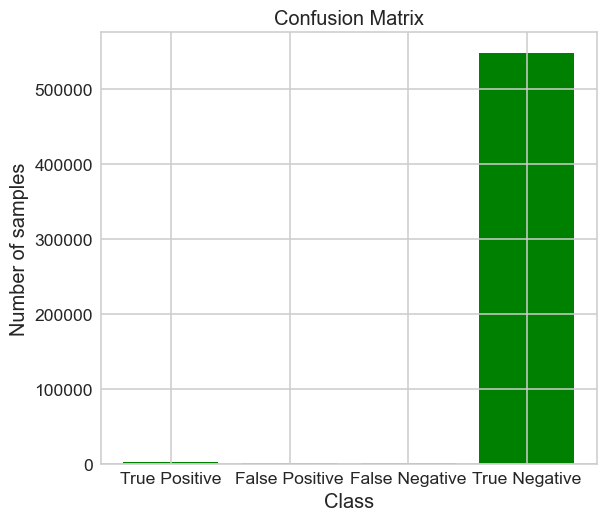

In [30]:
print("Confusion Matrix:")
print(confusion_matrix)
tp, fp = confusion_matrix[0]
fn, tn = confusion_matrix[1]

# Crear una lista con los nombres de las clases
class_names = ["True Positive", "False Positive", "False Negative", "True Negative"]

# Crear una figura y un eje para el gráfico de barras
fig, ax = plt.subplots()

# Crear el gráfico de barras
ax.bar(class_names, [tp, fp, fn, tn], color=["green", "red", "red", "green"])

# Configurar las etiquetas de los ejes y el título del gráfico
ax.set_xlabel("Class")
ax.set_ylabel("Number of samples")
ax.set_title("Confusion Matrix")

# Mostrar el gráfico
plt.show()

C:\Users\jhona\AppData\Local\Temp\ipykernel_20100\861437545.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


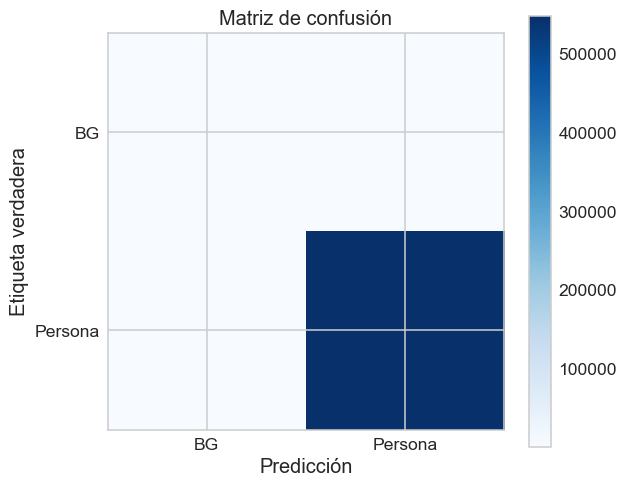

In [33]:
import matplotlib.pyplot as plt
confusion_matrix2=[[1577, 294], [578, 5487]]
# Graficar la matriz de confusión
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.colorbar()
class_names = ['BG','Persona']
plt.xticks([0, 1], class_names)
plt.yticks([0, 1], class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.show()

[[1577, 294], [578, 549487]]


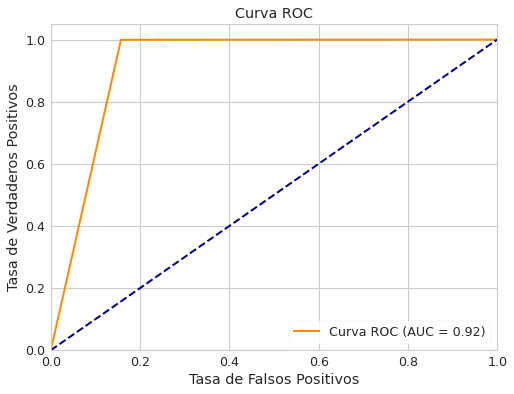

In [ ]:
####CURVAS ROC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

cm = confusion_matrix
print(cm)
cm = np.array(cm)

y_true = np.concatenate([np.zeros(cm[0, 0] + cm[0, 1]), np.ones(cm[1, 0] + cm[1, 1])])
y_scores = np.concatenate([np.zeros(cm[0, 0]), np.ones(cm[1, 0]), np.zeros(cm[0, 1]), np.ones(cm[1, 1])])

# Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de clasificación
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

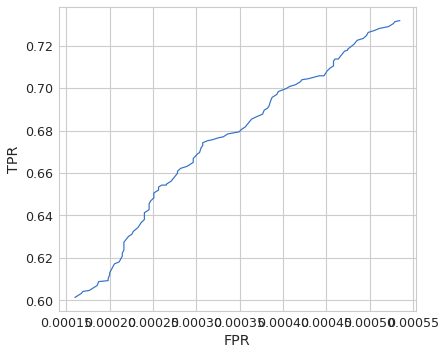

In [ ]:
fprs, tprs = lift(model, val_loader)
import matplotlib.pyplot as plt
plt.plot(fprs, tprs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

torch.Size([4, 224, 224])


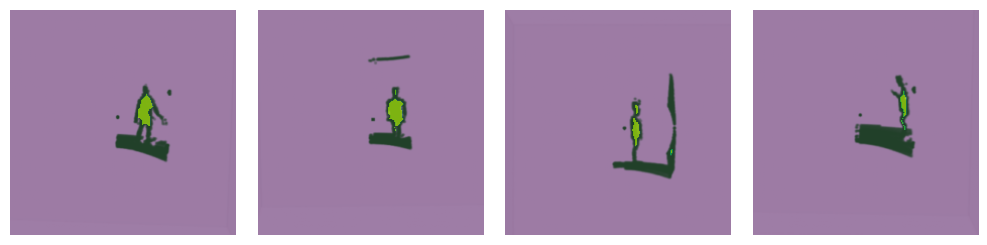

In [37]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
imgs_val = torch.narrow(imgs_val, 1, 0, 3)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [38]:
###PRUEBA // TESTEO
test_set = Person_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([4, 224, 224])


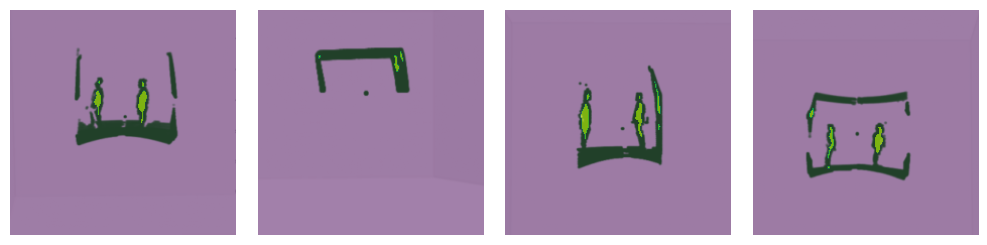

In [39]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
imgs_test = torch.narrow(imgs_test, 1, 0, 3)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))

torch.Size([4, 4, 224, 224])


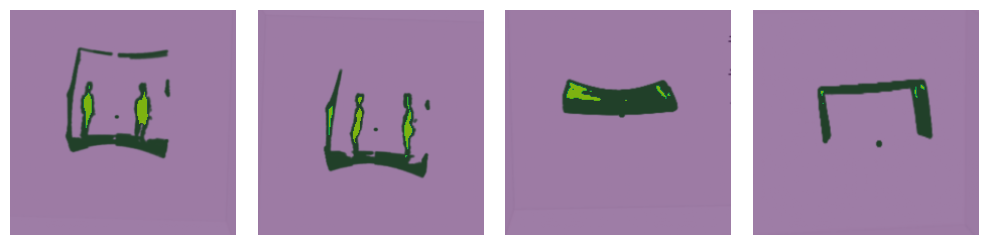

torch.Size([4, 4, 224, 224])


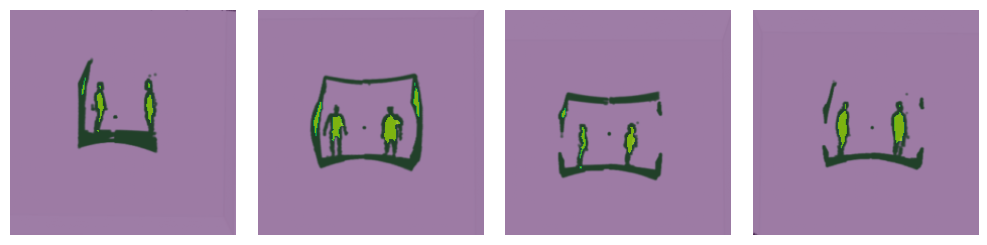

torch.Size([4, 4, 224, 224])


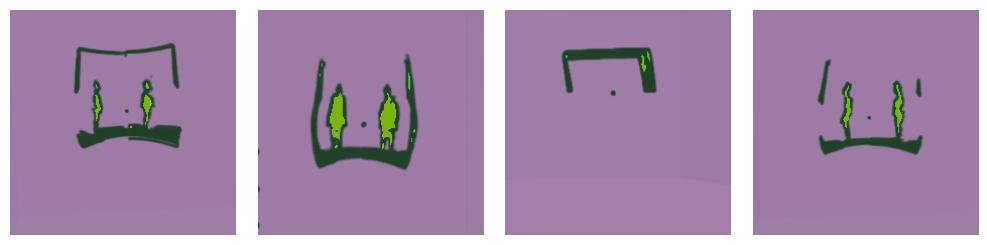

torch.Size([3, 4, 224, 224])


IndexError: index 3 is out of bounds for dimension 0 with size 3

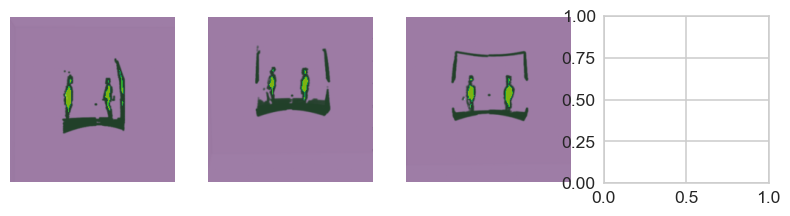

In [40]:
###PARA IMPRIMIR TODO EL DATASET
model = model.to(device)
with torch.no_grad():
    for batch in test_loader:
        imgs_test = batch.to(device, dtype=torch.float32)
        print(imgs_test.shape)
        imgs_test = torch.narrow(imgs_test, 1, 0, 3)
        
        scores = model(imgs_test)
        preds = torch.argmax(scores, dim=1).float()

        imgs_test = imgs_test.cpu()
        preds = preds.cpu()
        plot_mini_batch(imgs_test, preds.unsqueeze(1))

torch.Size([1, 3, 224, 224])


IndexError: ignored

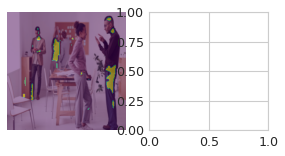

In [ ]:
###PRUEBA // TESTEO
test_set2 = Person_Dataset(TEST2_PATH, img_transforms=transform_data)
test_loader2 = DataLoader(test_set2, batch_size=BATCH_SIZE, shuffle=True)
model = model.to(device)
with torch.no_grad():
    for batch in test_loader2:
        imgs_test = batch.to(device, dtype=torch.float32)
        print(imgs_test.shape)
        imgs_test = torch.narrow(imgs_test, 1, 0, 3)
        
        scores = model(imgs_test)
        preds = torch.argmax(scores, dim=1).float()

        imgs_test = imgs_test.cpu()
        preds = preds.cpu()
        plot_mini_batch(imgs_test, preds.unsqueeze(1))

In [34]:
#!pip install opencv-python
import cv2
import torch
import numpy as np
print("hola si")
import torch
import torchvision.models as models

# Define the model architecture
#model = models.segmentation.fcn_resnet101(pretrained=False, progress=True, num_classes=2)

# Load the state dictionary of the trained model
#state_dict = torch.load('C://Users/jhona/OneDrive/Documents/semanticSegmentation/entrenamientos/model_trainedS.pth', map_location=torch.device('cpu'))

# Load the state dictionary into the model
#model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()
# Configurar la cámara
cap = cv2.VideoCapture(0)

while True:
    # Capturar una imagen de la cámara
    ret, frame = cap.read()
    
    if ret:
        # Preprocesar la imagen
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (256, 256))
        frame = np.transpose(frame, (2, 0, 1))
        frame = torch.from_numpy(frame).unsqueeze(0).float()

        # Obtener la predicción del modelo
        with torch.no_grad():
            output = model(frame)
            pred = np.argmax(output['out'].numpy()[0])
            #pred = torch.argmax(output['out'], dim=1).item()
            #pred = torch.argmax(output, dim=1).item()

        # Mostrar la imagen con la predicción
        cv2.putText(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR), f'Prediction: {pred}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        #cv2.putText(frame, f'Prediction: {pred}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        #cv2.imshow('original', frame)
        #cv2.waitKey(1)
        cv2.imshow('frame', cv2.cvtColor(np.transpose(np.array(frame[0]), (1, 2, 0)), cv2.COLOR_RGB2BGR))
        #cv2.imshow('frame', cv2.cvtColor(np.array(frame[0]), cv2.COLOR_RGB2BGR))
        #cv2.imshow('frame', cv2.cvtColor(frame.numpy()[0], cv2.COLOR_RGB2BGR))

    # Salir si se presiona la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar los recursos
cap.release()
cv2.destroyAllWindows()

hola si


TypeError: new(): invalid data type 'str'

In [37]:
#!pip install ipywebrtc

import torch
import numpy as np
from ipywebrtc import CameraStream, ImageRecorder

# Cargar el modelo entrenado previamente
#model = torch.load('mi_modelo.pt')

# Configurar la transmisión de la cámara
stream = CameraStream(constraints={'audio': False, 'video': True})

# Configurar el grabador de imágenes
recorder = ImageRecorder(format='jpeg', stream=stream)

# Obtener una imagen de la cámara web y hacer la predicción
def on_image_recorder_data(change):
    img = change['new']
    img = np.array(img.data)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float()
    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output, dim=1).item()
    print(f'Prediction: {pred}')

# Asignar la función de manejo de datos al grabador de imágenes
recorder.observe(on_image_recorder_data, names='data')

# Mostrar la transmisión de la cámara web
stream

CameraStream(constraints={'audio': False, 'video': True})